# Make bar plots of ROH tracts
Make admixture style plots of ROH, both expected as well as for empirical Individuals

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./PackagesSupport/")
from roh_expectations import Expected_Roh

VioletQueen
/home/harald/git/HAPSBURG
CPU Count: 4


### Calculate some expectations

In [2]:
def create_cousins_roh(degrees=[1,2,3], bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    c_roh = np.zeros((len(degrees),len(bins))) # Container for results Cousins
    for i,c in enumerate(degrees):
        for j,b in enumerate(bins):
            m = c*2 + 4
            c_roh[i,j] = e_roh.exp_roh_len_in_bin_rel(l=b, m=m, comm_anc=4, bins=10000)
    return c_roh

#bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]  # The bins I want to plot (eventually maybe do 12,16 as welll)
#cousins = [1, 2, 3]  # Which Cousins to Plot

def create_Ne_roh(Ns= [400, 800, 1600, 3200, 6400], bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    n_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            n_roh[i,j] = e_roh.exp_roh_len_in_bin_N(b, N=N, bins=10000)
    return n_roh

In [3]:
%%time
bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]
Ns=[400, 800, 1600, 3200, 6400]
degrees=[1,2,3]

### Calcualte Expectations Cousins:
c_roh = create_cousins_roh(degrees=degrees, bins = bins)

### Calculate Expectations Ne:
n_roh = create_Ne_roh(Ns=Ns, bins = bins)

CPU times: user 356 ms, sys: 39.1 ms, total: 395 ms
Wall time: 393 ms


In [4]:
print(c_roh)
print(n_roh)

n_roh[:,2] / n_roh[:,0]

[[0.15417107 0.1989896  1.79197005]
 [0.0579345  0.06908513 0.39969971]
 [0.01947492 0.02146337 0.08786535]]
[[1.03261547 0.35490188 0.67148832]
 [0.53420341 0.18084461 0.33841895]
 [0.27173783 0.09128736 0.16988509]
 [0.13704896 0.04586206 0.08511232]
 [0.06882217 0.02298589 0.04259872]]


array([0.65027916, 0.63350204, 0.62518012, 0.62103588, 0.61896795])

# Code for the Main Figure

### Idea:
Code should be very modular: The large figure uses gridspec to split 
up axis space, and on each axis I plot the bars, with legends / colors for populations below
(and maybe small age inlets).

The big code splits up the space according to sample Nr. The small axis do the plotting

### Do a subfigure

In [5]:
#["royalblue", "#ffffbf", "#fc8d59"]
#["royalblue", "gray", "coral"]

def plot_bar_ax(ax, fracs, bins=[], c=["royalblue", "#ffffbf", "#fc8d59"], x_ticks = [], 
                ec = "silver", fs_l=10, fs = 10, fs_x=8, barWidth=0.95, ylim = [0,220], stds = [], title="", 
                yticks=False, legend=False, r_title=0):
    """Plot bars of ROH on Axis.
    ax: Where to Plot on
    fracs: Fractions of Expected ROH: [n Inds, n Bins]
    c: Which colors to plot
    bins: List of Bins (needed for legend - plotted if len()>0)
    yticks: Whether to plot Y tick Labels
    legend: Whether to plot Legend
    fs_x: Fontsize on the x Labels
    r_title: Rotation of the title"""
    y = fracs ### Fractions (along 1st axis length classses)
    x = np.arange(len(y))

    for i in range(len(y[0,:])): # From last to first (For Legend)
        b = np.sum(y[:,:i], axis=1)
        ax.bar(x, y[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=f"{bins[i,0]}-{bins[i,1]} cM", alpha=0.9)
        if len(stds)>0 and i>0: # Plot some standard deviations.
            ax1.errorbar(r, b, yerr=stds[:,i], fmt='none', linewidth=2, color="k")
    if legend:
        ax.legend(fontsize=fs_l, loc="upper right", title="Sum ROH in")
    ax.set_ylabel("Expected Sum ROH [cM]", fontsize=fs)
    ax.set_ylim(ylim)
    ax.set_xlim(x[0] - 0.7*barWidth, x[-1] + 0.7*barWidth)
    if len(x_ticks)>0:
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticks, fontsize=fs_x, rotation=270)
    else:
        ax.set_xticks([])
    if not yticks:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    if len(title)>0:
        ax.set_title(title, fontsize=fs, rotation=r_title)
        
def plot_panel_row(plot_dfs, wspace=0.05, hspace=0.01, figsize=(24,3.5), savepath="", x_ticks=True,
                   c=["royalblue", "#ffffbf", "#fc8d59"], ylim = [0,250], r_title = 90, 
                   leg_pos = -2, show=True, title_col="clst"):
    """Plot row of ROH bin plots from plot_dfs (each df one panel)
    leg_pos = Where to plot legend (if outside range no legend plot)
    r_title: How much to rotate the title
    gs: Gridspec: If given plot on there"""
    bins_cM=(np.array(bins)*100).astype("int")
    n_plots = len(plot_dfs)+2
    width_ratios = [len(df) for df in plot_dfs]+[len(c_roh),len(n_roh)]
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, n_plots, width_ratios=width_ratios, figure=fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for i,df in enumerate(plot_dfs):   
        if i==0:
            ytick=True
        else:
            ytick=False

        if i == (len(plot_dfs) + leg_pos):
            legend=True
        else:
            legend=False

        ax = plt.subplot(gs[i])    # Extract the Sub Plot to Plot onto
        obs_roh = df[cols].values
        obs_roh[:,0] = obs_roh[:,0] - obs_roh[:,1]
        obs_roh[:,1] = obs_roh[:,1] - obs_roh[:,2]
        obs_roh[:,2] = obs_roh[:,2]
        
        if x_ticks:
            x_ticks0 = df["iid"].values
        else: 
            x_ticks0 = []
        plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title, c=c,
                    x_ticks = x_ticks0, title=df[title_col].values[0], ylim=ylim)

    #### Plot the legend bars
    ### 1) Small Pops
    ax = plt.subplot(gs[-2])    # The left subplot (Timeline)
    plot_bar_ax(ax, c_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim, c=c,
               x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops", r_title=r_title)
    ### 2) Cousins
    ax = plt.subplot(gs[-1])
    ticks_N = [f"2N={i}" for i in Ns]
    plot_bar_ax(ax, n_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim,
               x_ticks = ticks_N, title="Small Pop. Size", r_title=r_title)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
    if show:
        plt.show()
    
    
def plot_legend_only(figsize=(7,6), wspace=0.05, hspace=0.01, savepath="",
                     fs=12, fs_l=10, fs_x=10, c=["royalblue", "#ffffbf", "#fc8d59"]):
    """Plot Inbreeding from recent Cousins as well as small pop size"""
    width_ratios = [len(c_roh), len(n_roh)]
    bins_cM=(np.array(bins)*100).astype("int")
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios, figure=fig)
    ax_cousin = plt.subplot(gs[0])    # The left subplot (Timeline)
    ax_Ne = plt.subplot(gs[1])
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    ### Plot the figure
    plot_bar_ax(ax_cousin, c_roh*100, bins_cM, yticks=True, legend=False, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, c=c,
                x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops")

    ticks_N = [f"2N={i}" for i in Ns]
    plot_bar_ax(ax_Ne, n_roh*100, bins_cM, yticks=False, legend=True, c=c, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, x_ticks = ticks_N, title="Small Pop. Size")

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}") 
    plt.show()
    
def prepare_dfs_plot(df, cms=[4,8,12], col_group="clst", split_modern=True,
                     mod_group="pop"):
    """Prepare the Dataframe which to plot
    Return split up (and sorted) list of df, return list of column names
    df: Master Dataframe
    cms: Minimum Length of Chromosomes in bins
    if split_modern, split age==0 samples by mod_group
    """
    
    if split_modern:
        mod_idx = df["age"]==0  # Pull out modern idx
        df.loc[mod_idx, col_group]=df.loc[mod_idx, mod_group]
        
    plot_dfs = [dft for _, dft in df.groupby(col_group)]
    ### Sort by age
    idx = np.argsort([-df["age"].values[0] for df in plot_dfs])
    plot_dfs = [plot_dfs[i] for i in idx] ## Sort
    
    ### Sort by 
    cms = [4,8,12]
    cols = [f"sum_roh>{cm}" for cm in cms]
    for df in plot_dfs:
        df.sort_values(by=cols[0], inplace=True, ascending=False)
    return plot_dfs, cols

### Single Example for theoretical Expectations [For Supplement]

Saved figure to ./figures/manuscript/supplement/bar_expectations.pdf


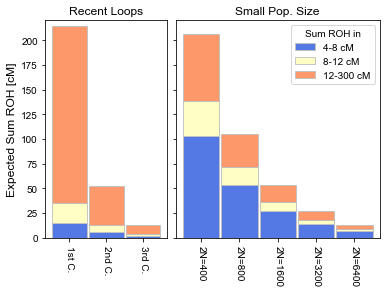

In [6]:
plot_legend_only(savepath="./figures/manuscript/supplement/bar_expectations.pdf", figsize=(6,4))

## Do the Plot for empirical data

### Roman Data Row

Saved figure to ./figures/roman_pilot.pdf


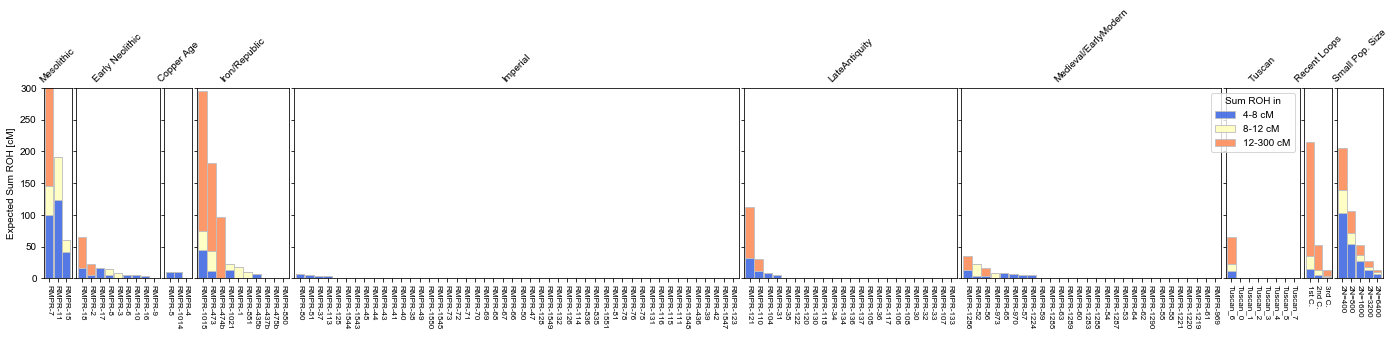

In [7]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Rome"]
plot_dfs, cols = prepare_dfs_plot(df1)

plot_panel_row(plot_dfs, savepath="./figures/roman_pilot.pdf", 
               wspace=0.035, r_title=45, leg_pos=-1, ylim=[0,300])

## Iberia transect Row

Saved figure to ./figures/iberia_pilot.pdf


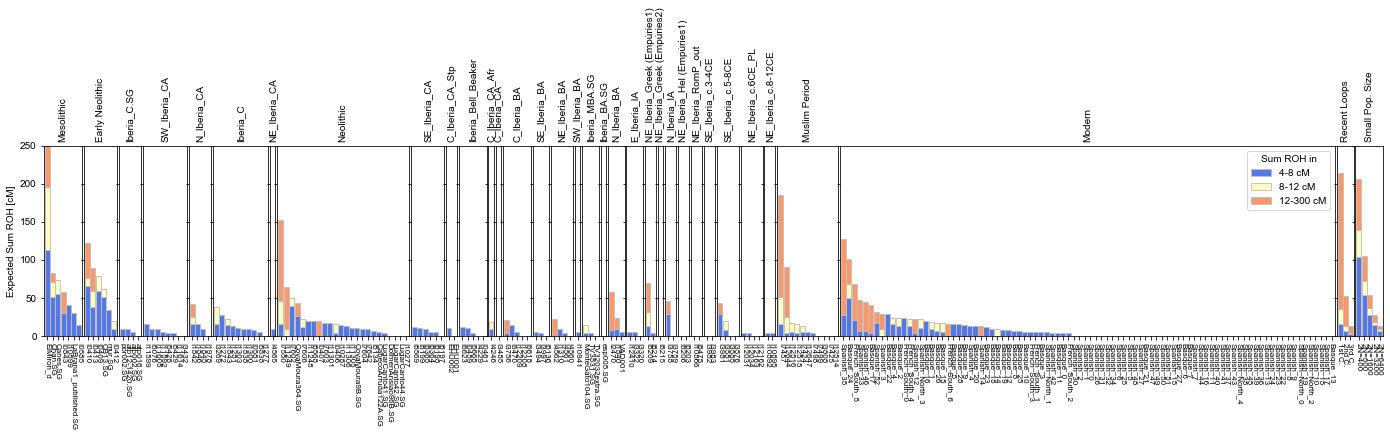

In [11]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Iberia"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures/iberia_pilot.pdf", leg_pos=-1)

### Balkans

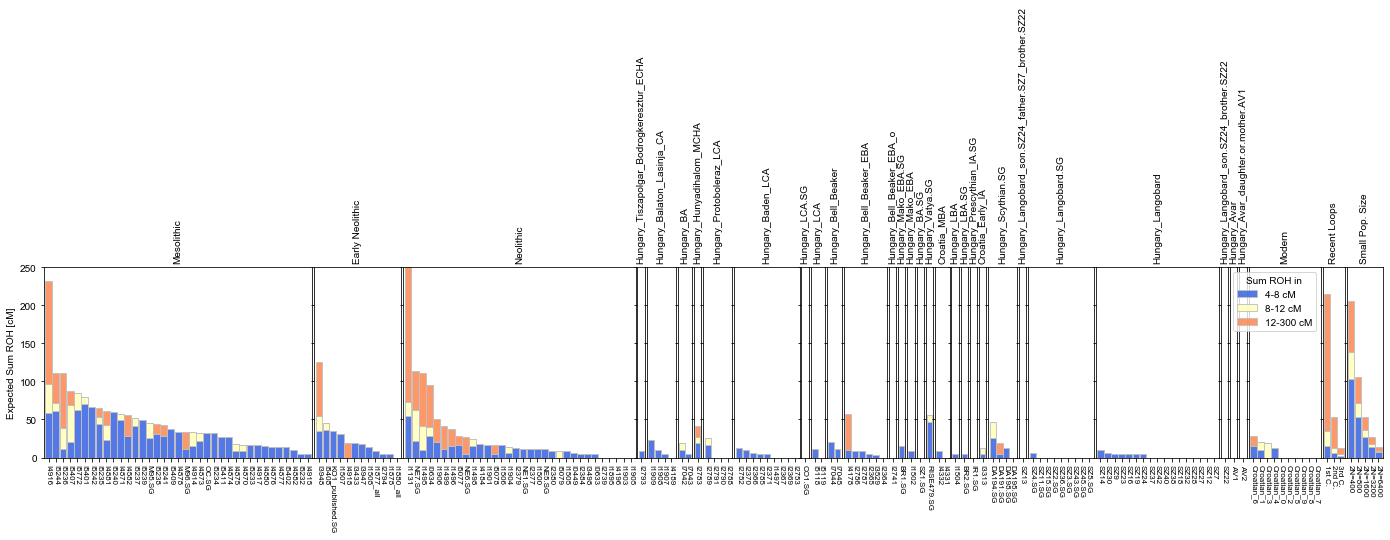

In [10]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Balkans"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

### Aegan

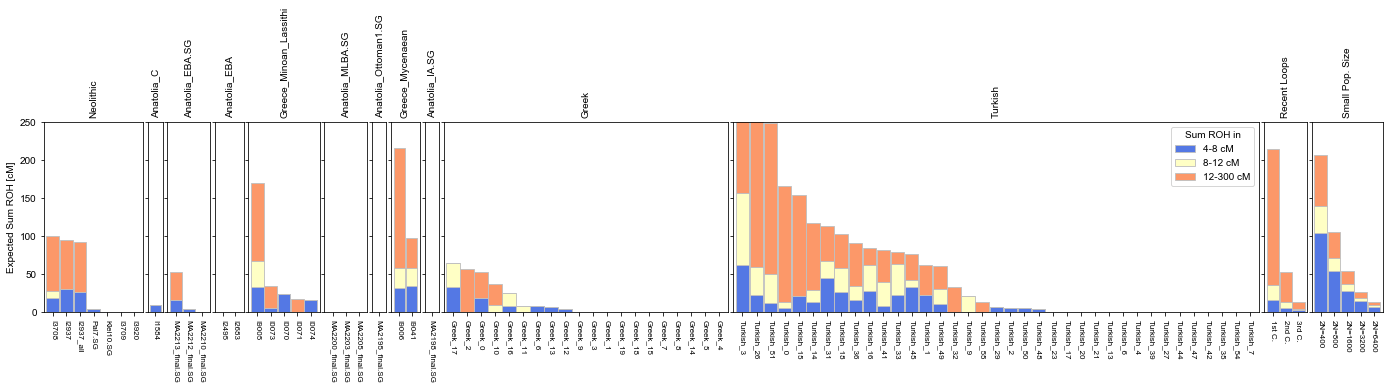

In [61]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Aegan"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

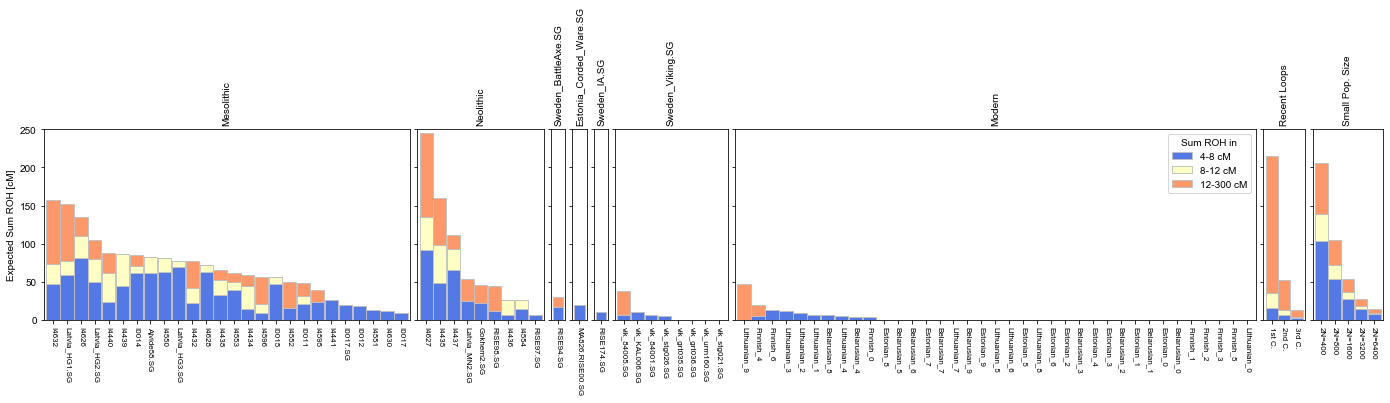

In [138]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Baltic Sea"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

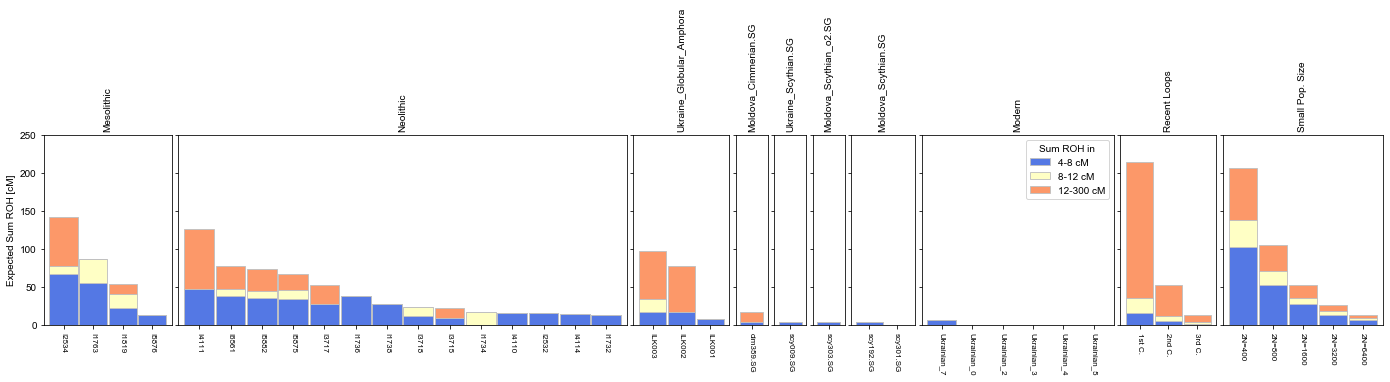

In [140]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Black Sea"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

Saved figure to ./figures_test/vanuatu_bar.pdf


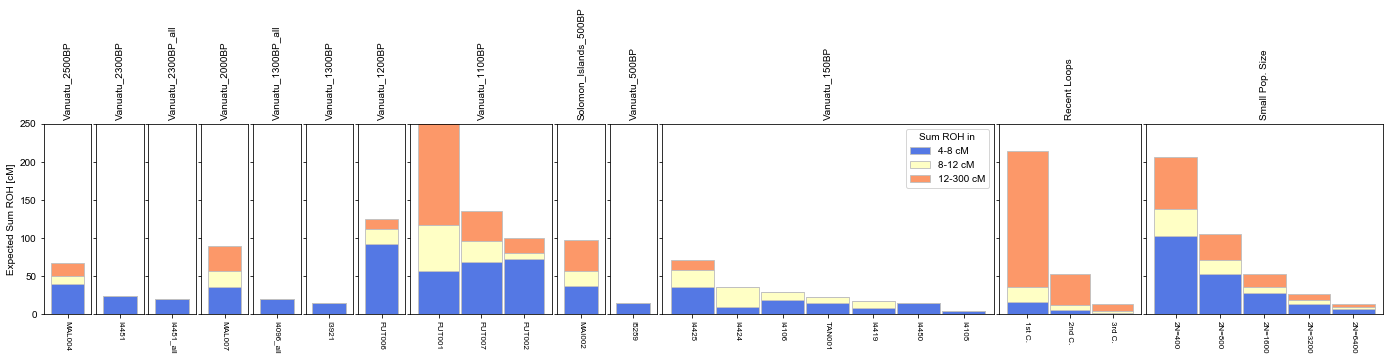

In [142]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Vanuatu"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures_test/vanuatu_bar.pdf", leg_pos=-1)

Saved figure to ./figures/levante_pilot.pdf


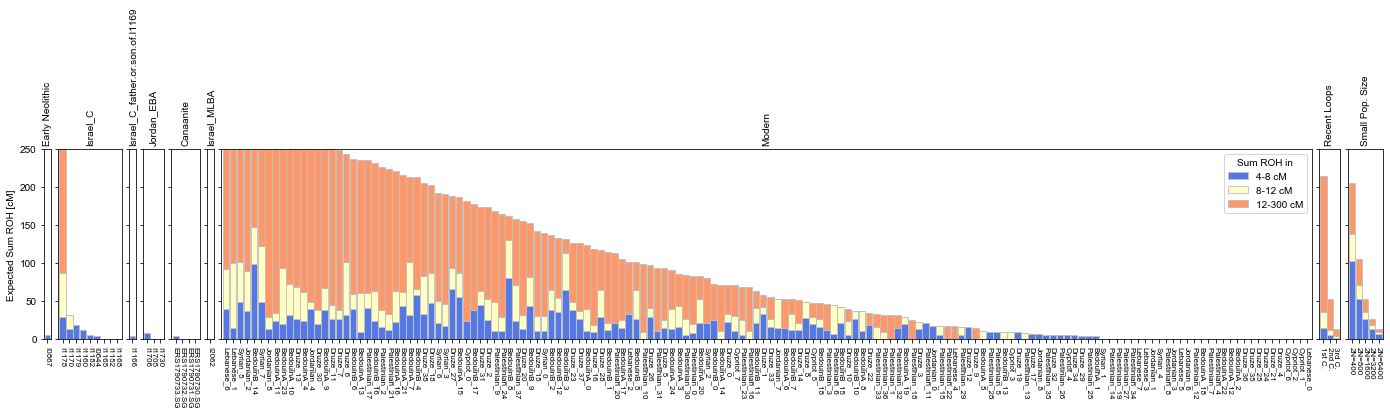

In [109]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Levante"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="./figures/levante_pilot.pdf", leg_pos=-1)

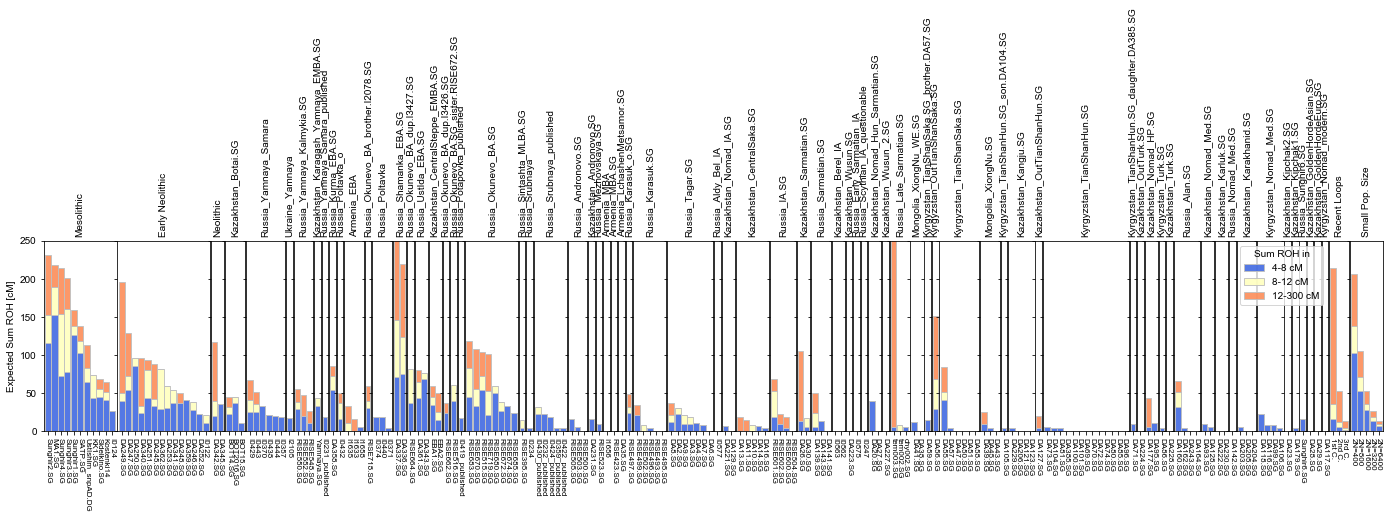

In [15]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Steppe"]
df1 = df1[df1["age"]>0] # Only Modern Samples
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

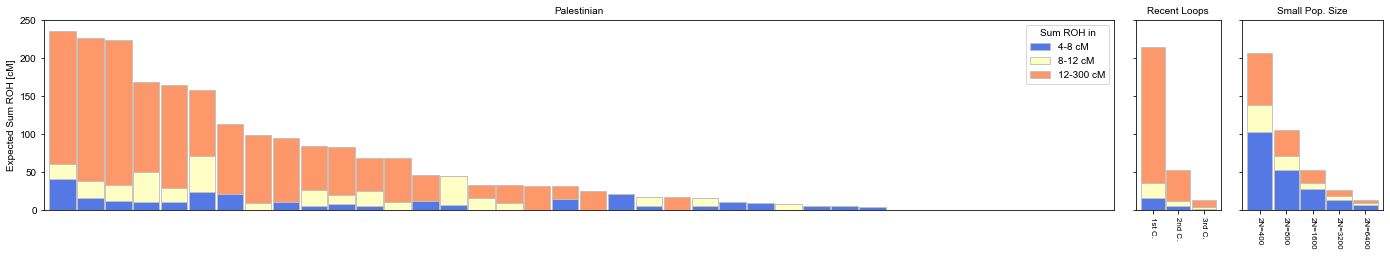

In [63]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Palestinian"]  #BedouinA Palestinian
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, x_ticks=False, r_title=0)

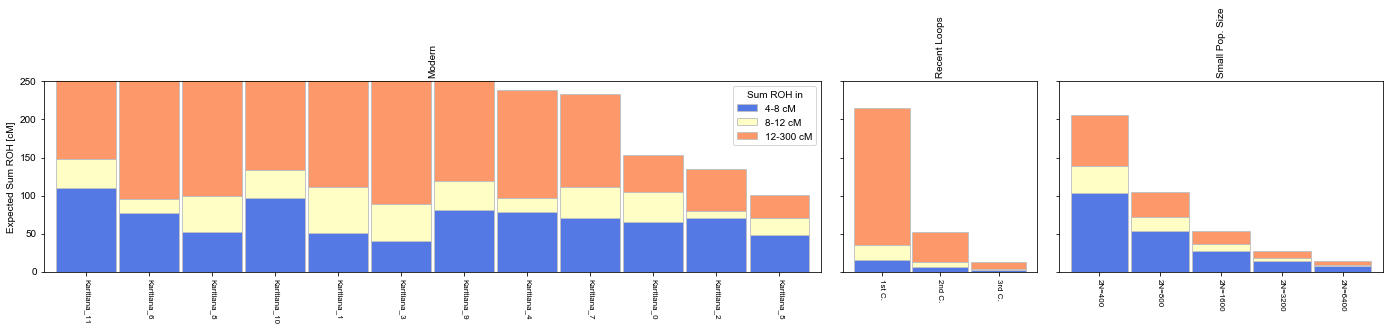

In [53]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Karitiana"]
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1)

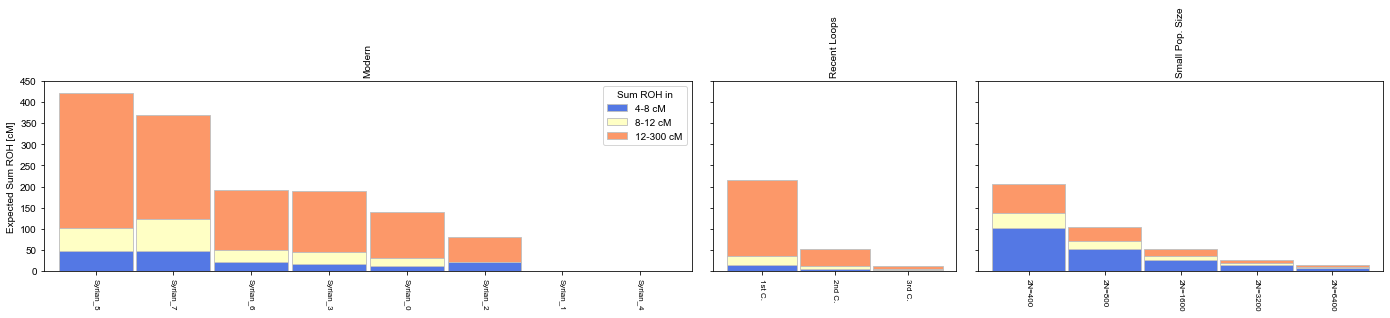

In [54]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Syrian"] # Sindhi/Saudi/Makrani
plot_dfs1, cols = prepare_dfs_plot(df1)
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, ylim=[0,450])

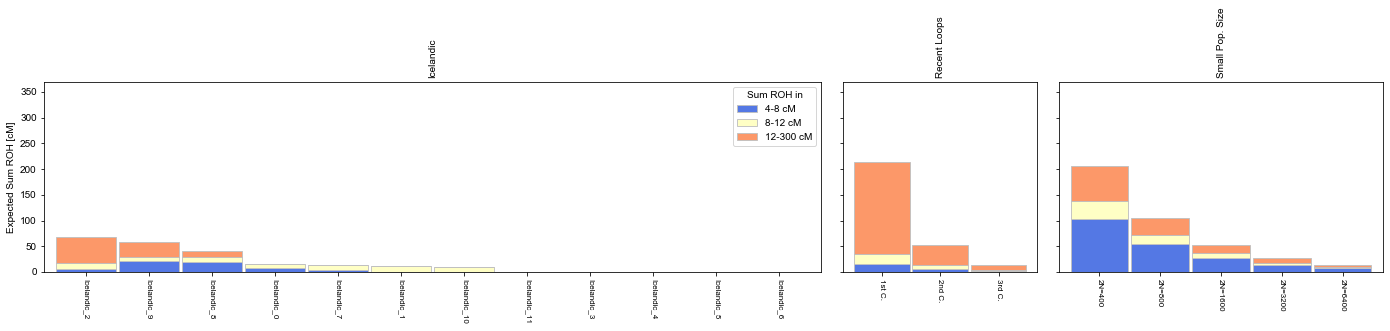

In [115]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Icelandic"] # Sindhi/Saudi/Makrani/Pathan
plot_dfs1, cols = prepare_dfs_plot(df1)
#c = ["#91bfdb", "#ffffbf", "#fc8d59"]
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, ylim=[0,370])

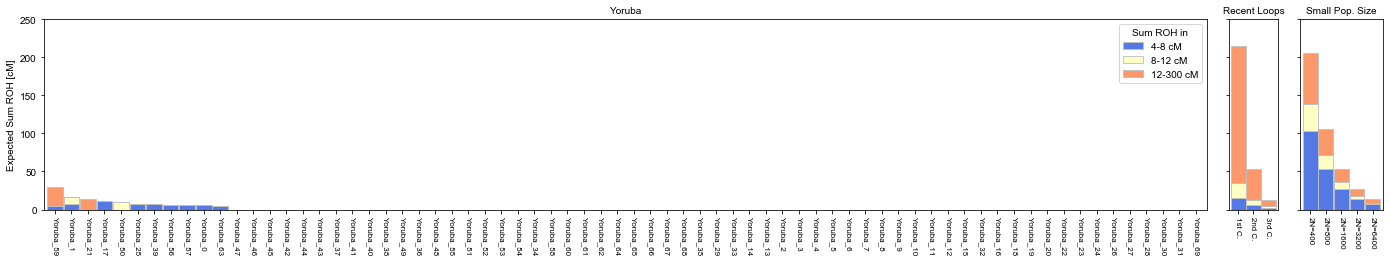

In [11]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["pop"]=="Yoruba"] # Sindhi/Saudi/Makrani/Nganasan/Mozabite
plot_dfs1, cols = prepare_dfs_plot(df1)
#c = ["#67a9cf",  "gray", "#ef8a62"]
#c = ["#5e3c99", "#fdb863", "#e66101"]
#c = ["#91bfdb", "#ffffbf", "#fc8d59"]
plot_panel_row(plot_dfs1, savepath="", leg_pos=-1, ylim=[0,250], r_title=0)

In [ ]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1.sort_values(by="sum_roh>12", ascending=False)

# Do for Human Origins Dataset

Doing Population Jordanian: 9 Individuals
Saved figure to ./figures/ho_pops_barplots/Jordanian.pdf
Doing Population BedouinA: 25 Individuals
Saved figure to ./figures/ho_pops_barplots/BedouinA.pdf
Doing Population Oroqen: 9 Individuals
Saved figure to ./figures/ho_pops_barplots/Oroqen.pdf
Doing Population Tunisian_Jew: 7 Individuals
Saved figure to ./figures/ho_pops_barplots/Tunisian_Jew.pdf
Doing Population Punjabi: 8 Individuals
Saved figure to ./figures/ho_pops_barplots/Punjabi.pdf
Doing Population Iranian_Jew: 9 Individuals
Saved figure to ./figures/ho_pops_barplots/Iranian_Jew.pdf
Doing Population Brahui: 21 Individuals
Saved figure to ./figures/ho_pops_barplots/Brahui.pdf
Doing Population Ukrainian: 9 Individuals
Saved figure to ./figures/ho_pops_barplots/Ukrainian.pdf
Doing Population Belarusian: 10 Individuals
Saved figure to ./figures/ho_pops_barplots/Belarusian.pdf
Doing Population Tajik_Pomiri: 8 Individuals
Saved figure to ./figures/ho_pops_barplots/Tajik_Pomiri.pdf
Doing P

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Basque.pdf
Doing Population She: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/She.pdf
Doing Population Kyrgyz: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kyrgyz.pdf
Doing Population Cambodian: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Cambodian.pdf
Doing Population Thai: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Thai.pdf
Doing Population Naxi: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Naxi.pdf
Doing Population Albanian: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Albanian.pdf
Doing Population Ethiopian_Jew: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Ethiopian_Jew.pdf
Doing Population Mozabite: 21 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mozabite.pdf
Doing Population Ashkenazi_Jew: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Ashkenazi_Jew.pdf
Doing Population Karitiana: 12 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Karitiana.pdf
Doing Population Hungarian: 20 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Hungarian.pdf
Doing Population Finnish: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Finnish.pdf
Doing Population Ulchi: 25 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Ulchi.pdf
Doing Population Khomani: 11 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Khomani.pdf
Doing Population Koryak: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Koryak.pdf
Doing Population Tlingit: 4 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Tlingit.pdf
Doing Population English: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/English.pdf
Doing Population Adygei: 17 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Adygei.pdf
Doing Population Zapotec: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Zapotec.pdf
Doing Population Mandenka: 17 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mandenka.pdf
Doing Population Iraqi_Jew: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Iraqi_Jew.pdf
Doing Population Turkish_Jew: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Turkish_Jew.pdf
Doing Population Lebanese: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Lebanese.pdf
Doing Population Hadza: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Hadza.pdf
Doing Population Croatian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Croatian.pdf
Doing Population Tuvinian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Tuvinian.pdf
Doing Population Tuscan: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Tuscan.pdf
Doing Population Papuan: 14 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Papuan.pdf
Doing Population Kusunda: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kusunda.pdf
Doing Population Yemen: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Yemen.pdf
Doing Population Cypriot: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Cypriot.pdf
Doing Population Tujia: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Tujia.pdf
Doing Population Bengali: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Bengali.pdf
Doing Population Burusho: 23 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Burusho.pdf
Doing Population Gambian: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Gambian.pdf
Doing Population Balochi: 20 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Balochi.pdf
Doing Population Mixtec: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mixtec.pdf
Doing Population French_South: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/French_South.pdf
Doing Population Esan: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Esan.pdf
Doing Population Mongola: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mongola.pdf
Doing Population Iranian: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Iranian.pdf
Doing Population Pathan: 19 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Pathan.pdf
Doing Population Lahu: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Lahu.pdf
Doing Population Canary_Islanders: 2 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Canary_Islanders.pdf
Doing Population Maltese: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Maltese.pdf
Doing Population Mordovian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mordovian.pdf
Doing Population Selkup: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Selkup.pdf
Doing Population Nganasan: 11 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Nganasan.pdf
Doing Population French: 25 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/French.pdf
Doing Population Surui: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Surui.pdf
Doing Population Scottish: 4 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Scottish.pdf
Doing Population GujaratiB: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/GujaratiB.pdf
Doing Population Luo: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Luo.pdf
Doing Population Nogai: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Nogai.pdf
Doing Population Bergamo: 12 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Bergamo.pdf
Doing Population Masai: 12 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Masai.pdf
Doing Population Saami_WGA: 1 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Saami_WGA.pdf
Doing Population Algerian: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Algerian.pdf
Doing Population Armenian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Armenian.pdf
Doing Population Saudi: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Saudi.pdf
Doing Population Chechen: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Chechen.pdf
Doing Population Ju_hoan_North: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Ju_hoan_North.pdf
Doing Population Kumyk: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kumyk.pdf
Doing Population Turkish: 56 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Turkish.pdf
Doing Population Uygur: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Uygur.pdf
Doing Population Spanish: 53 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Spanish.pdf
Doing Population Xibo: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Xibo.pdf
Doing Population Norwegian: 11 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Norwegian.pdf
Doing Population Kinh: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kinh.pdf
Doing Population BedouinB: 19 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/BedouinB.pdf
Doing Population Han_NChina: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Han_NChina.pdf
Doing Population Atayal: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Atayal.pdf
Doing Population Japanese: 29 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Japanese.pdf
Doing Population Lithuanian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Lithuanian.pdf
Doing Population Lezgin: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Lezgin.pdf
Doing Population Kalash: 18 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kalash.pdf
Doing Population Tunisian: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Tunisian.pdf
Doing Population Druze: 39 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Druze.pdf
Doing Population Kalmyk: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kalmyk.pdf
Doing Population Mixe: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mixe.pdf
Doing Population Yi: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Yi.pdf
Doing Population Italian_South: 1 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Italian_South.pdf
Doing Population Estonian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Estonian.pdf
Doing Population Piapoco: 4 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Piapoco.pdf
Doing Population Bougainville: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Bougainville.pdf
Doing Population Turkmen: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Turkmen.pdf
Doing Population BantuSA: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/BantuSA.pdf
Doing Population BantuKenya: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/BantuKenya.pdf
Doing Population Aleut: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Aleut.pdf
Doing Population Yukagir: 19 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Yukagir.pdf
Doing Population Miao: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Miao.pdf
Doing Population Abkhasian: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Abkhasian.pdf
Doing Population Makrani: 20 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Makrani.pdf
Doing Population Palestinian: 38 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Palestinian.pdf
Doing Population Mayan: 18 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mayan.pdf
Doing Population Greek: 20 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Greek.pdf
Doing Population Bulgarian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Bulgarian.pdf
Doing Population Even: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Even.pdf
Doing Population Itelmen: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Itelmen.pdf
Doing Population Eskimo: 22 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Eskimo.pdf
Doing Population Biaka: 20 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Biaka.pdf
Doing Population Mansi: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mansi.pdf
Doing Population Bolivian: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Bolivian.pdf
Doing Population Orcadian: 13 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Orcadian.pdf
Doing Population Cochin_Jew: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Cochin_Jew.pdf
Doing Population Egyptian: 18 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Egyptian.pdf
Doing Population Balkar: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Balkar.pdf
Doing Population Kikuyu: 4 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Kikuyu.pdf
Doing Population Australian: 3 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Australian.pdf
Doing Population Datog: 3 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Datog.pdf
Doing Population Somali: 13 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Somali.pdf
Doing Population Russian: 22 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Russian.pdf
Doing Population GujaratiC: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/GujaratiC.pdf
Doing Population Chukchi: 23 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Chukchi.pdf
Doing Population Saharawi: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Saharawi.pdf
Doing Population AA: 12 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/AA.pdf
Doing Population Tu: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Tu.pdf
Doing Population Icelandic: 12 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Icelandic.pdf
Doing Population Yoruba: 70 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Yoruba.pdf
Doing Population Chuvash: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Chuvash.pdf
Doing Population Yemenite_Jew: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Yemenite_Jew.pdf
Doing Population GujaratiD: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/GujaratiD.pdf
Doing Population Libyan_Jew: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Libyan_Jew.pdf
Doing Population Korean: 6 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Korean.pdf
Doing Population Dai: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Dai.pdf
Doing Population Czech: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Czech.pdf
Doing Population Mende: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mende.pdf
Doing Population Dolgan: 3 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Dolgan.pdf
Doing Population Altaian: 7 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Altaian.pdf
Doing Population Uzbek: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Uzbek.pdf
Doing Population Spanish_North: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Spanish_North.pdf
Doing Population Quechua: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Quechua.pdf
Doing Population Yakut: 20 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Yakut.pdf
Doing Population Daur: 9 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Daur.pdf
Doing Population Syrian: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Syrian.pdf
Doing Population Georgian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Georgian.pdf
Doing Population GujaratiA: 5 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/GujaratiA.pdf
Doing Population Ami: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Ami.pdf
Doing Population Luhya: 8 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Luhya.pdf
Doing Population North_Ossetian: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/North_Ossetian.pdf
Doing Population Mbuti: 10 Individuals


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Saved figure to ./figures/ho_pops_barplots/Mbuti.pdf


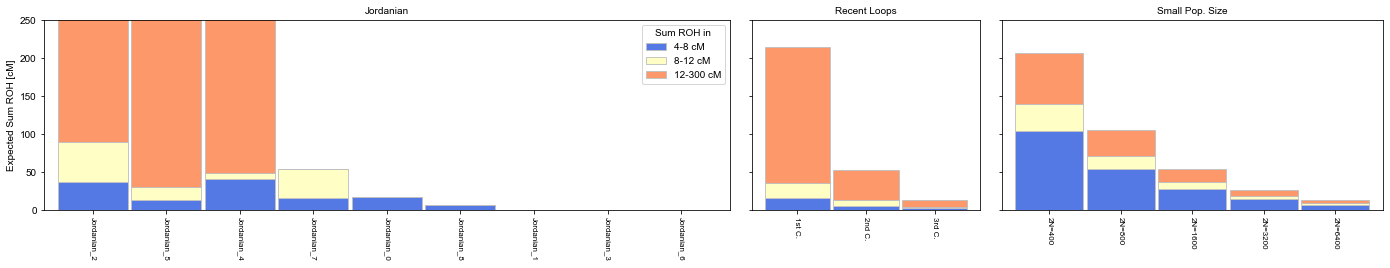

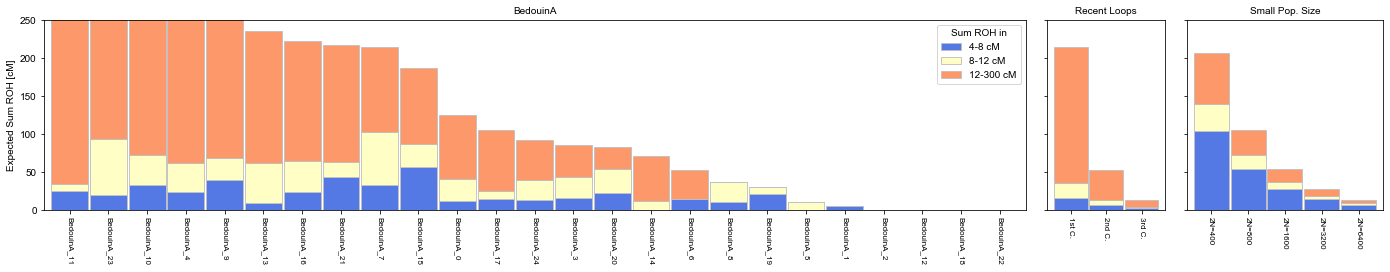

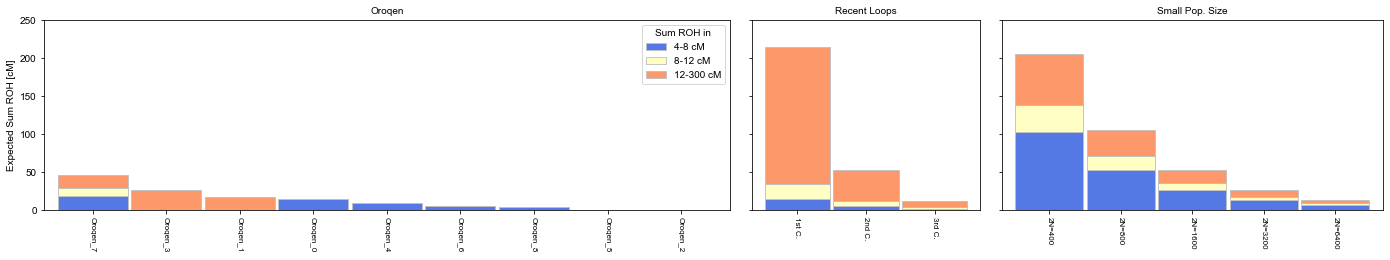

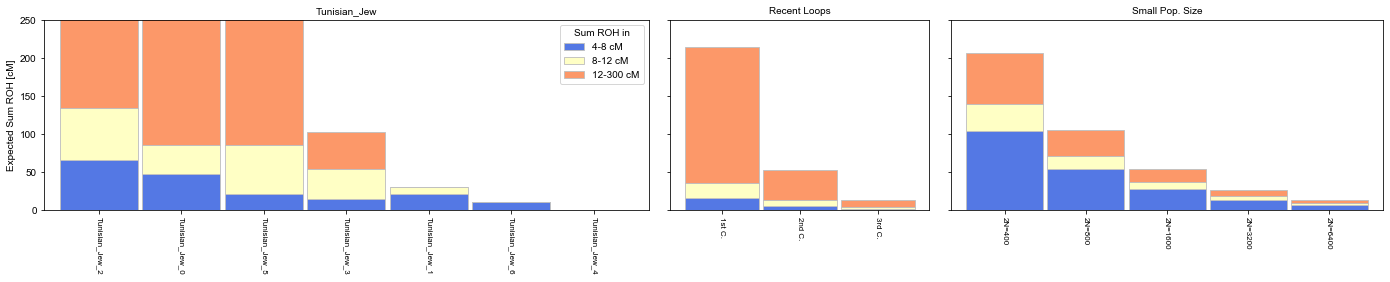

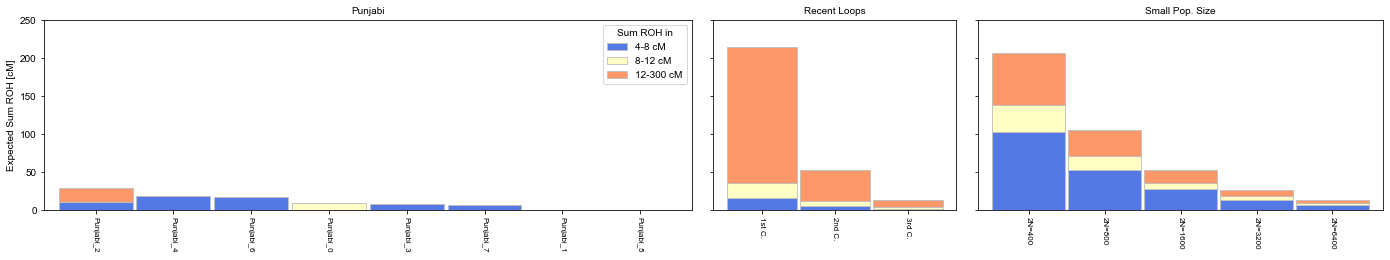

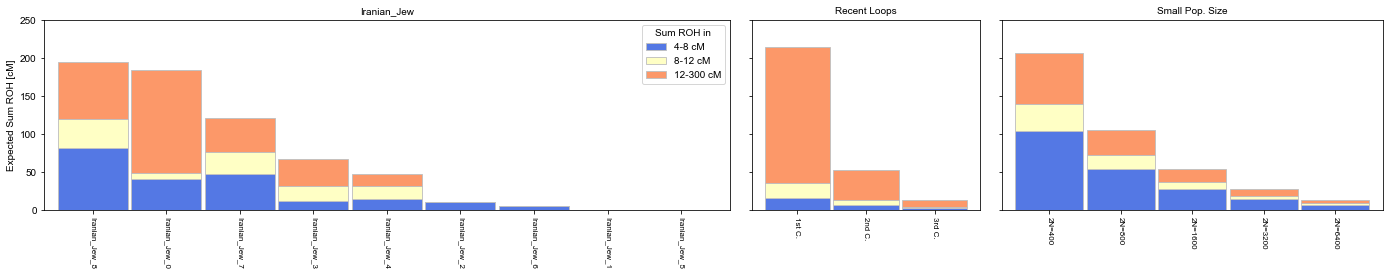

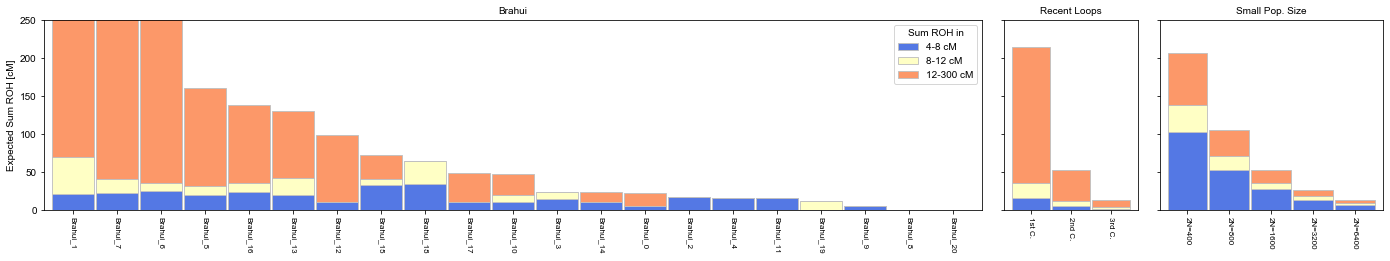

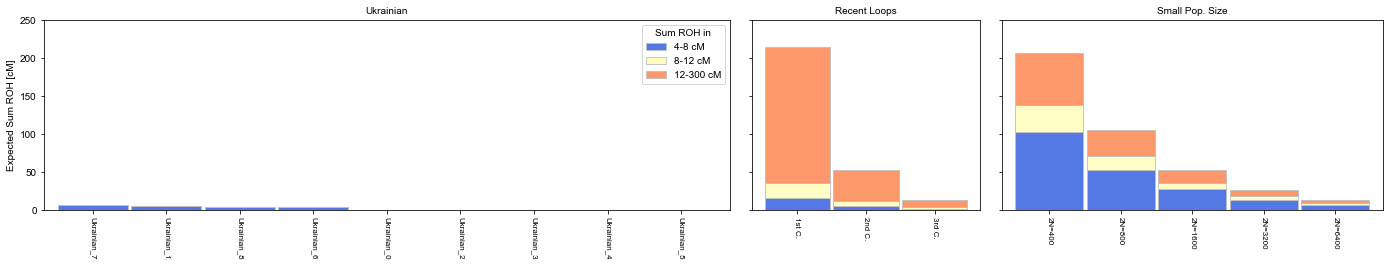

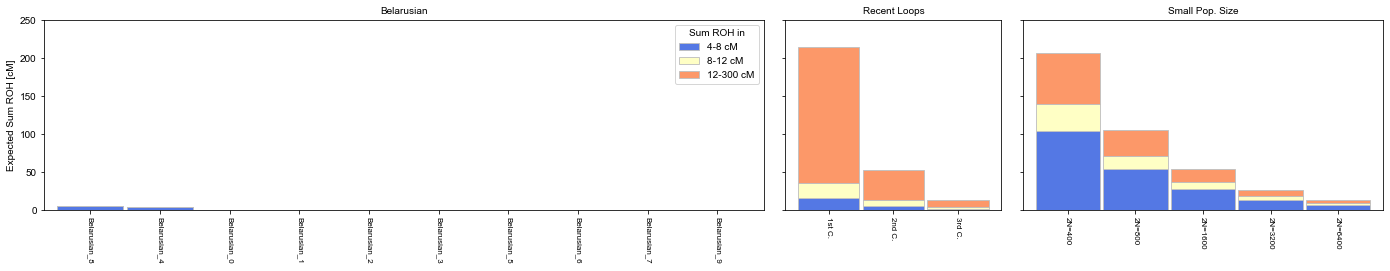

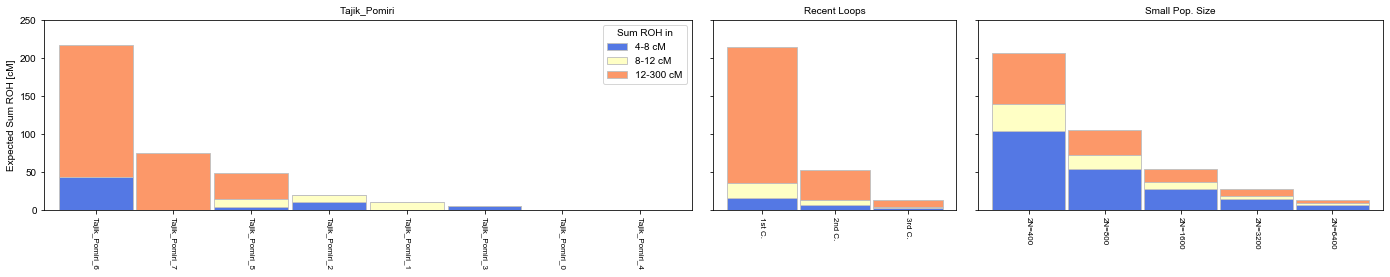

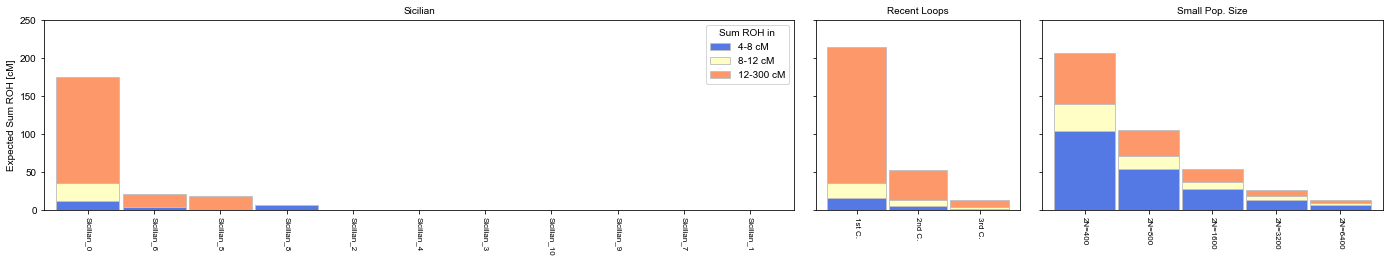

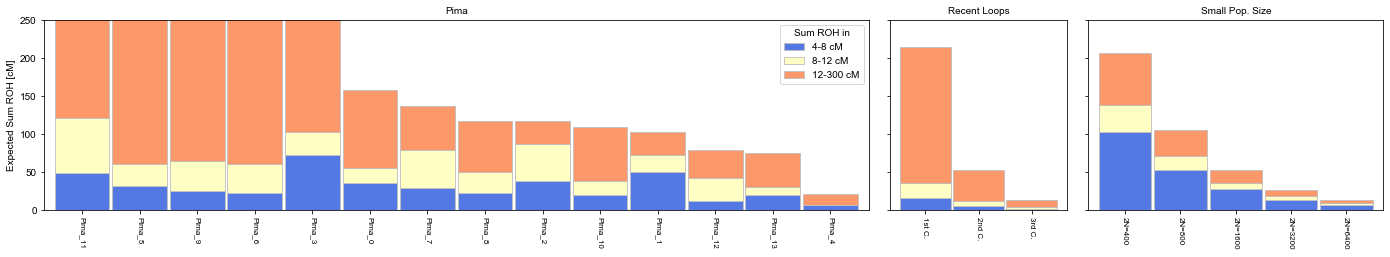

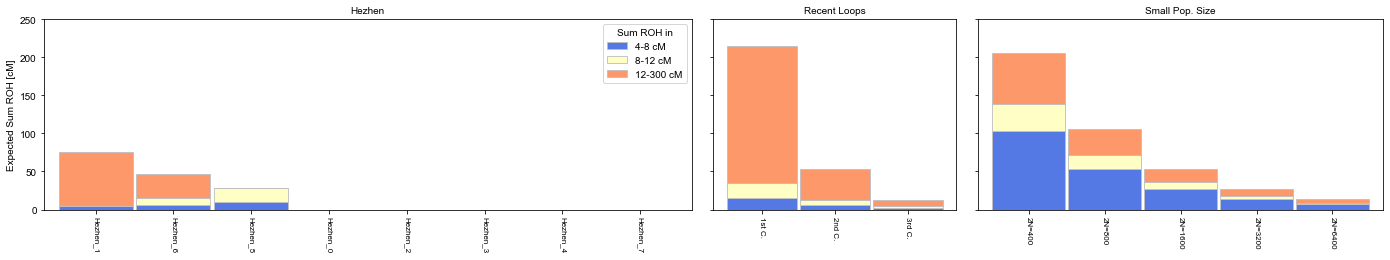

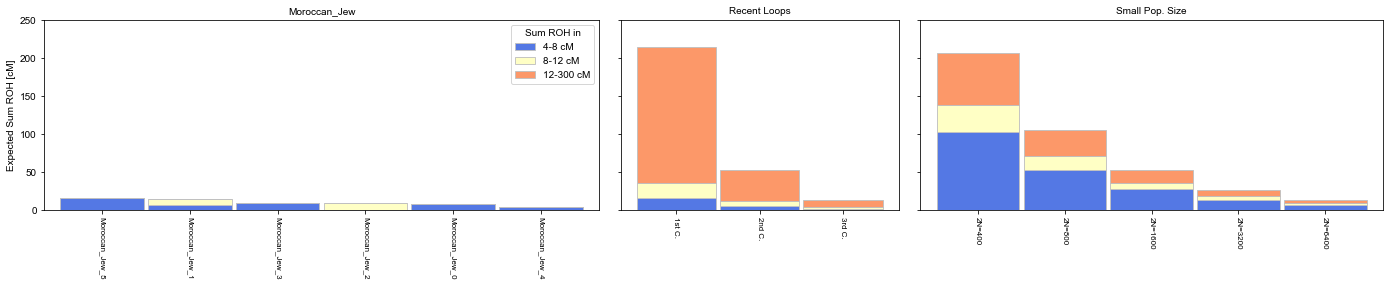

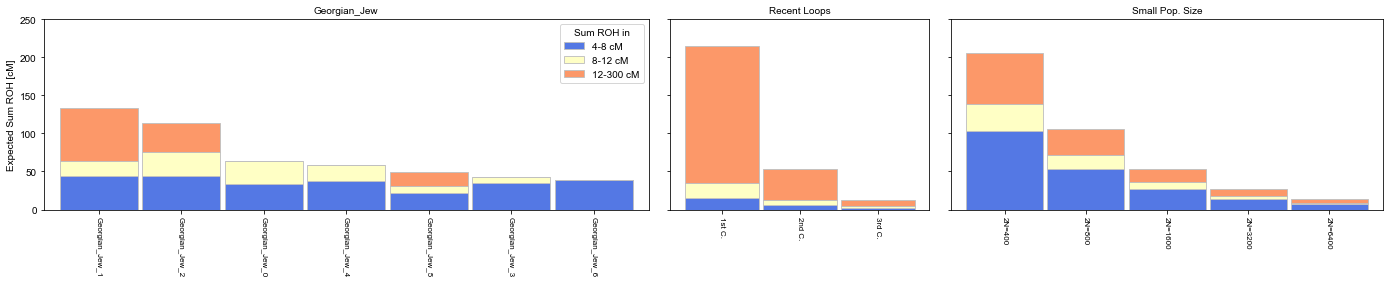

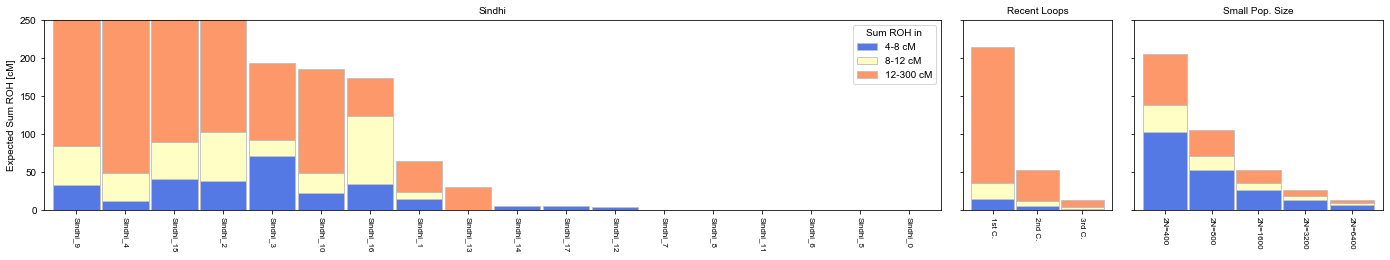

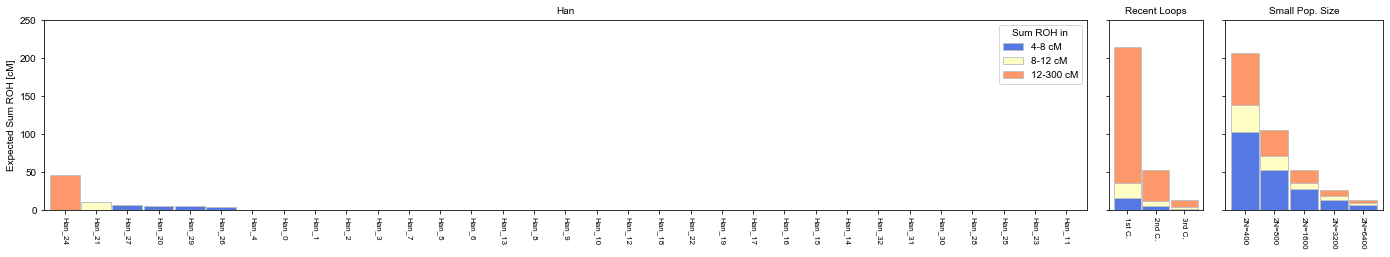

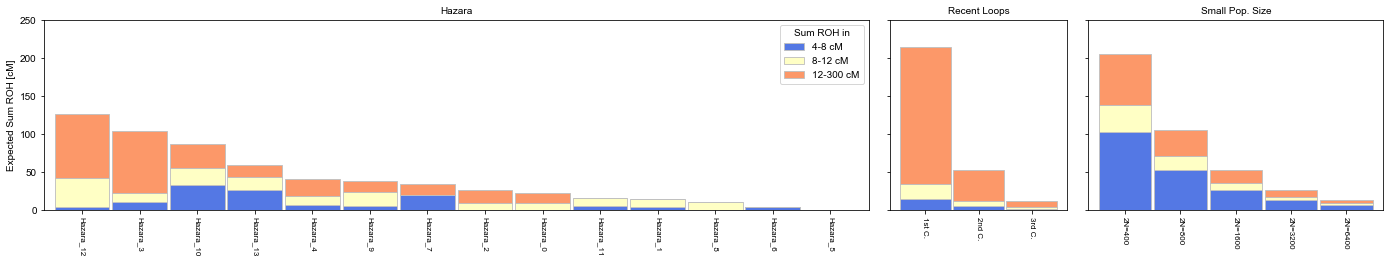

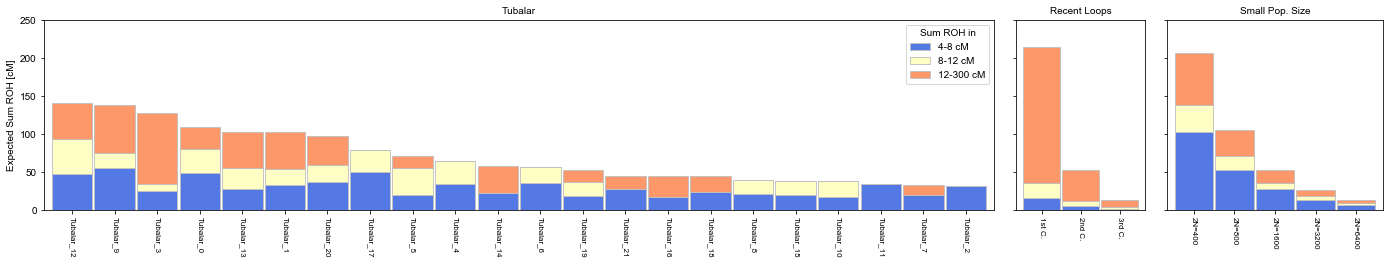

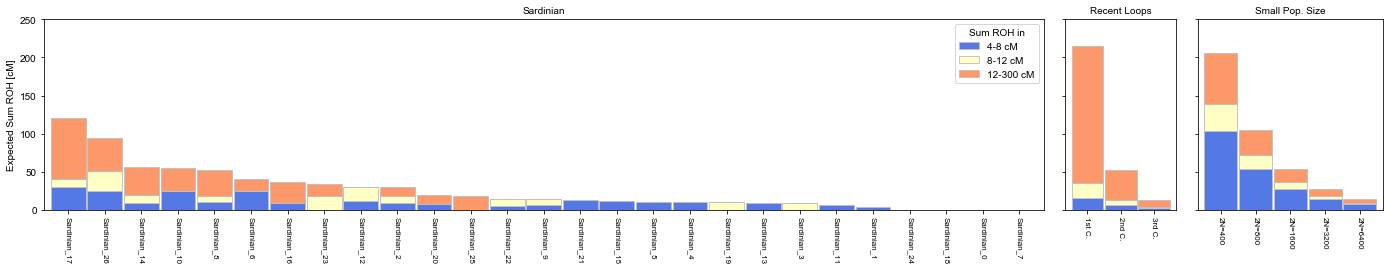

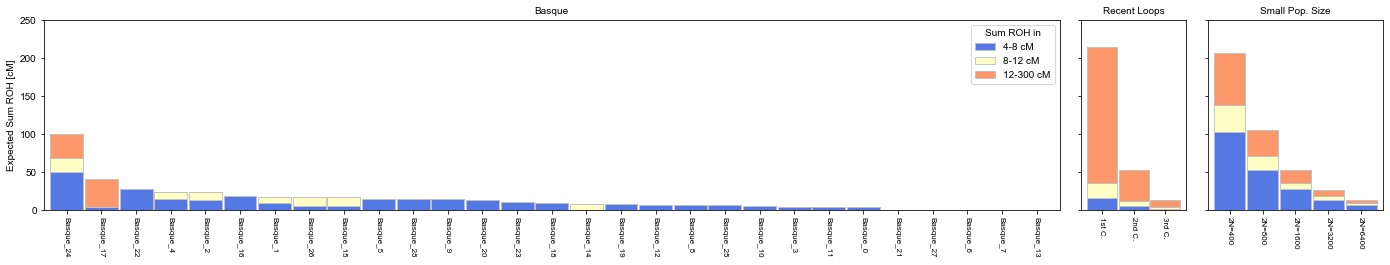

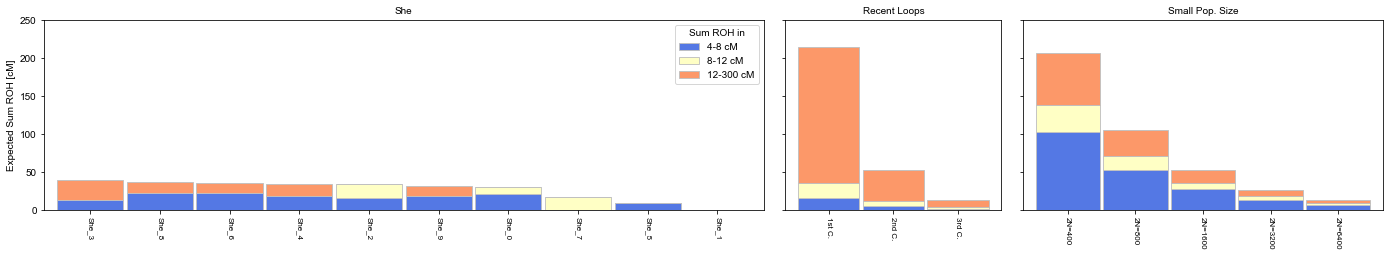

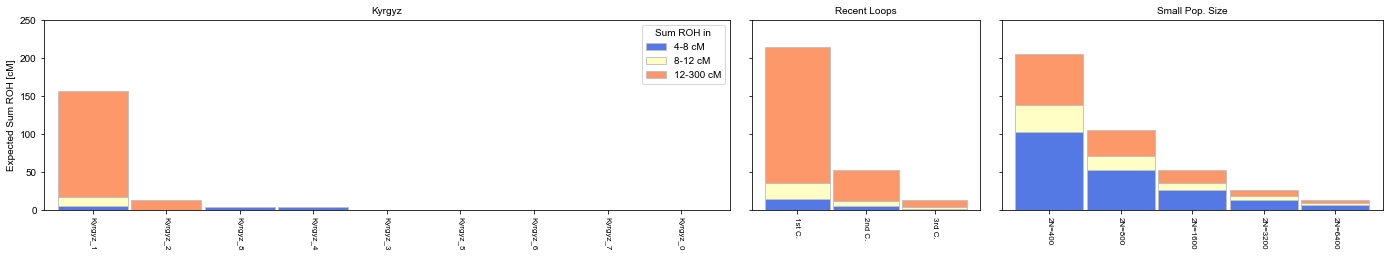

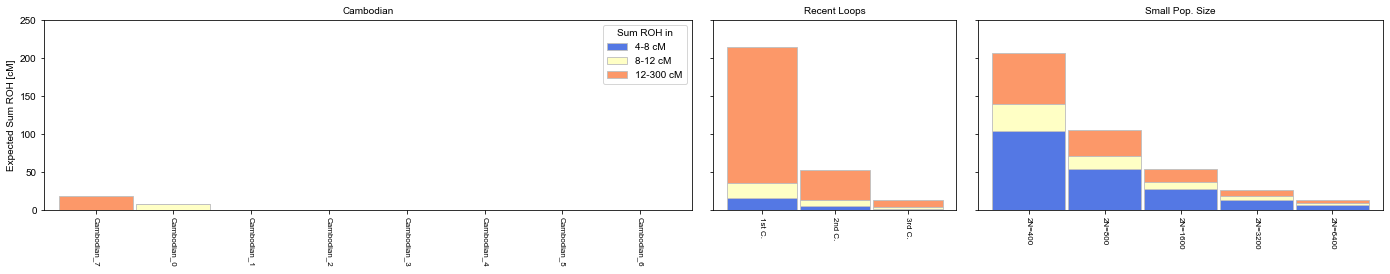

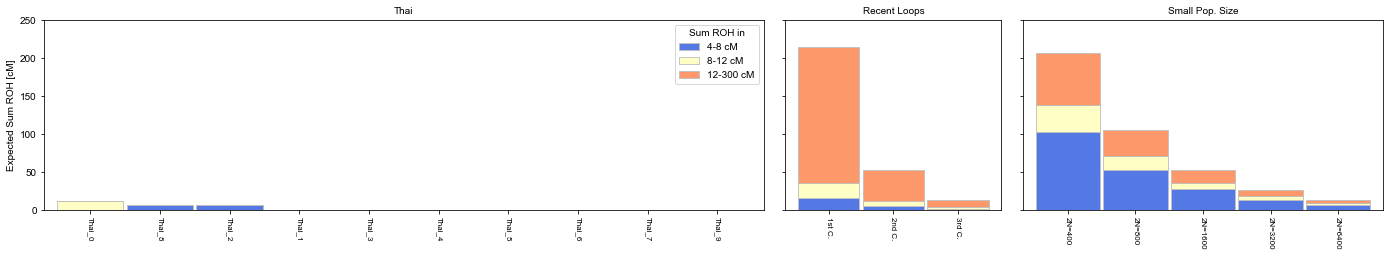

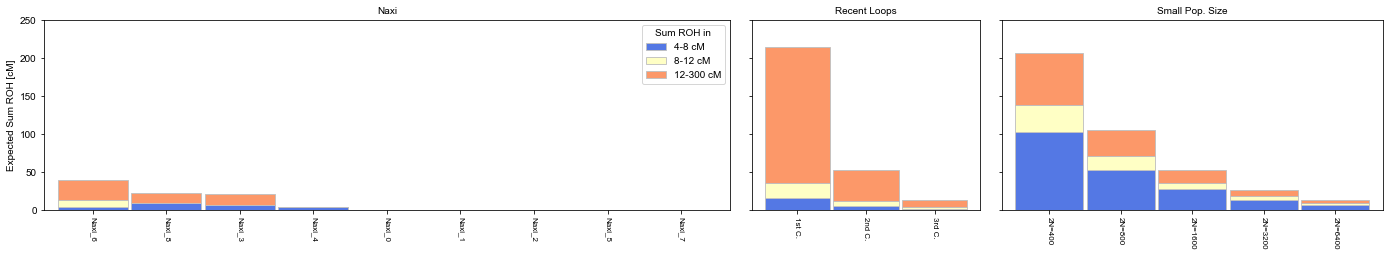

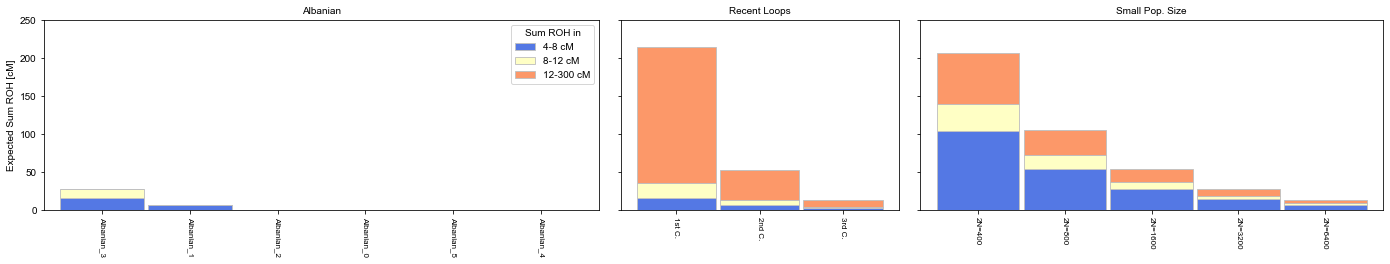

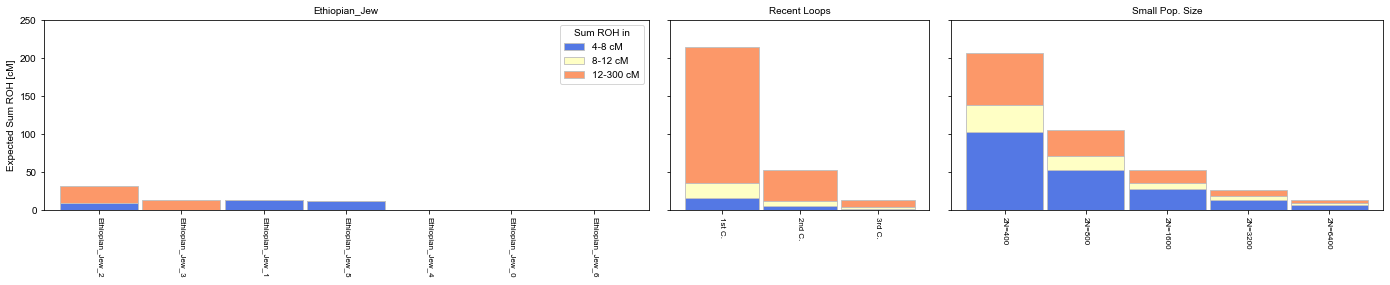

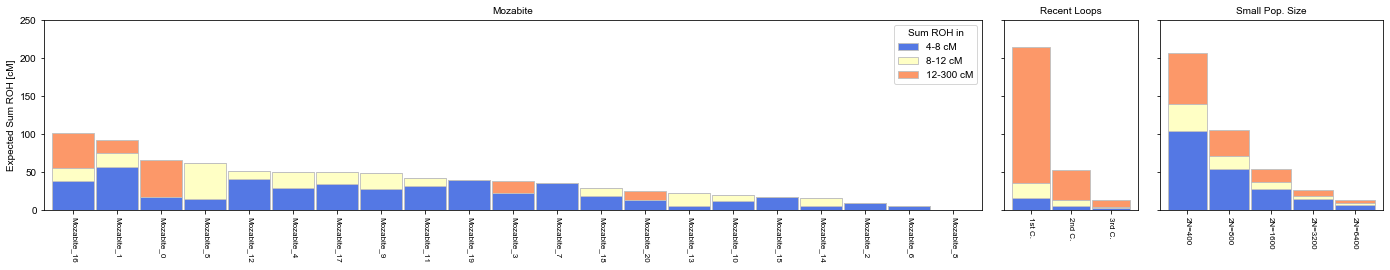

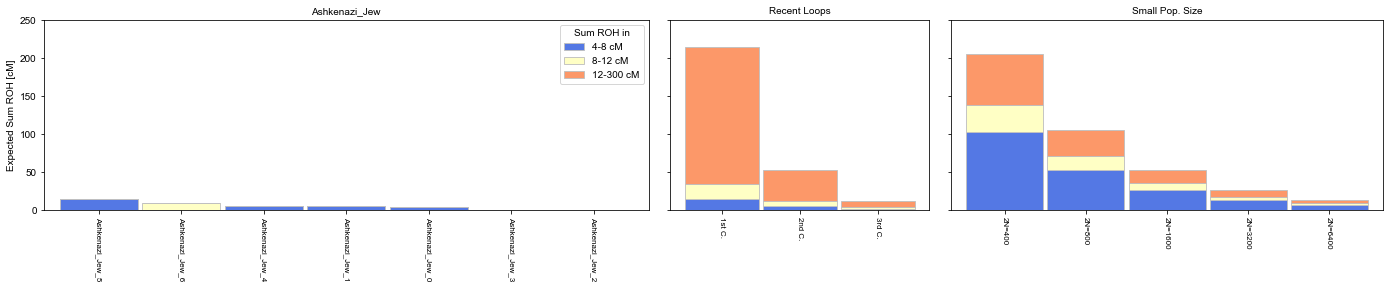

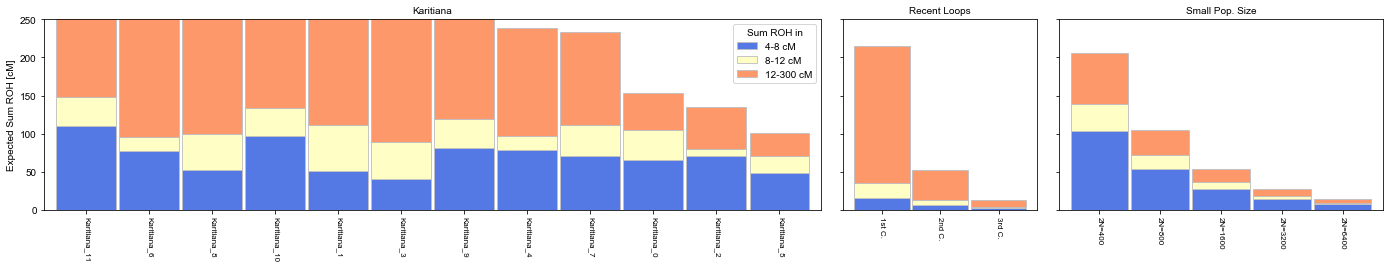

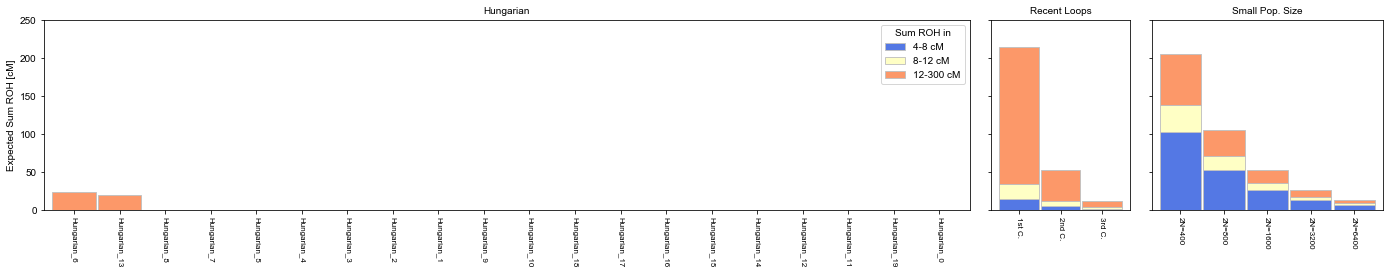

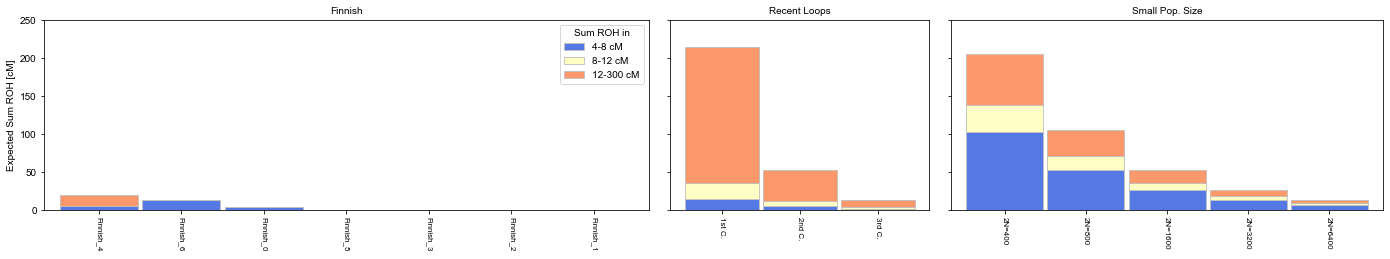

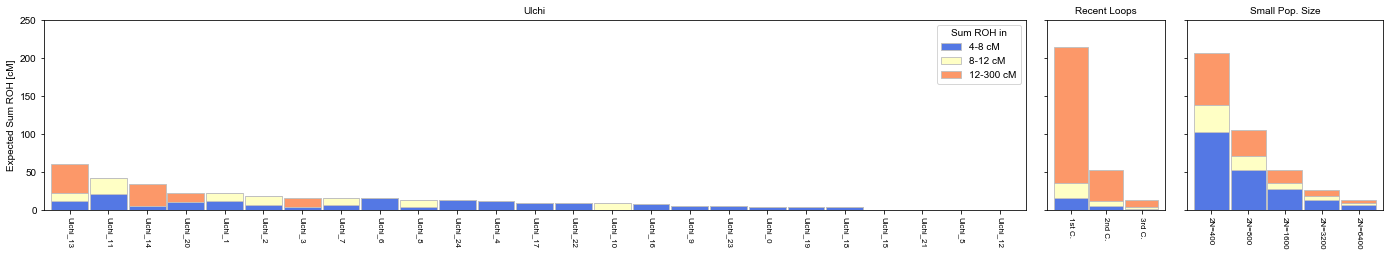

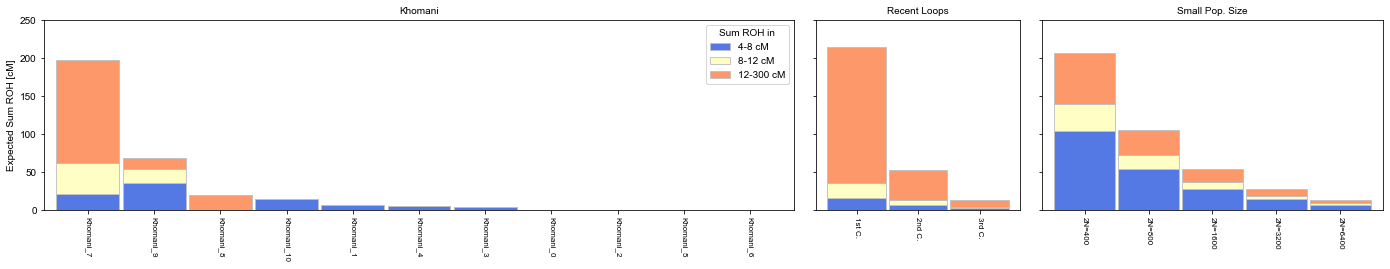

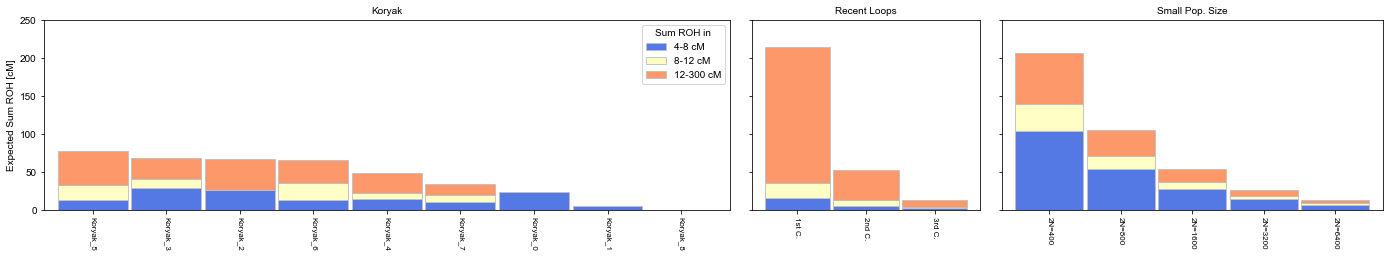

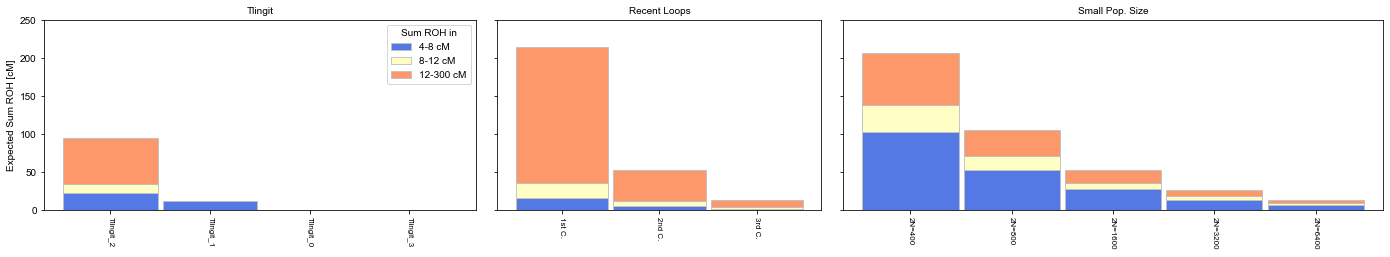

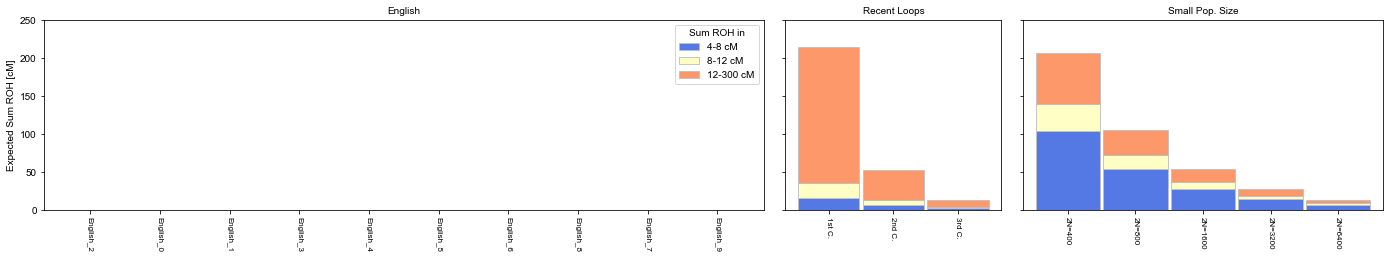

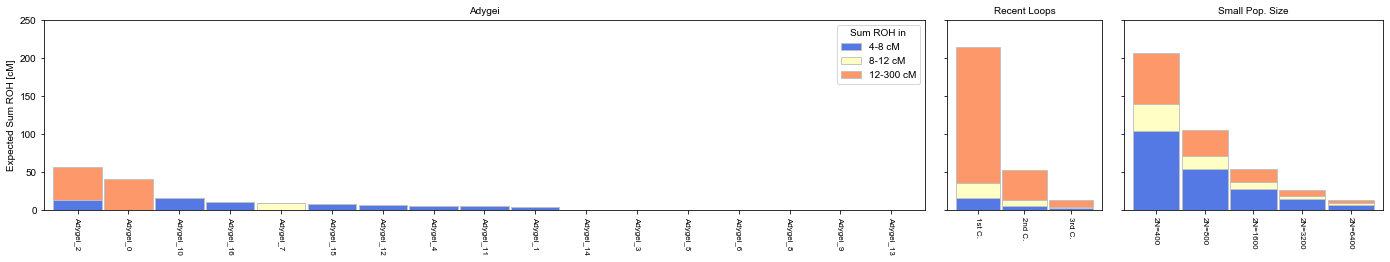

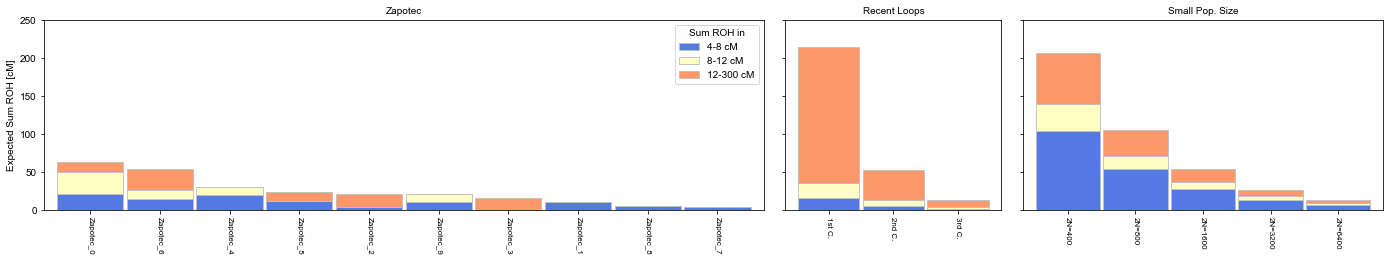

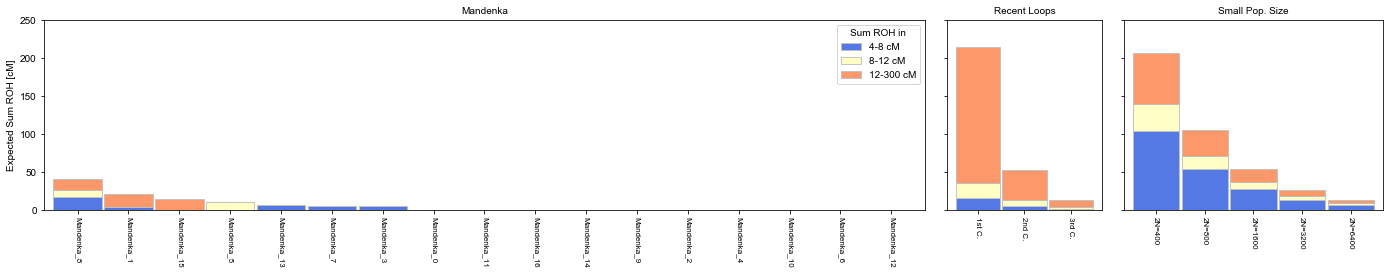

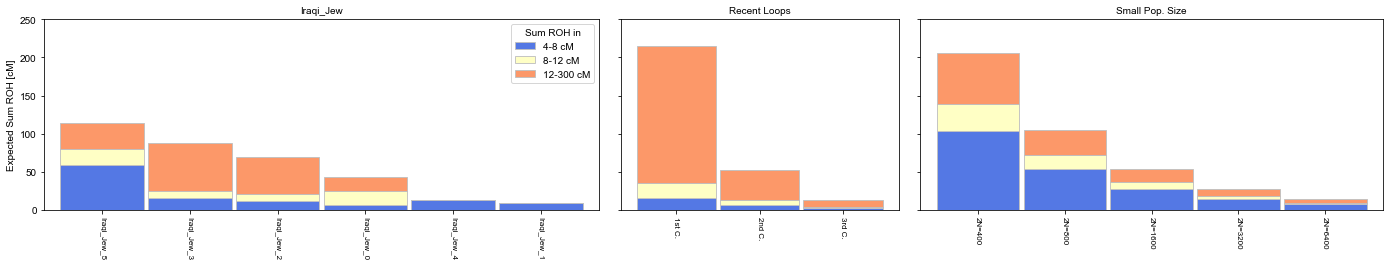

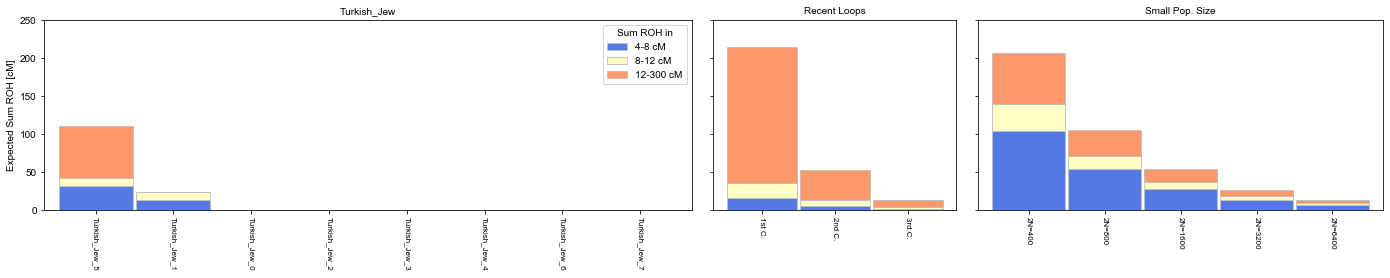

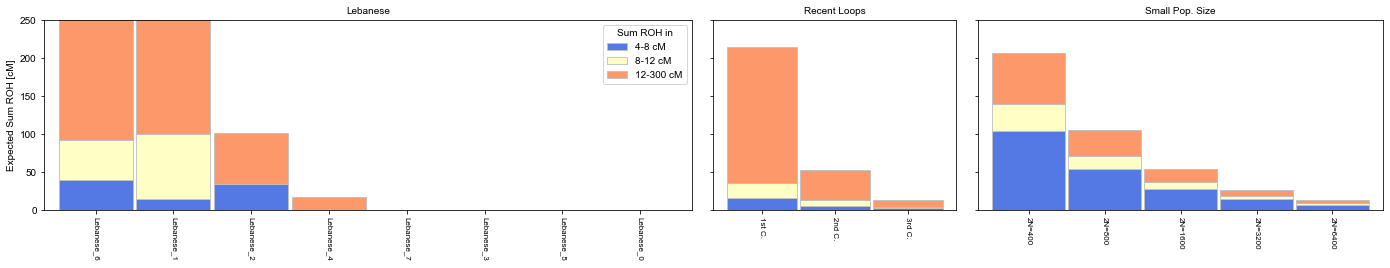

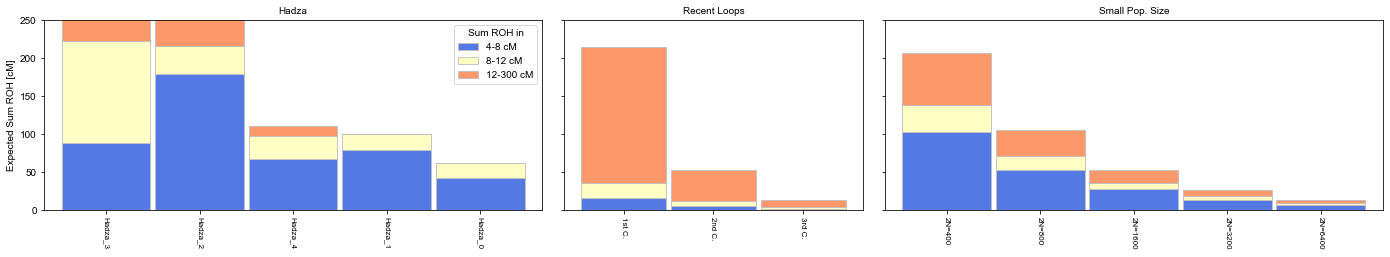

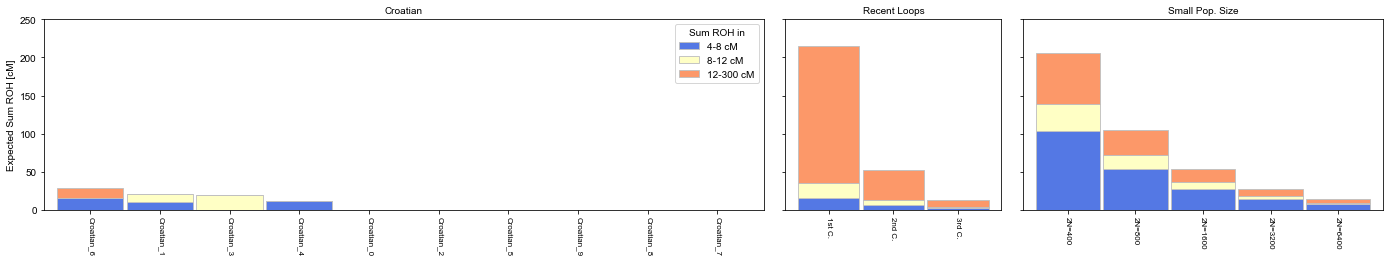

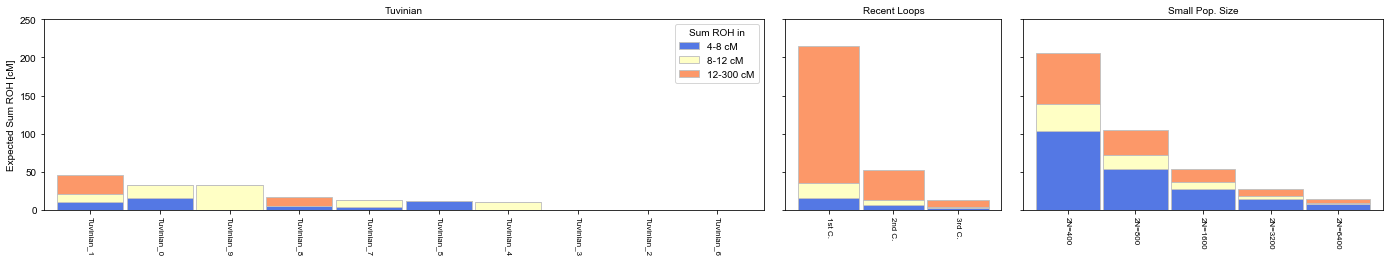

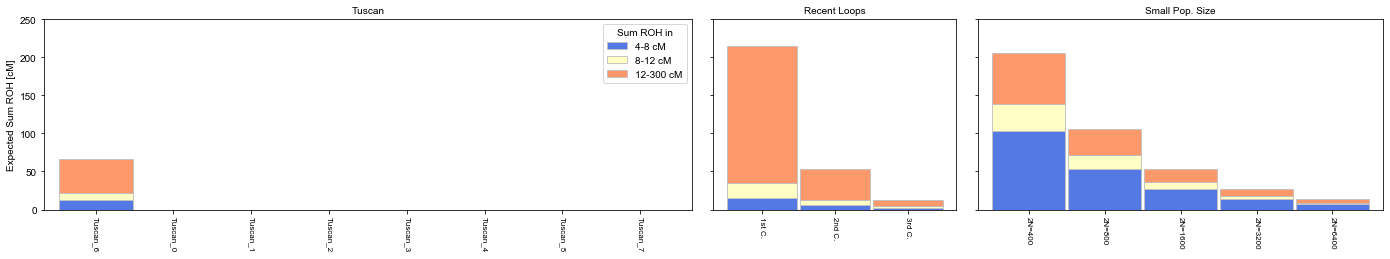

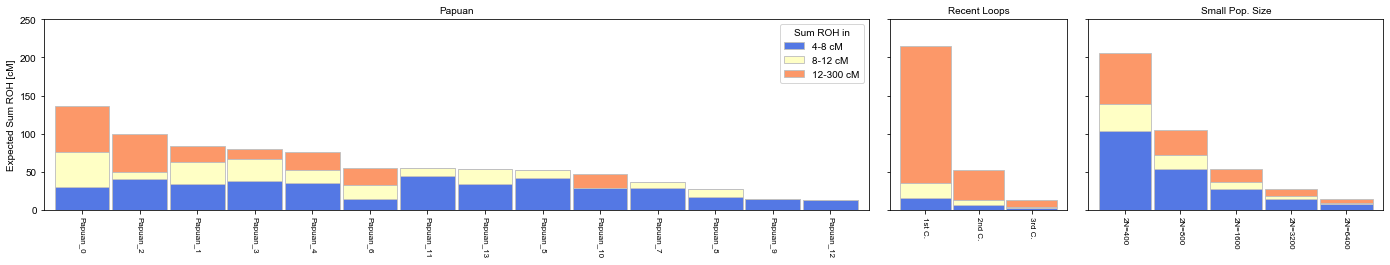

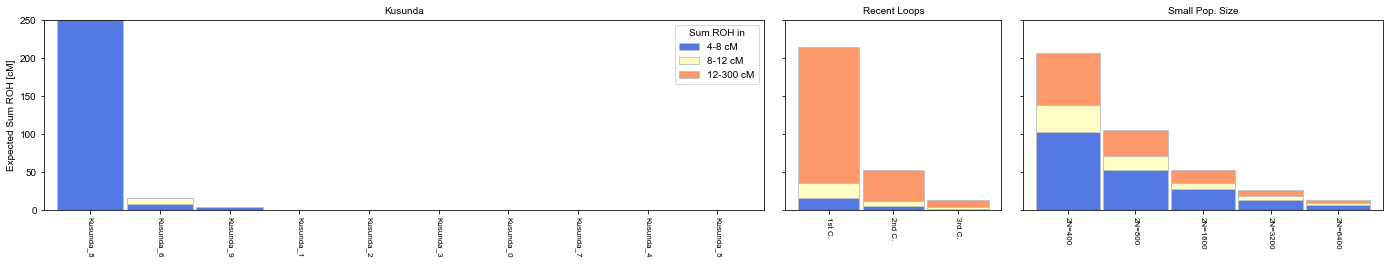

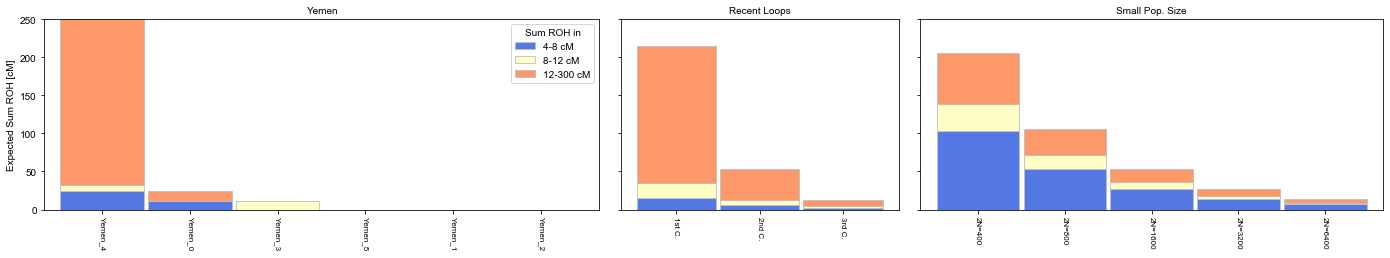

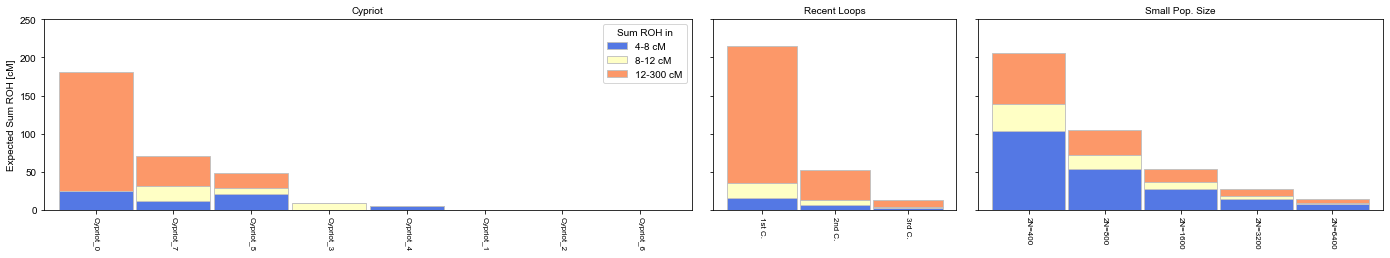

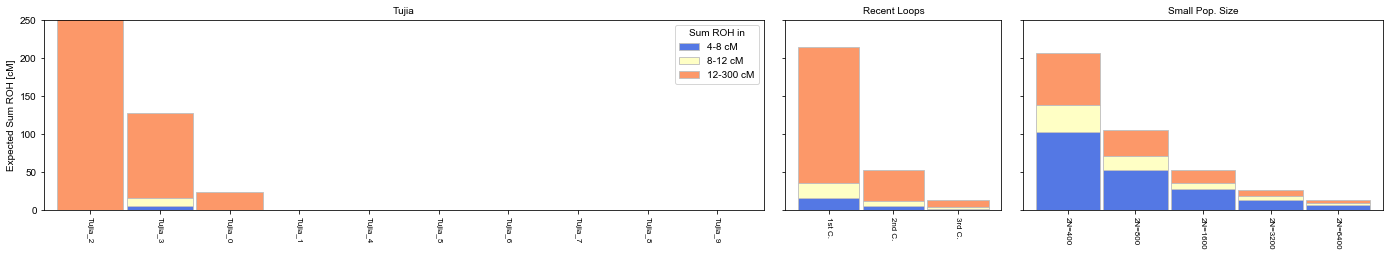

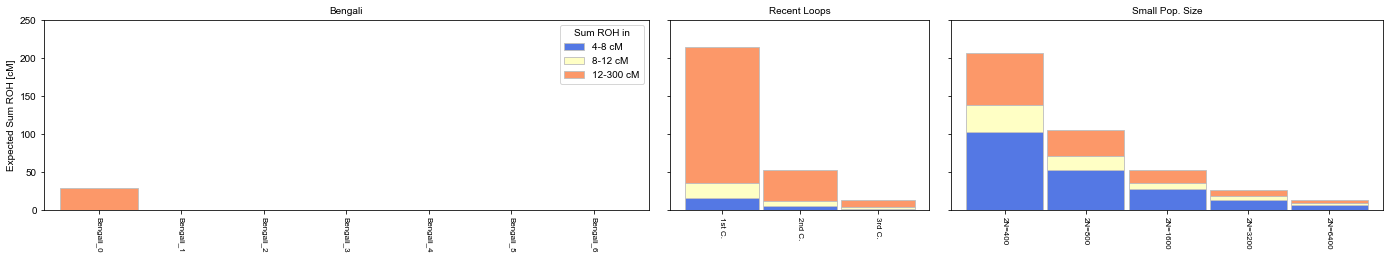

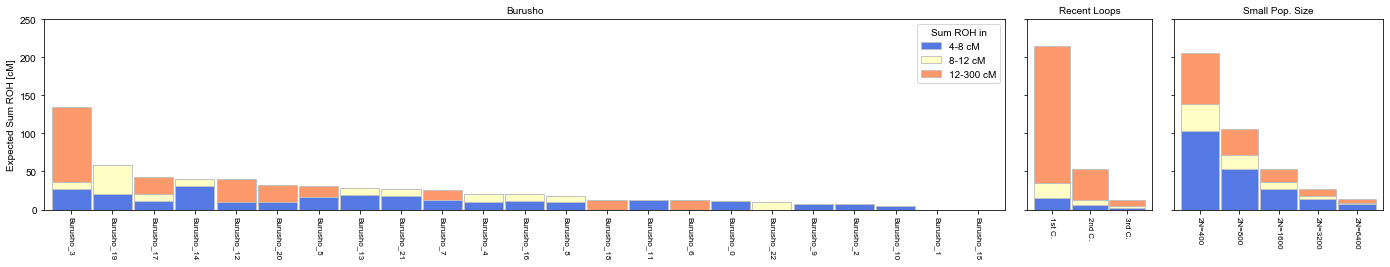

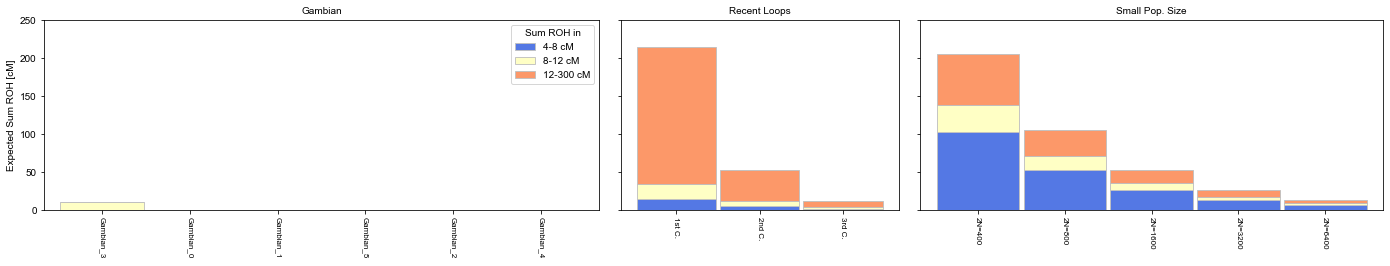

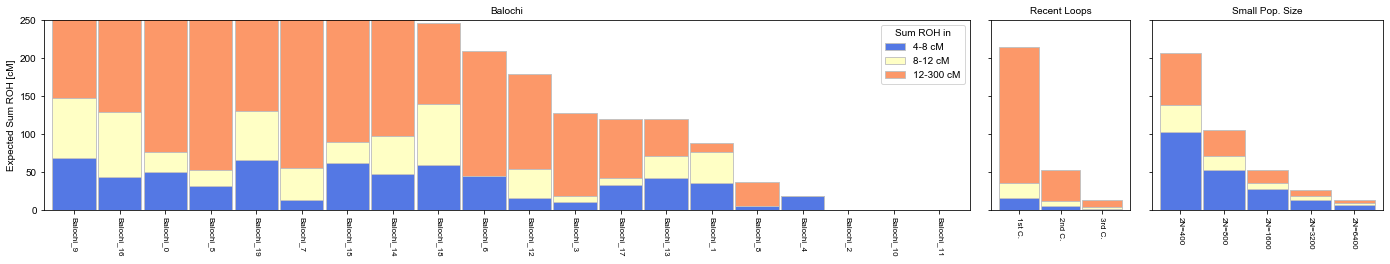

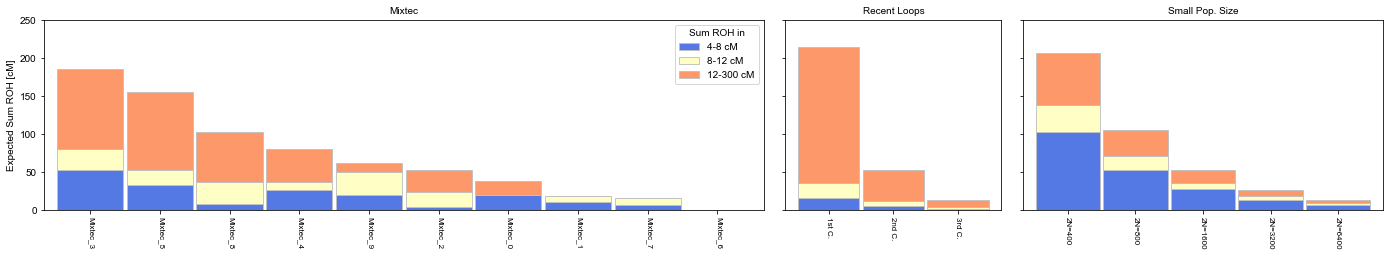

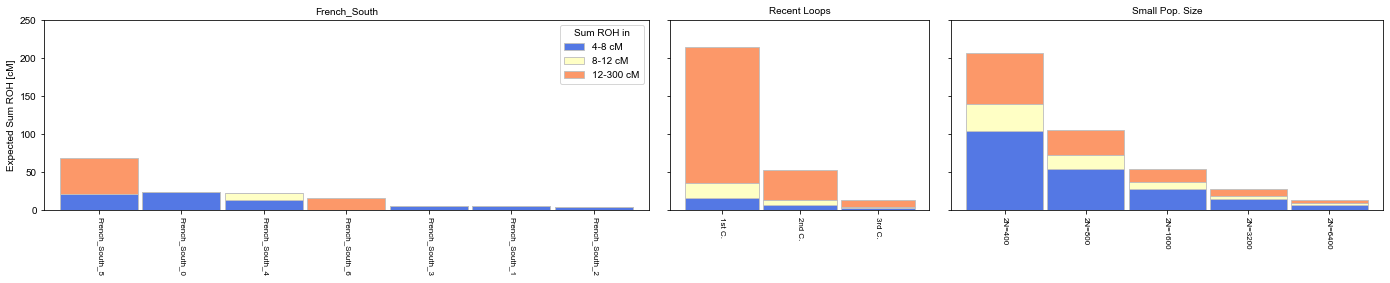

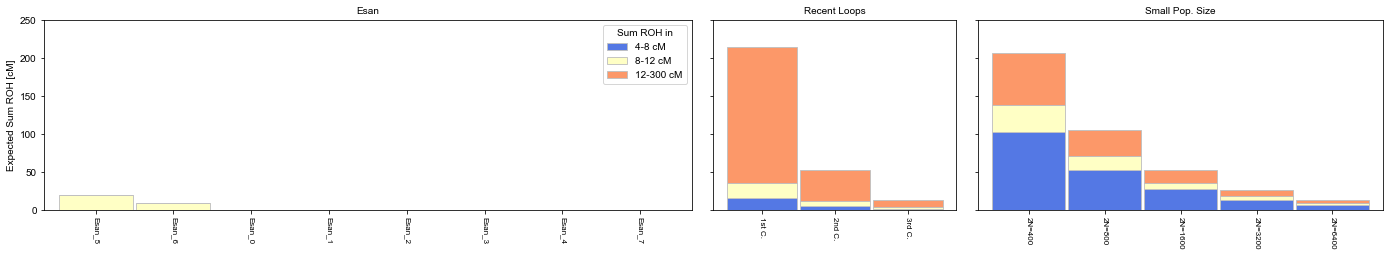

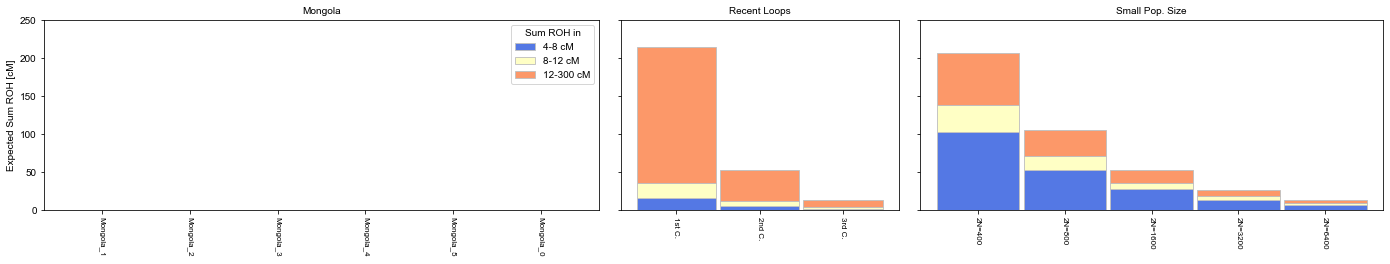

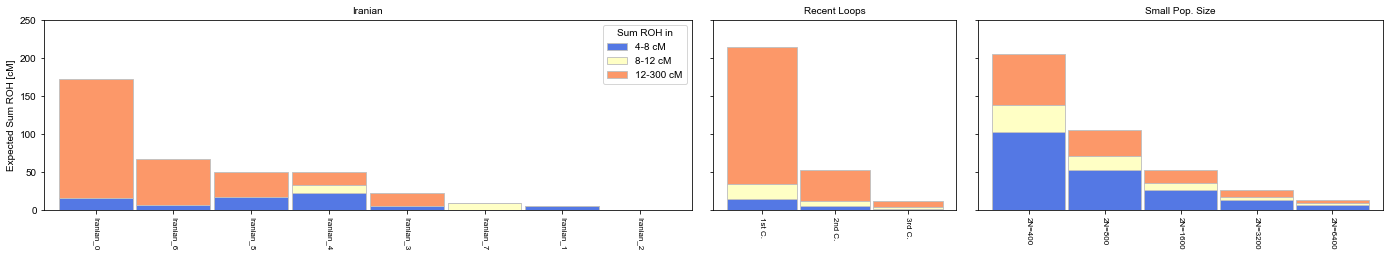

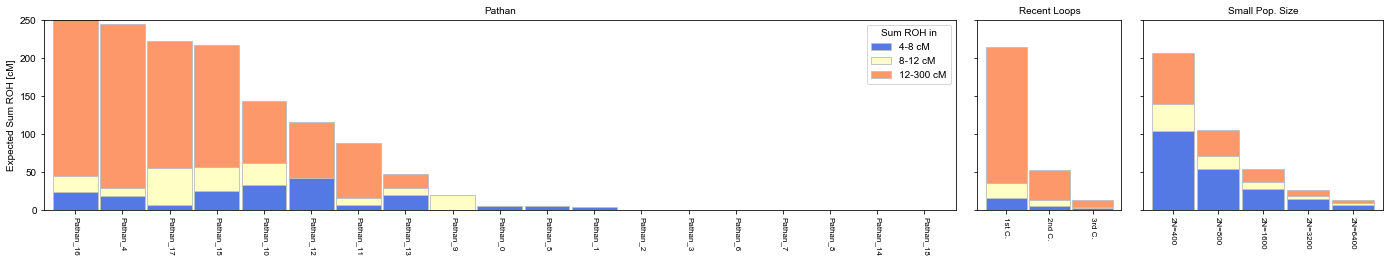

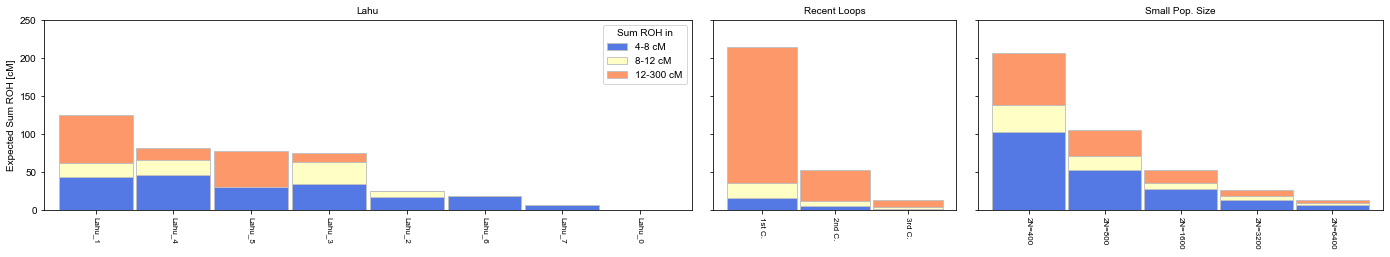

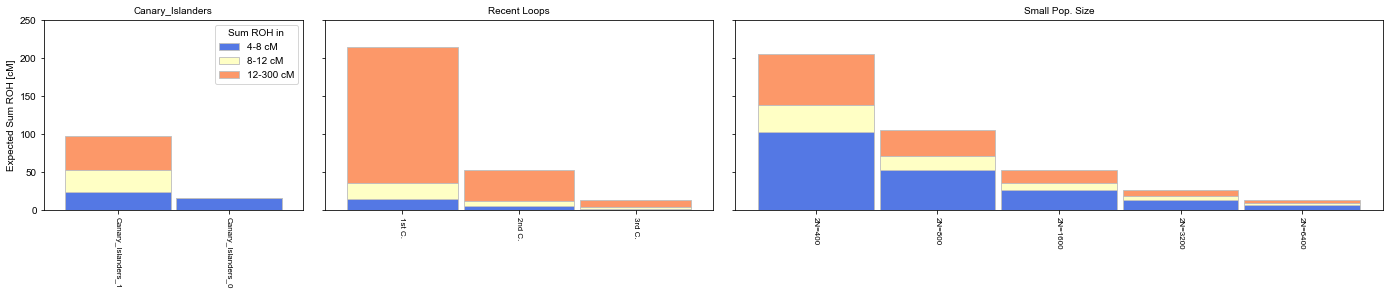

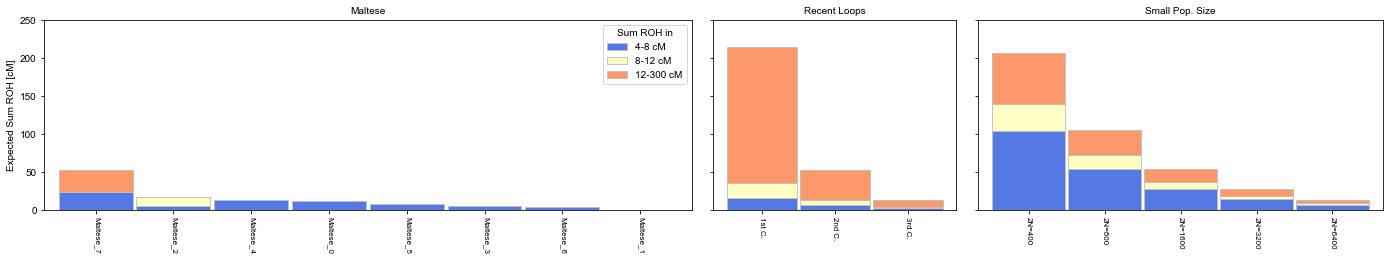

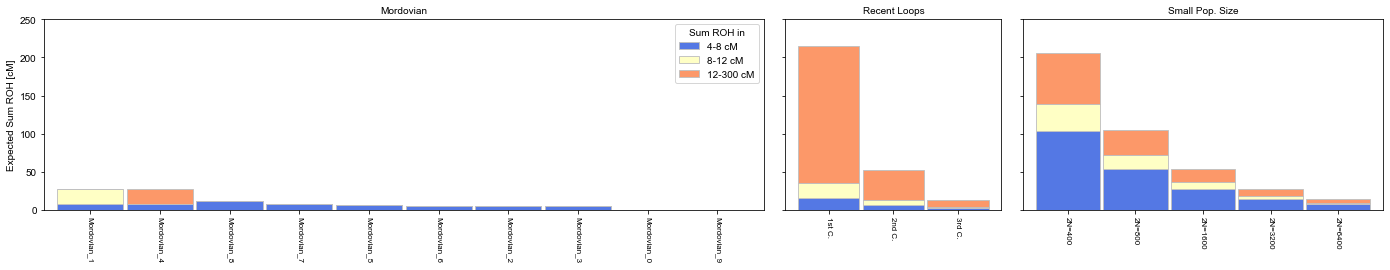

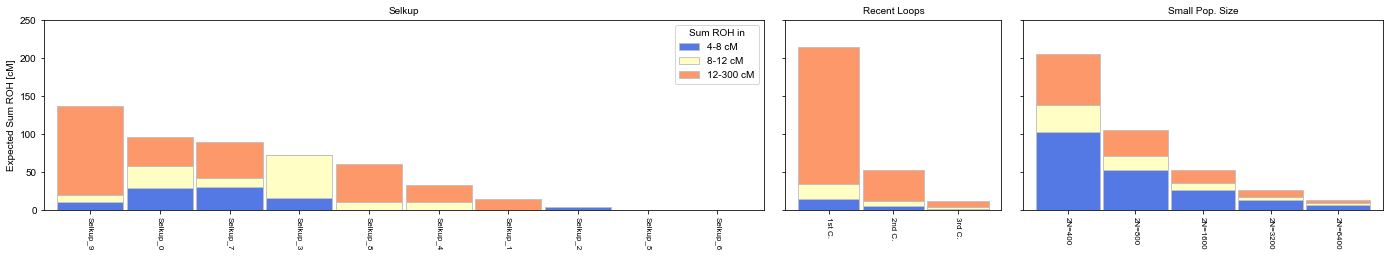

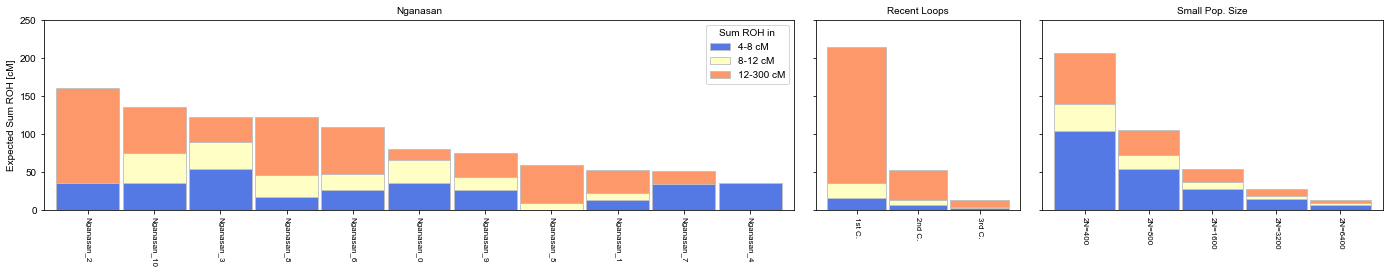

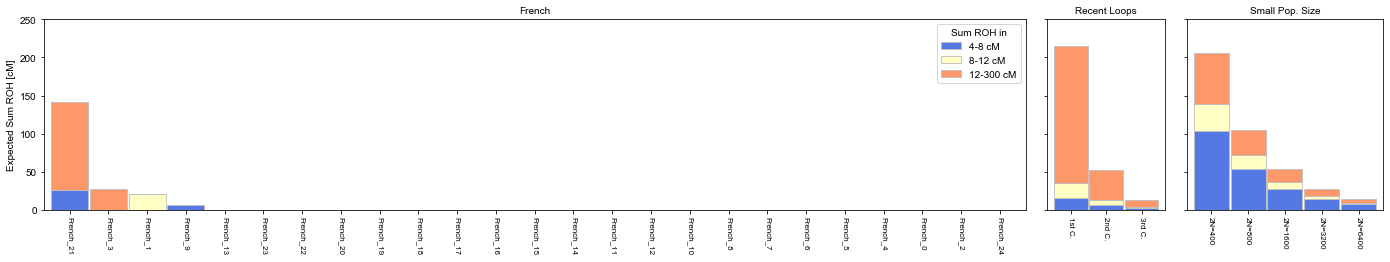

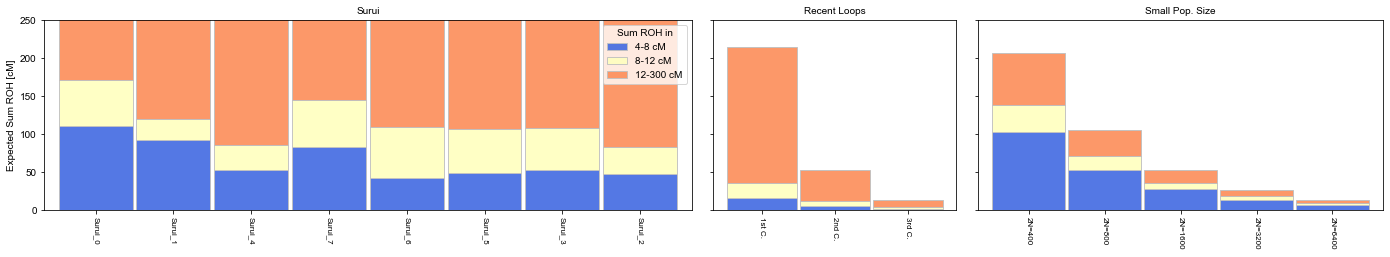

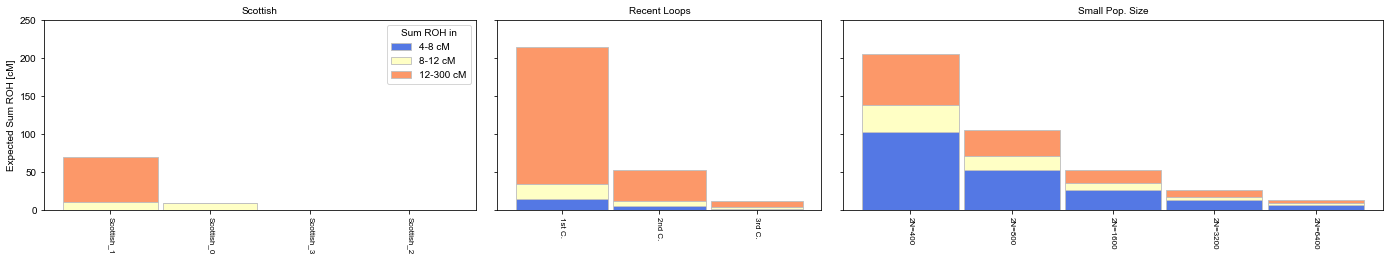

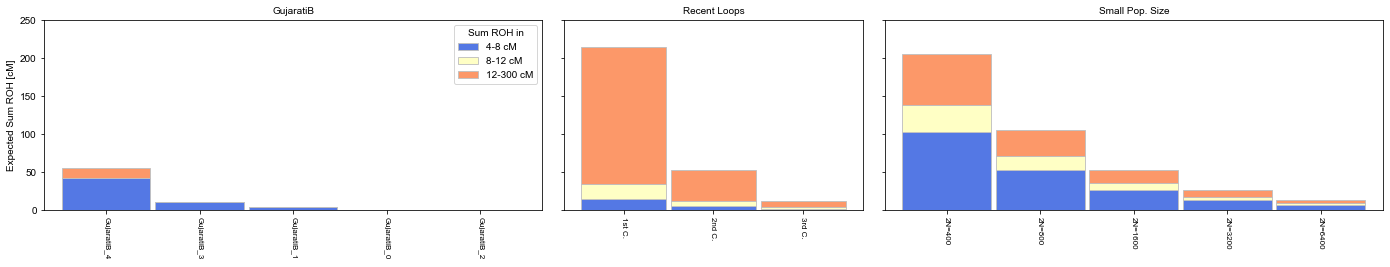

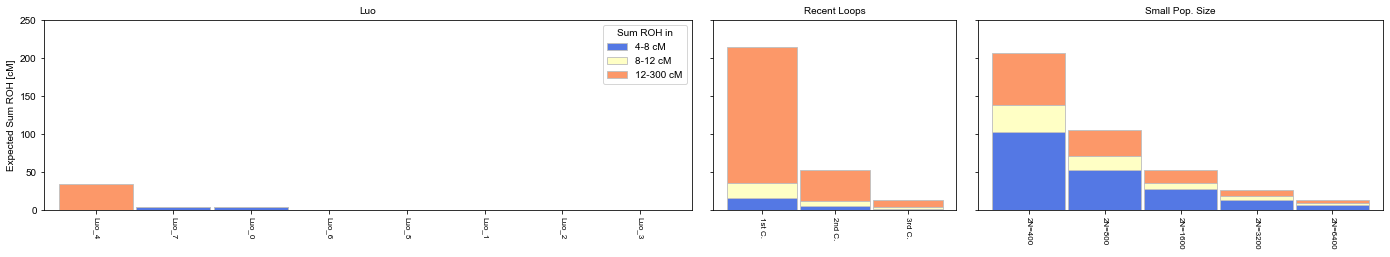

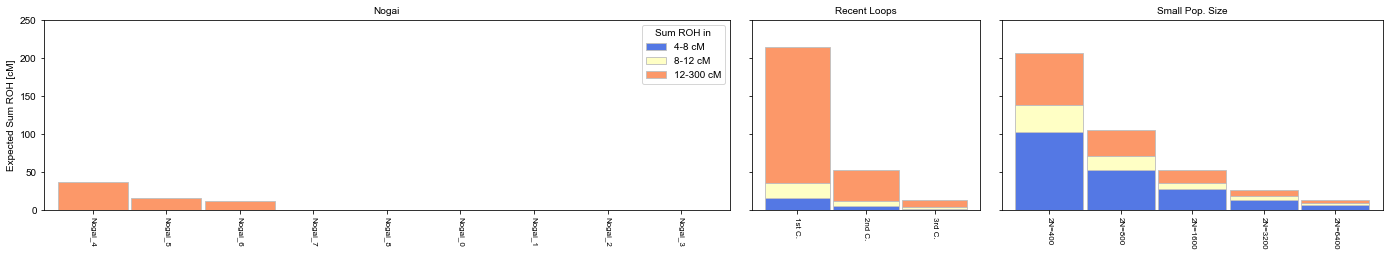

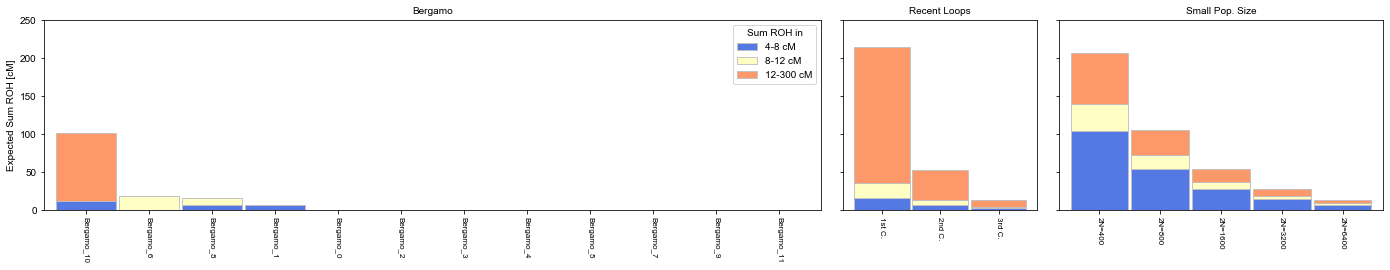

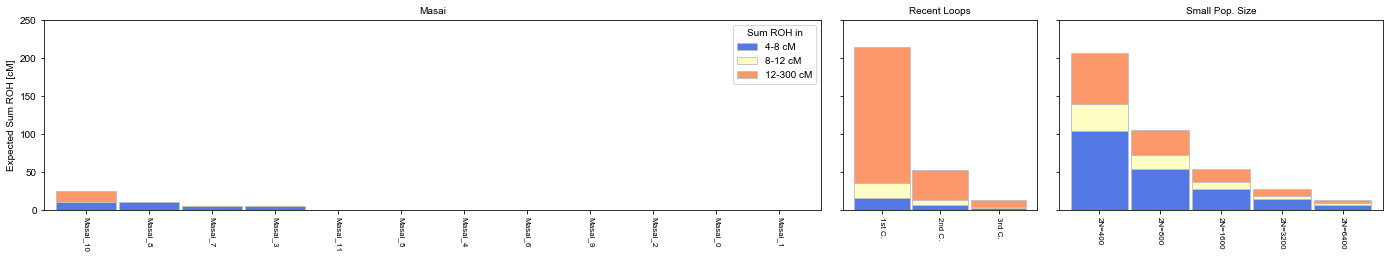

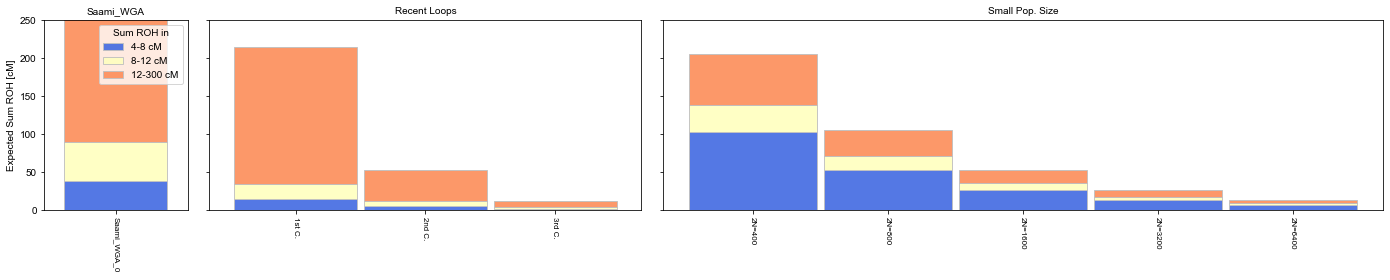

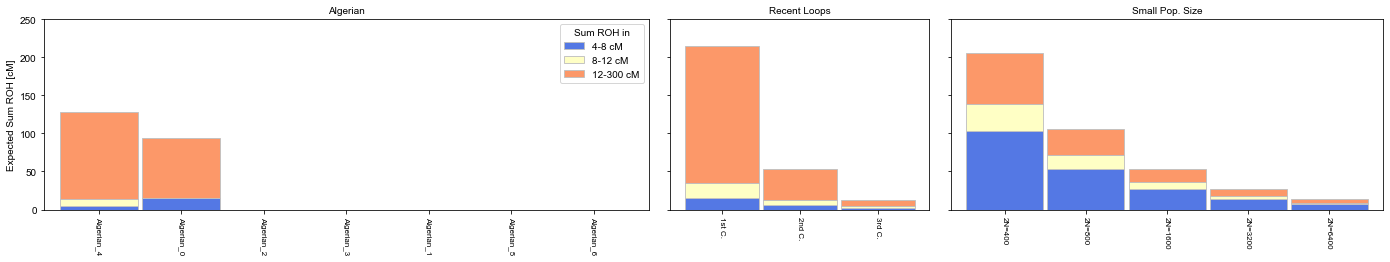

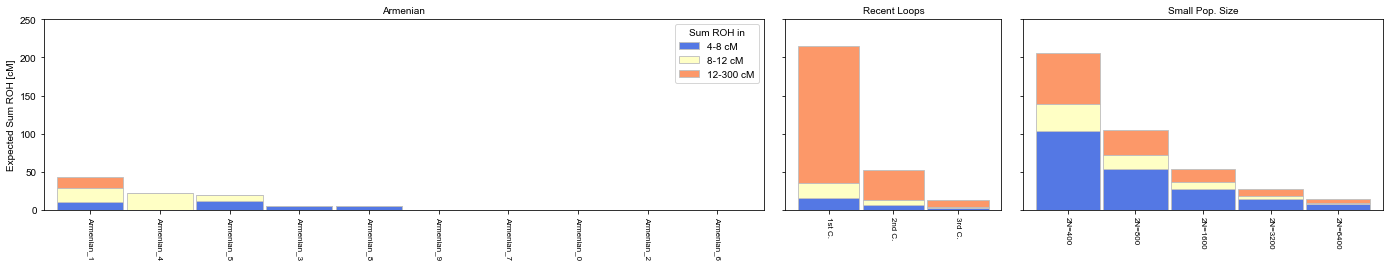

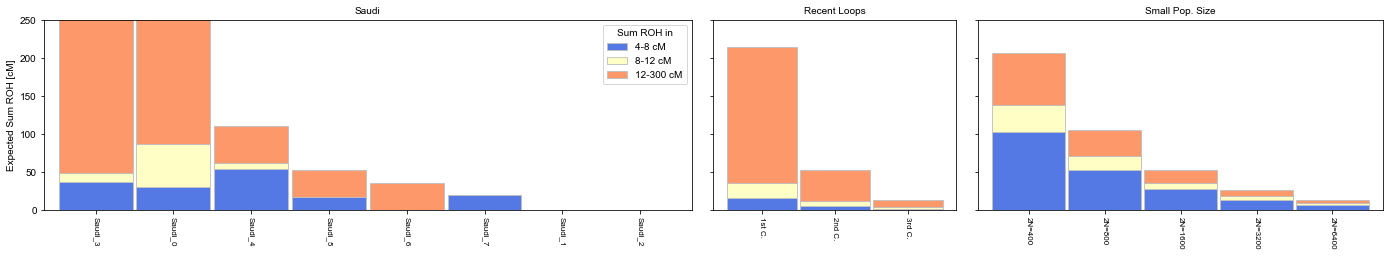

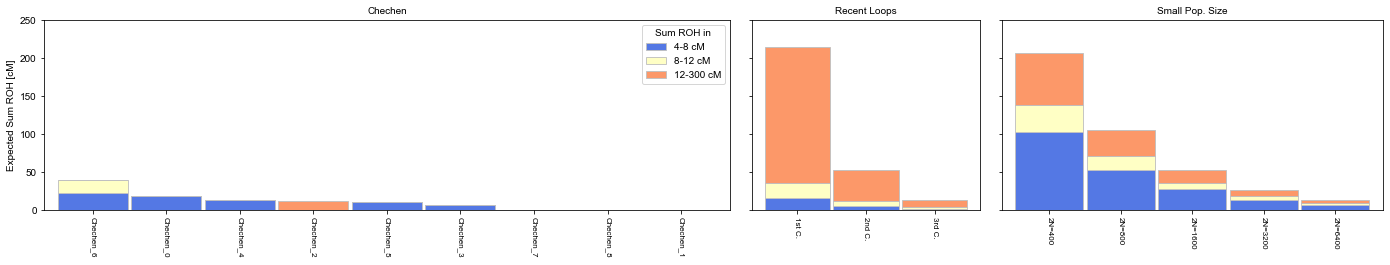

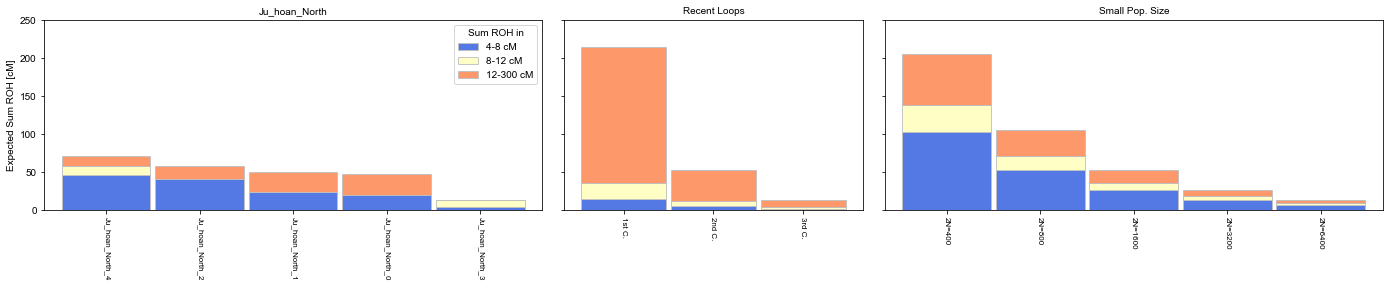

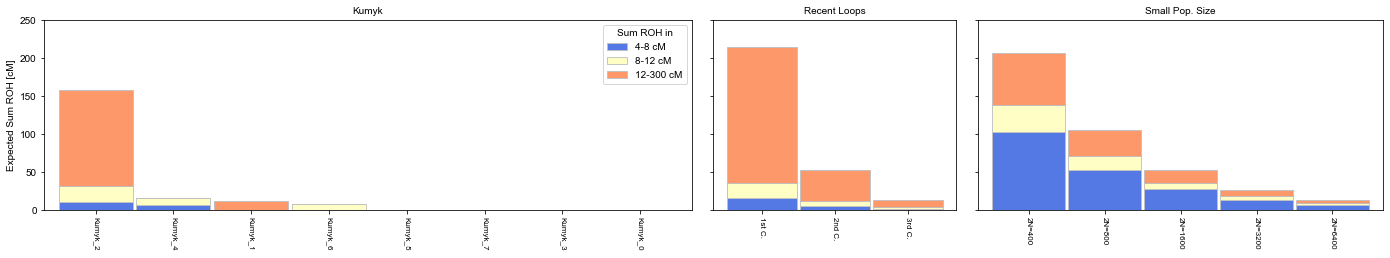

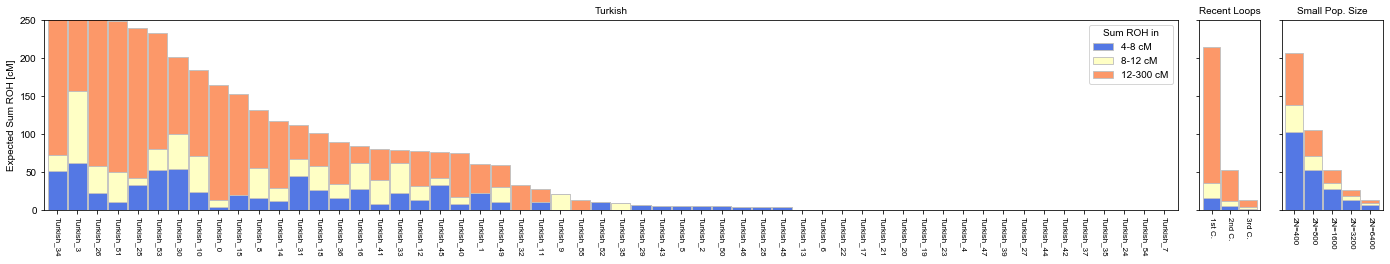

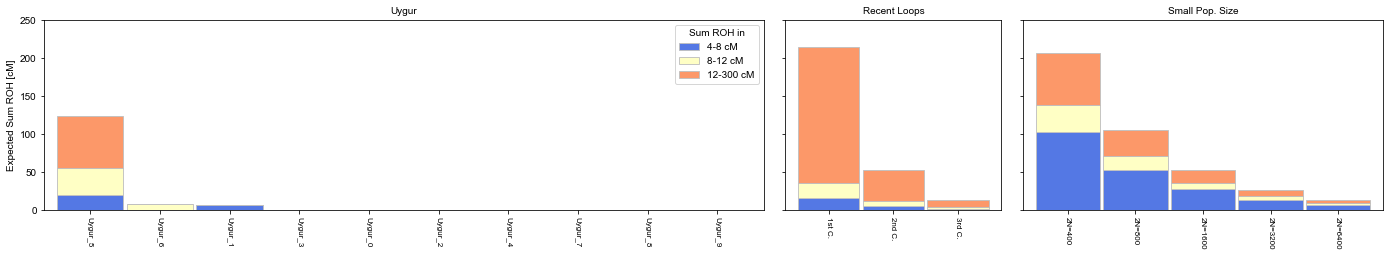

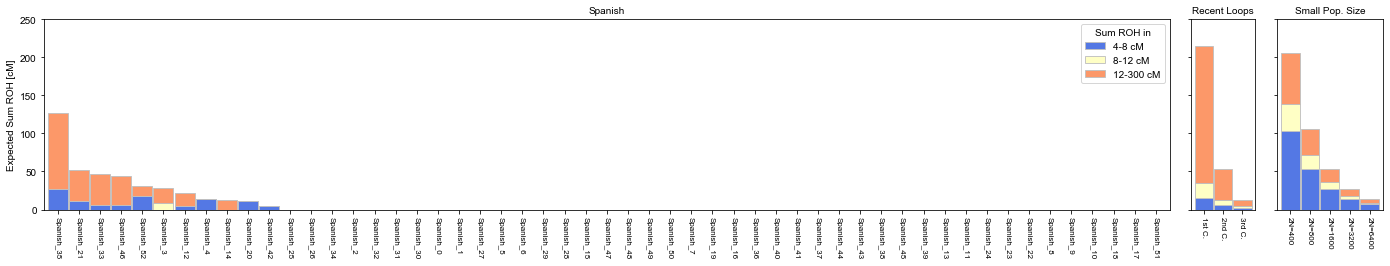

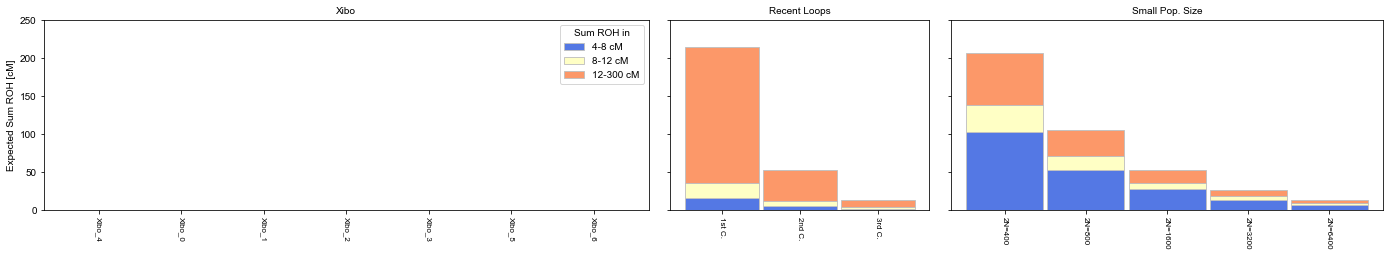

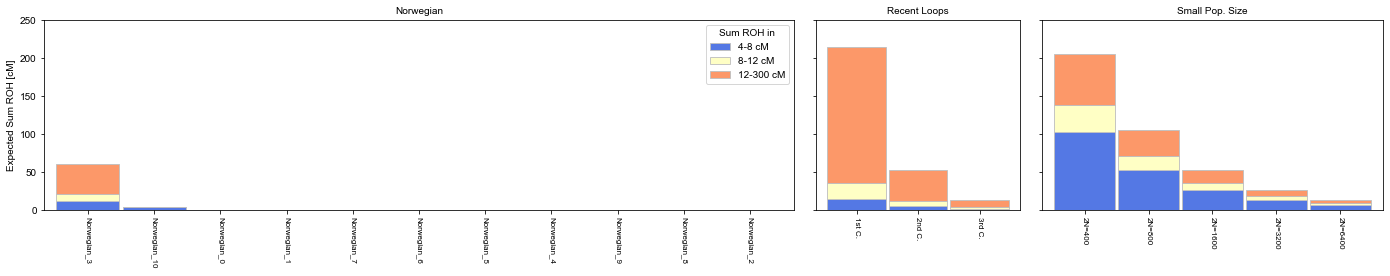

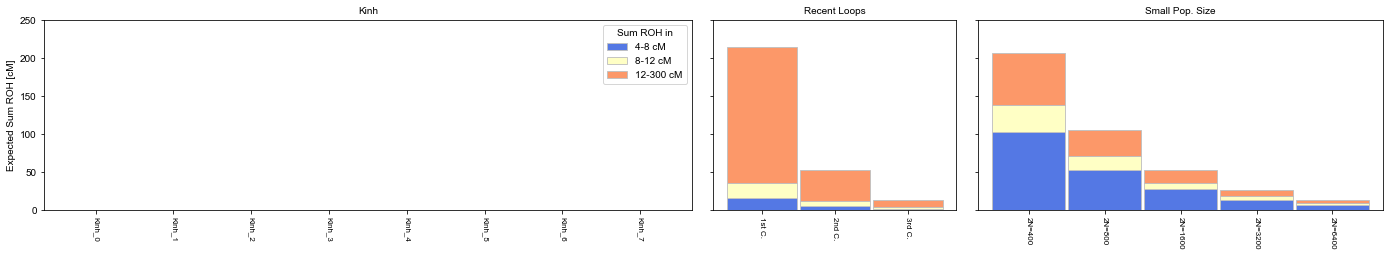

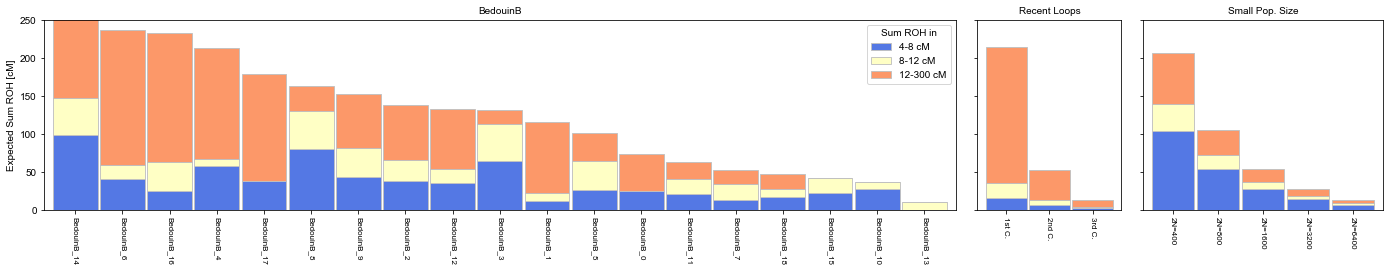

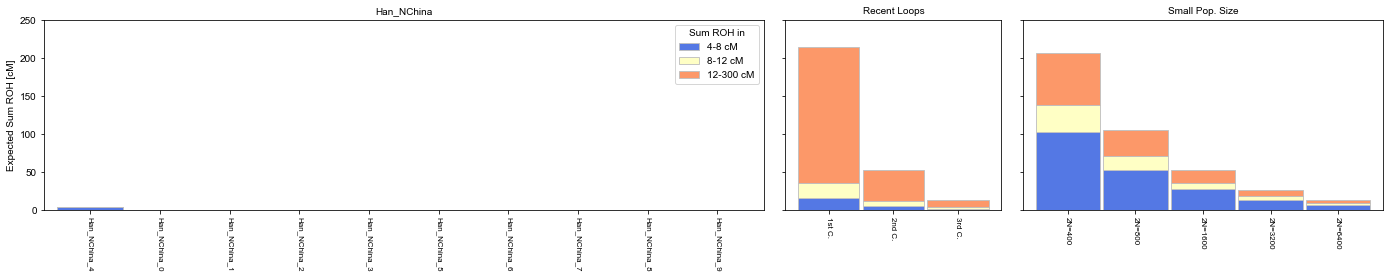

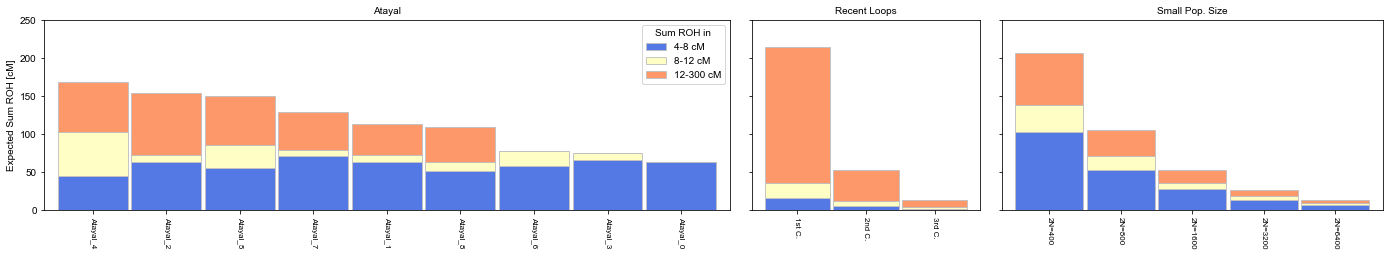

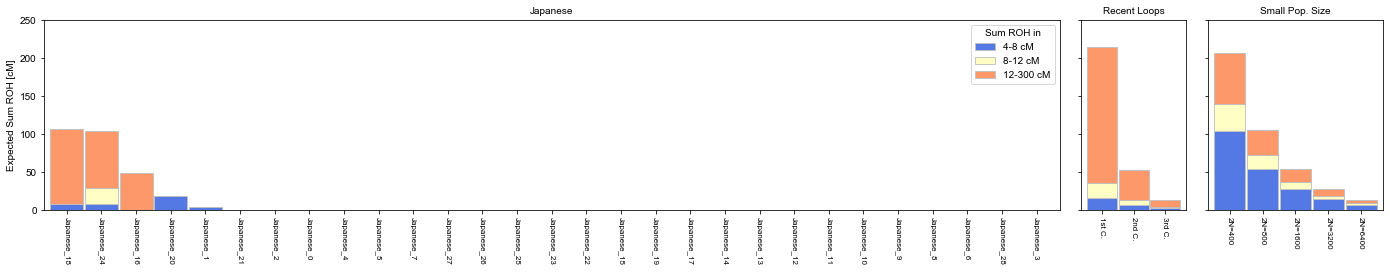

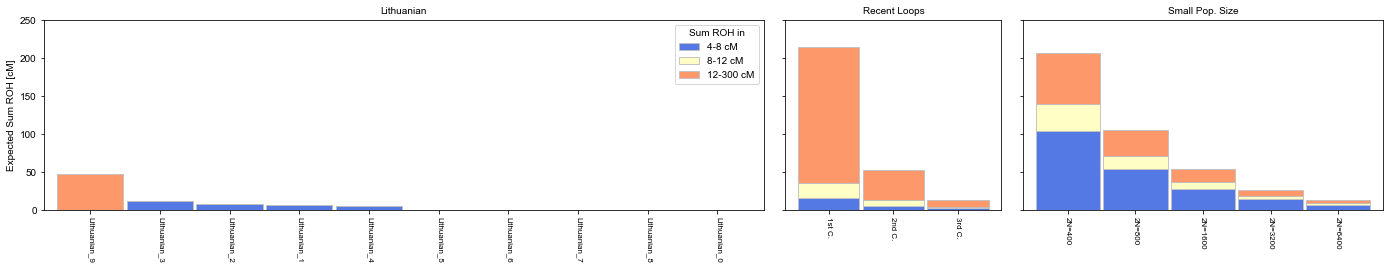

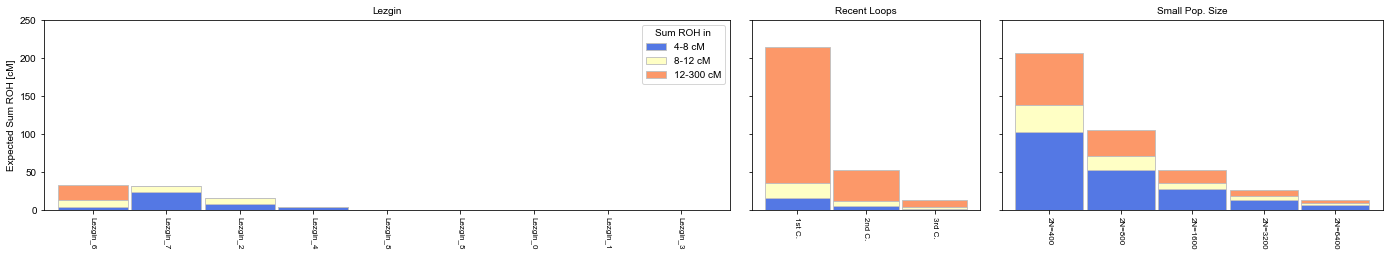

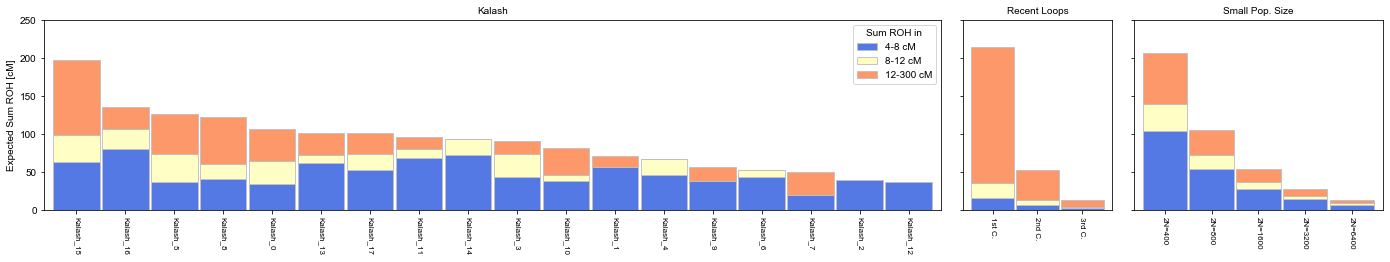

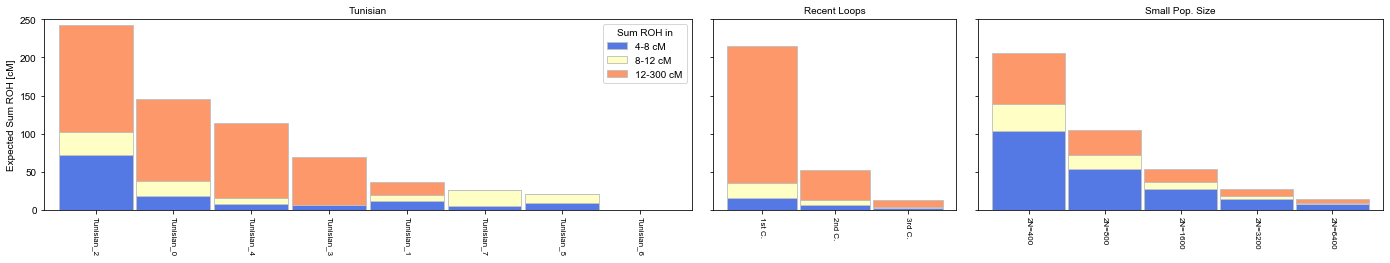

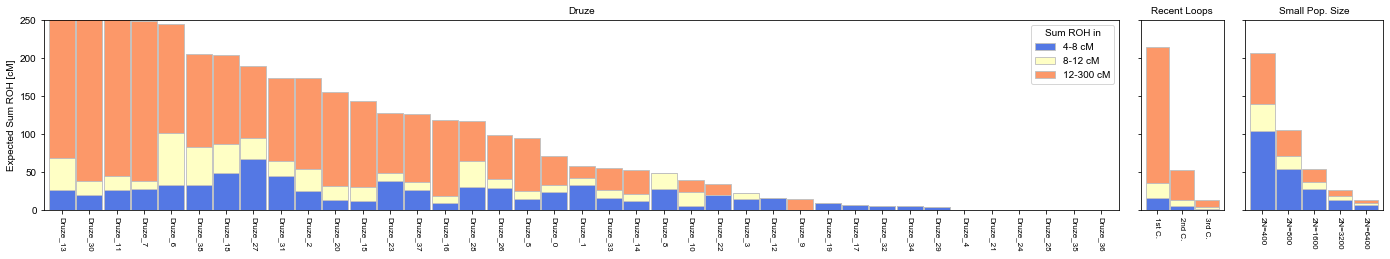

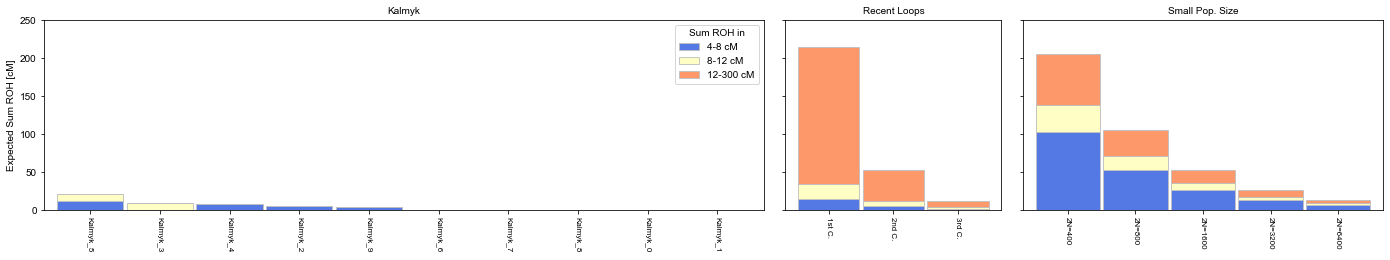

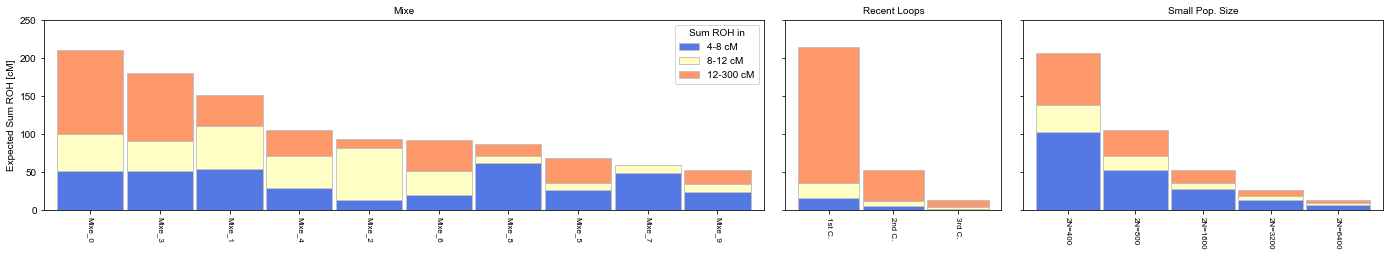

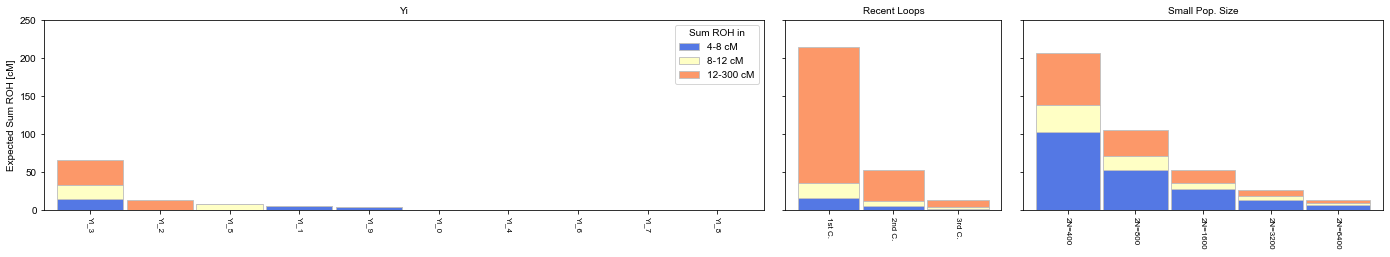

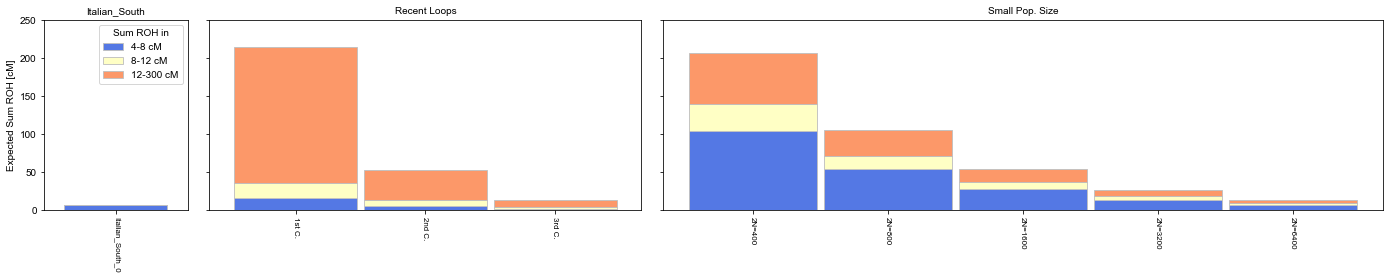

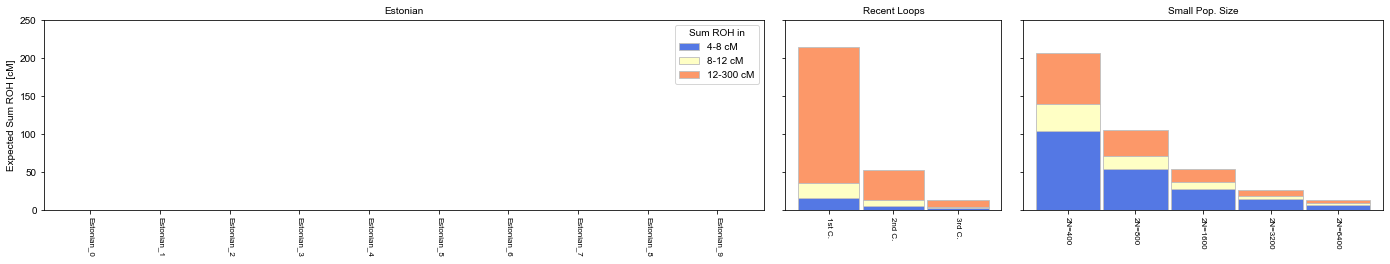

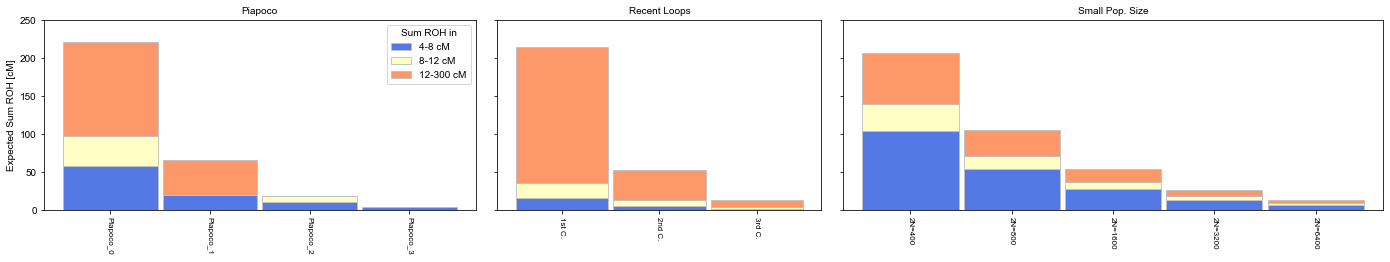

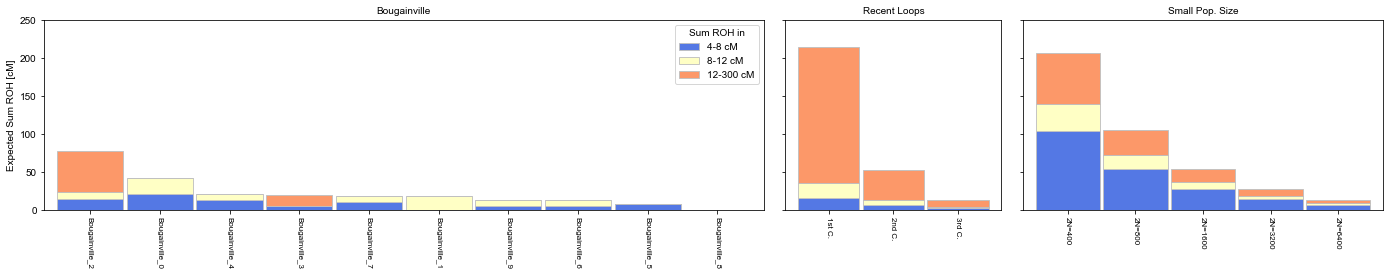

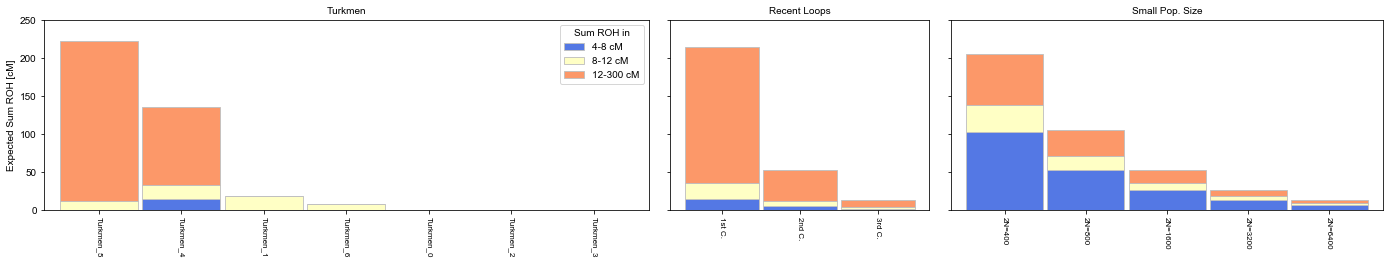

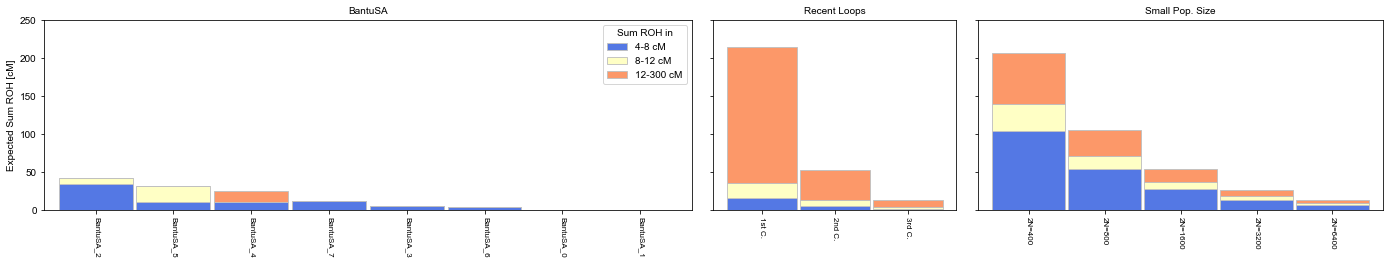

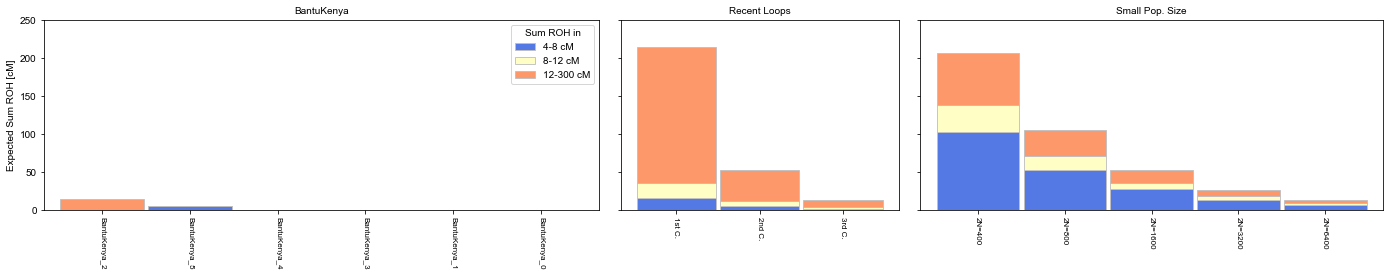

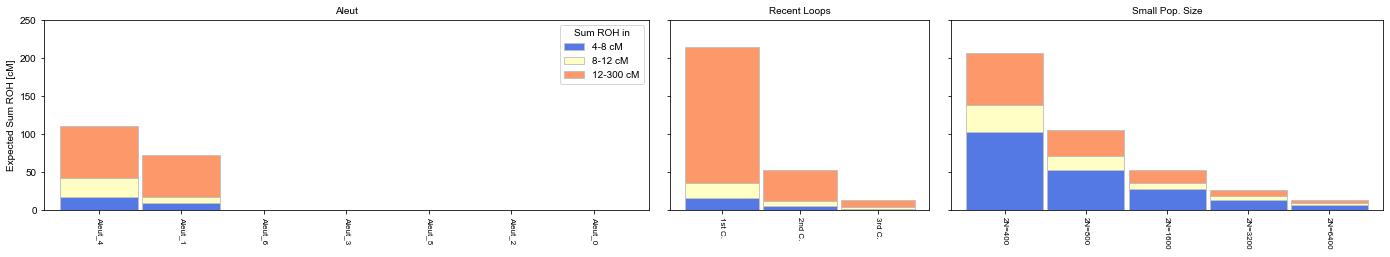

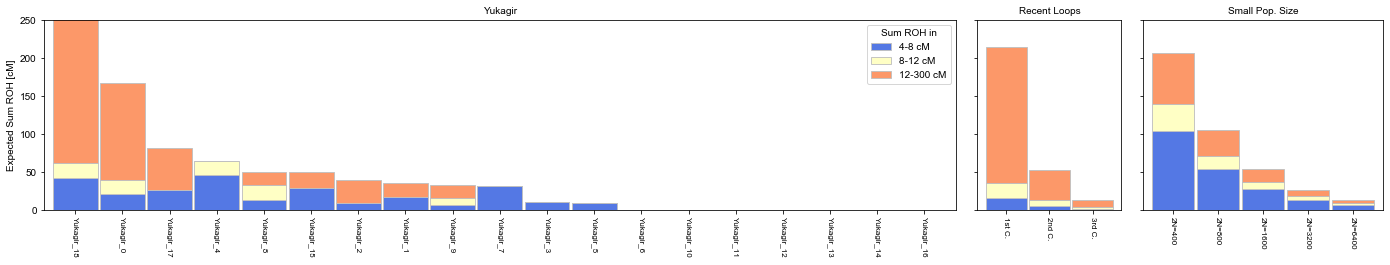

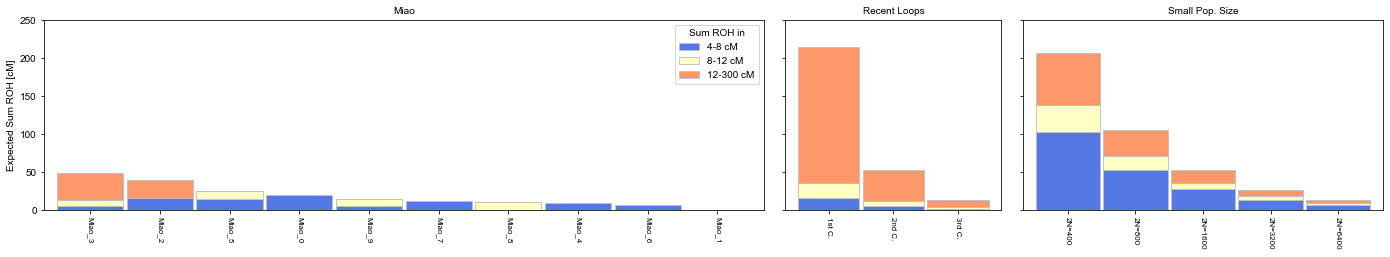

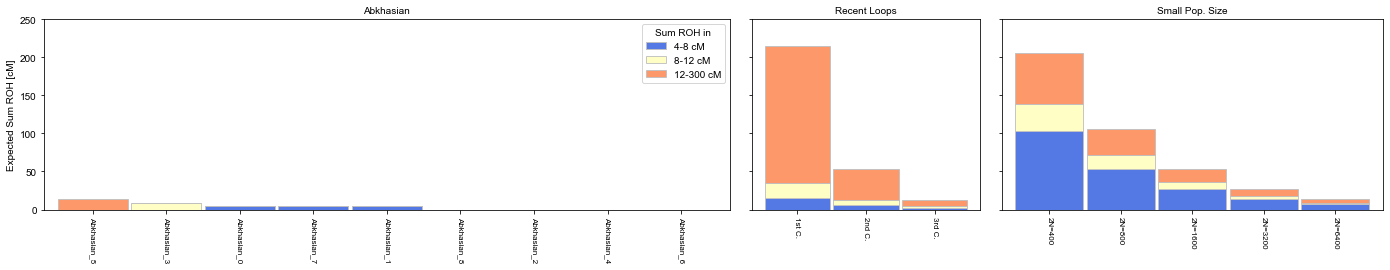

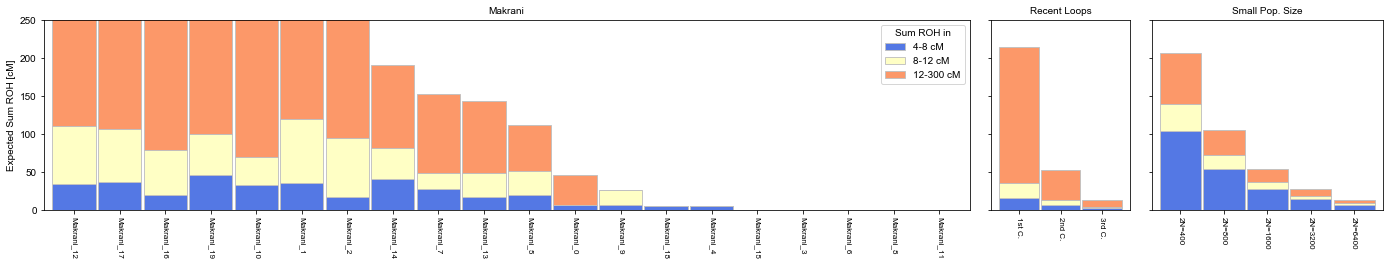

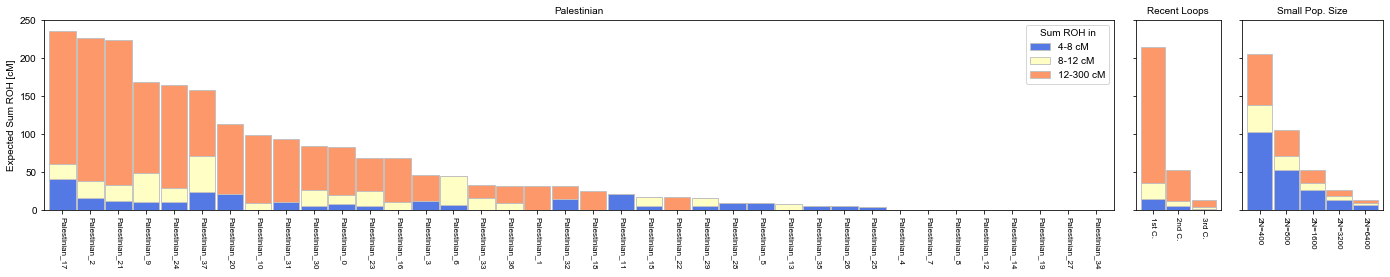

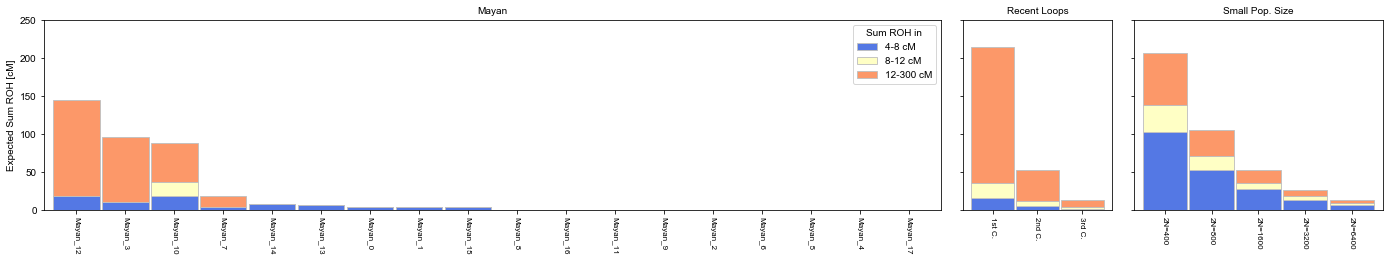

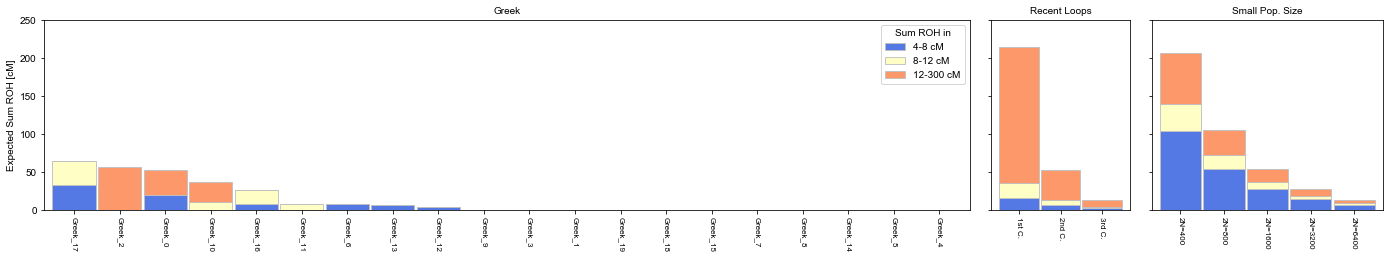

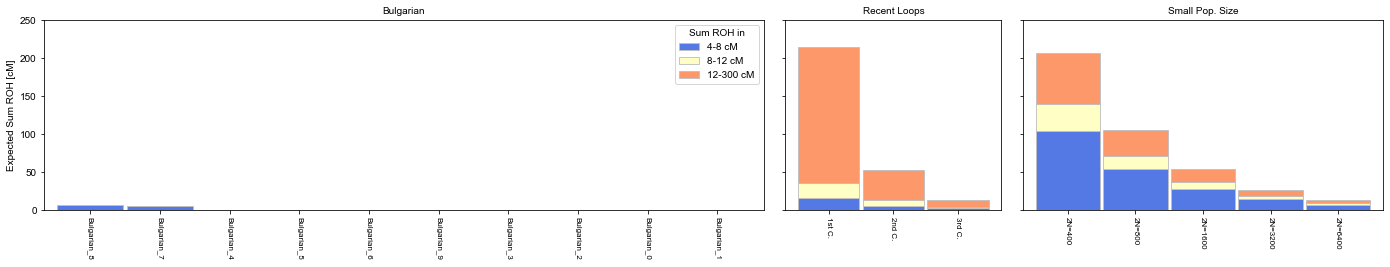

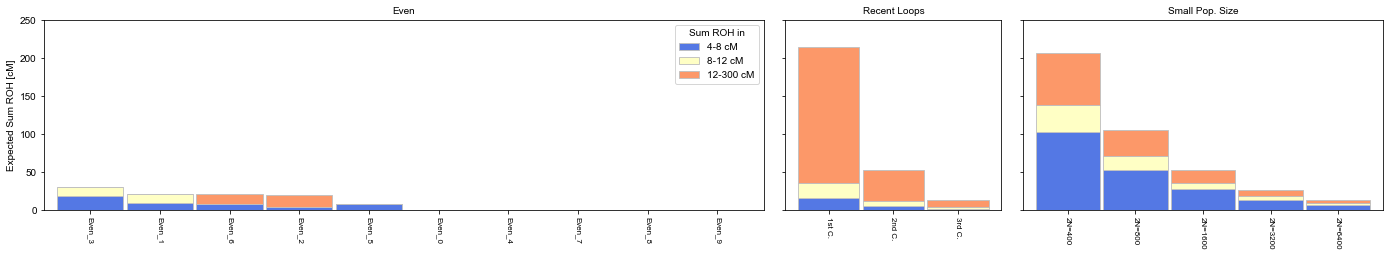

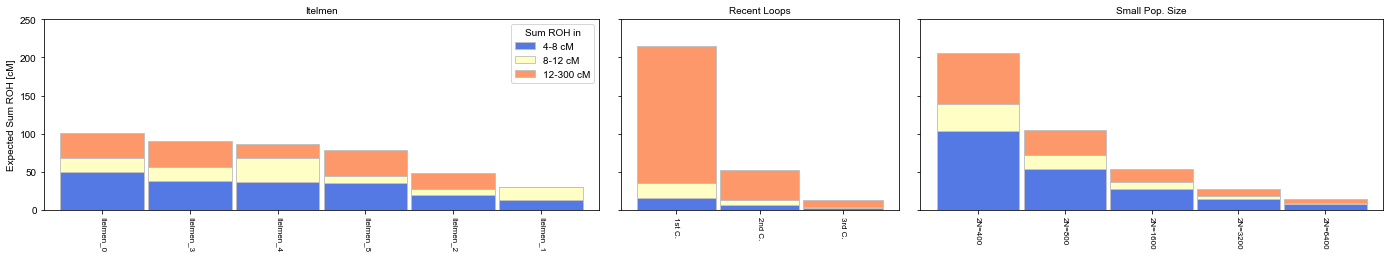

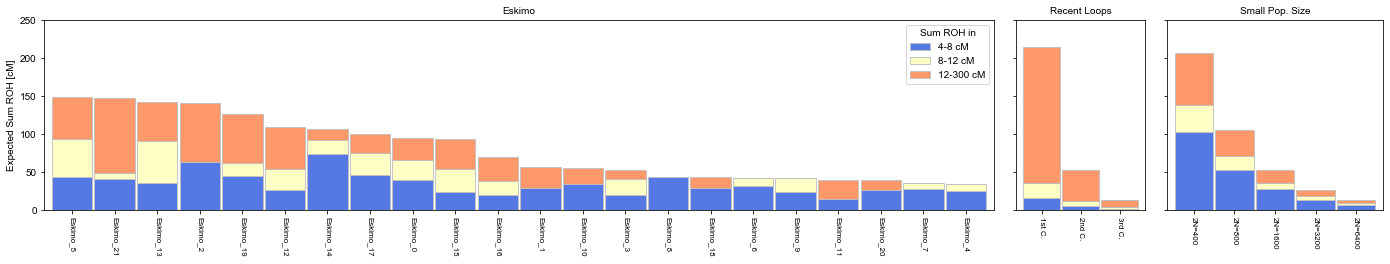

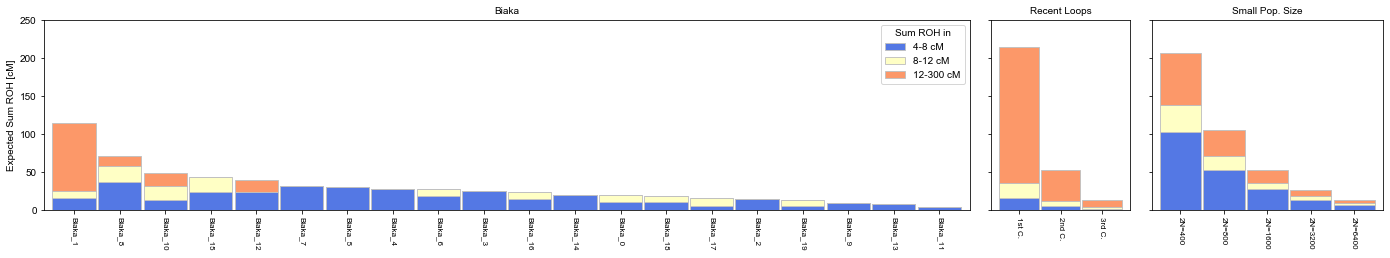

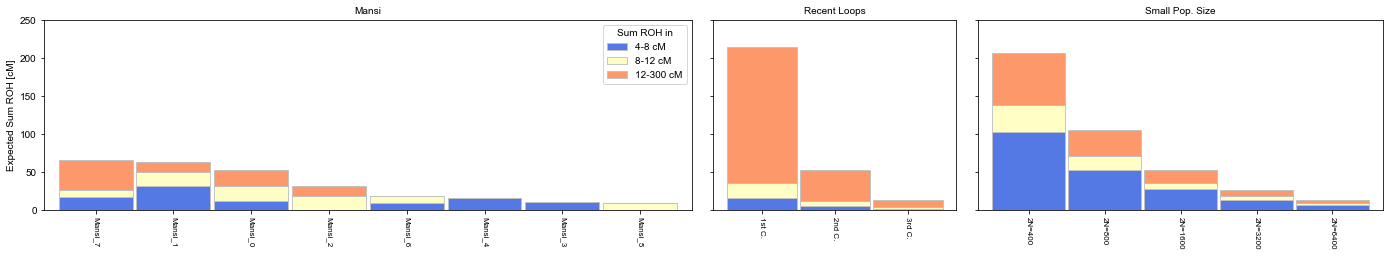

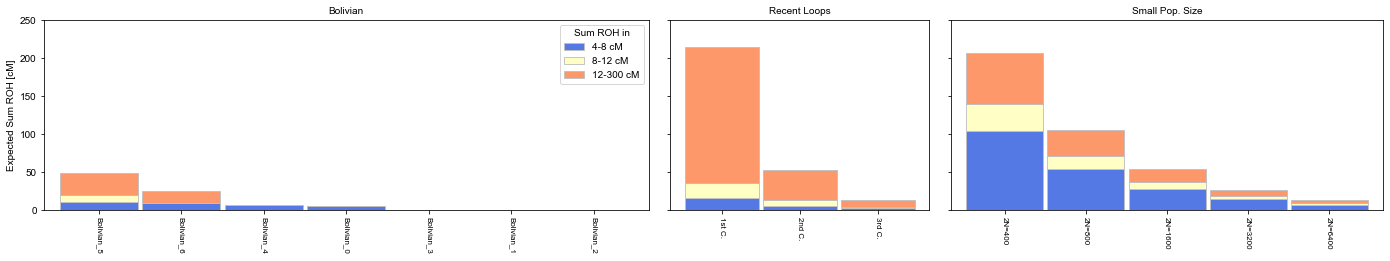

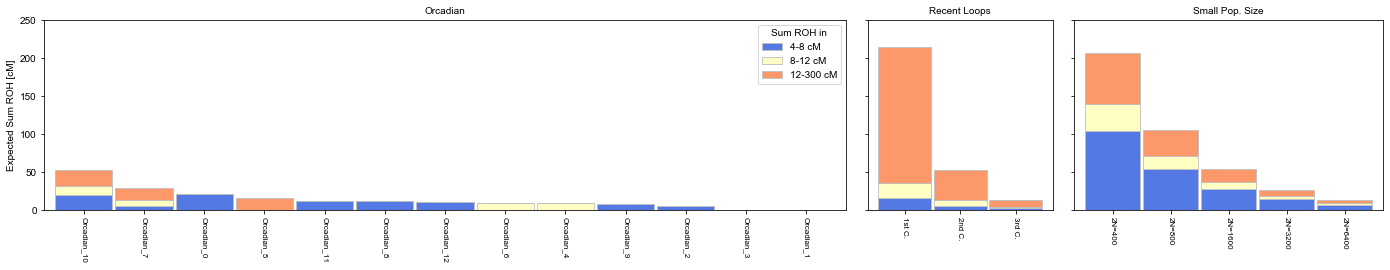

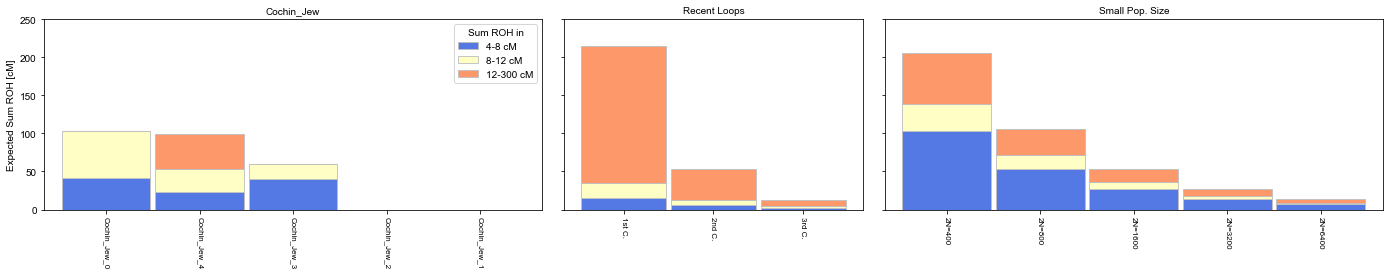

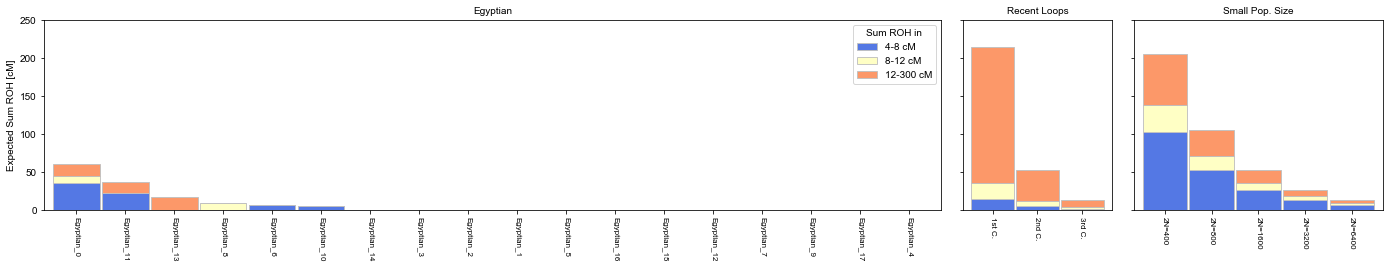

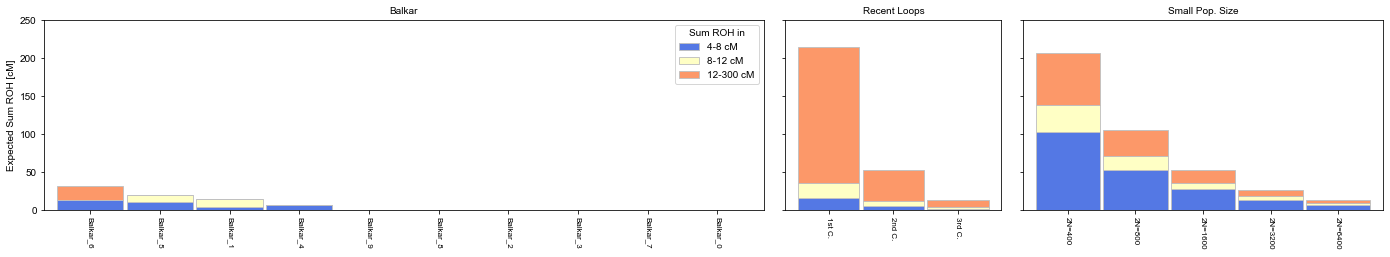

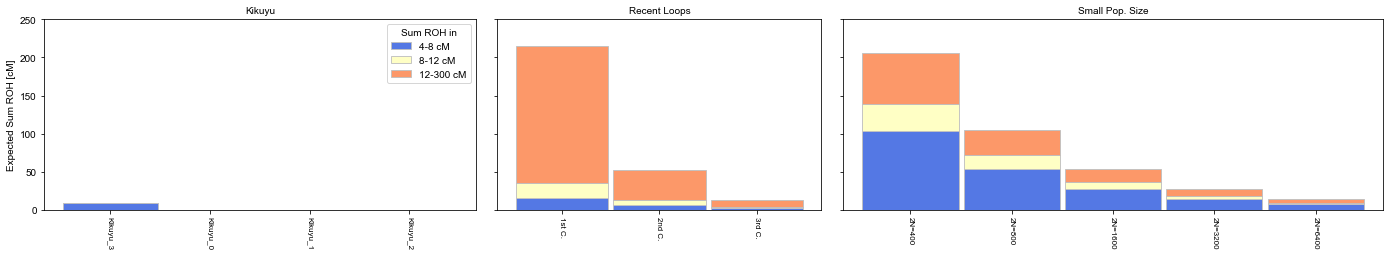

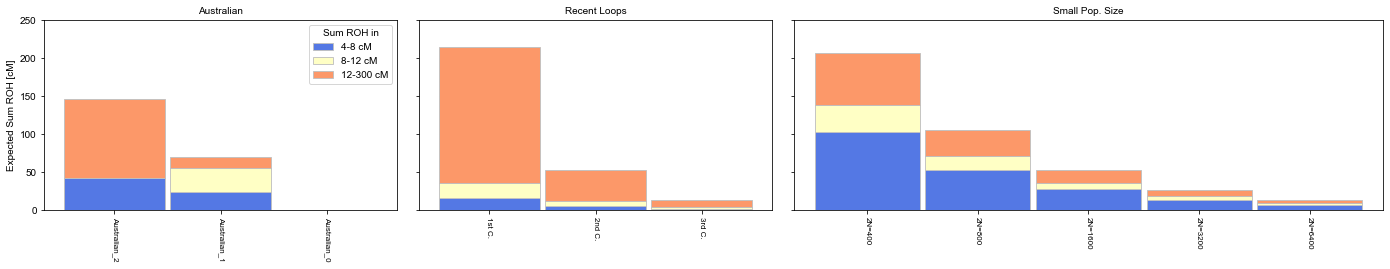

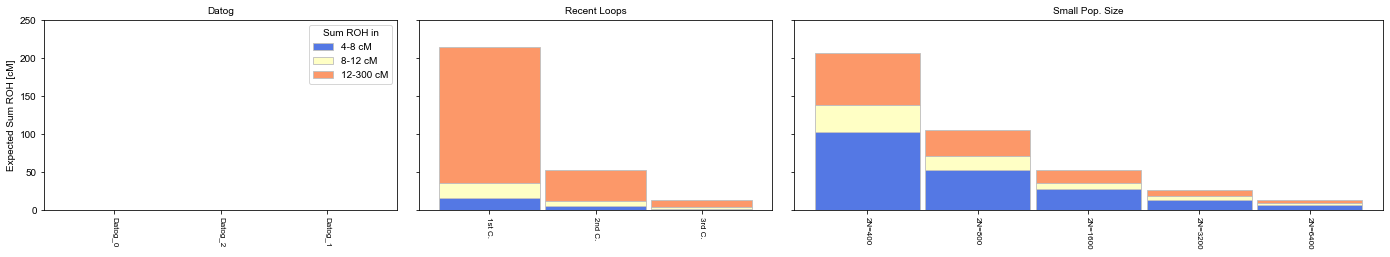

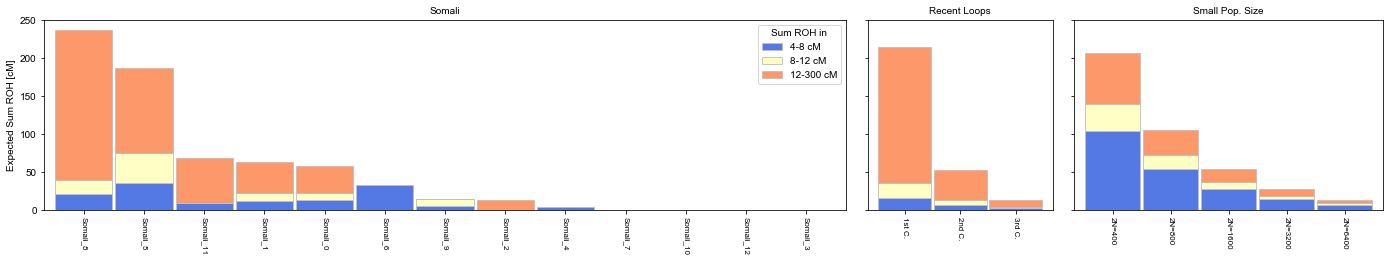

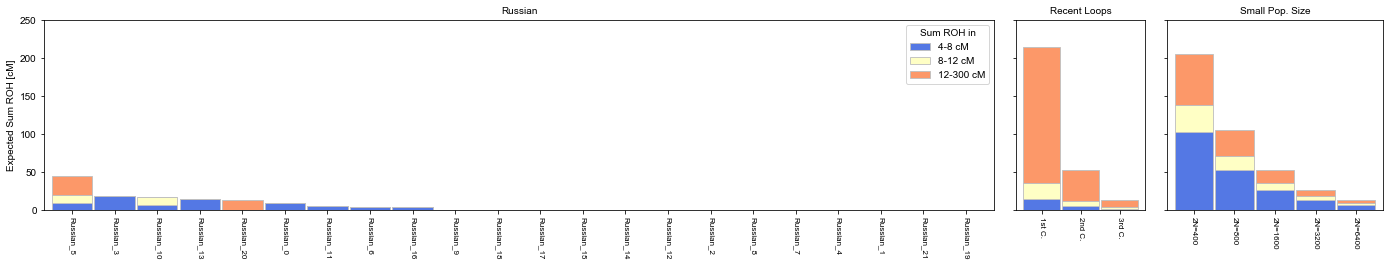

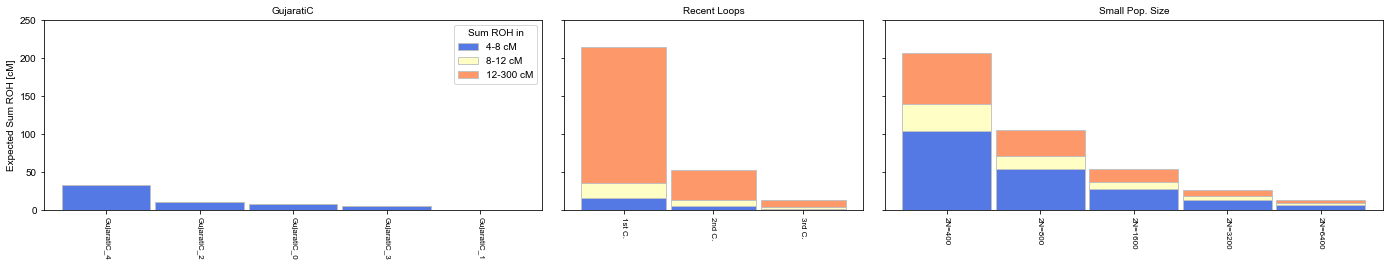

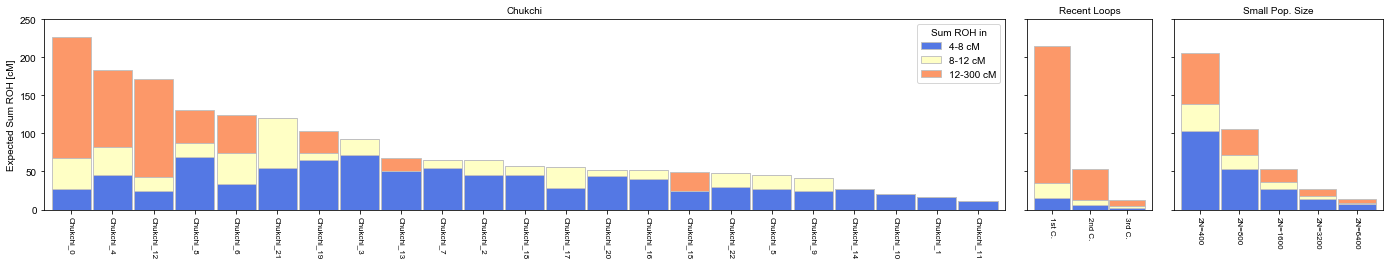

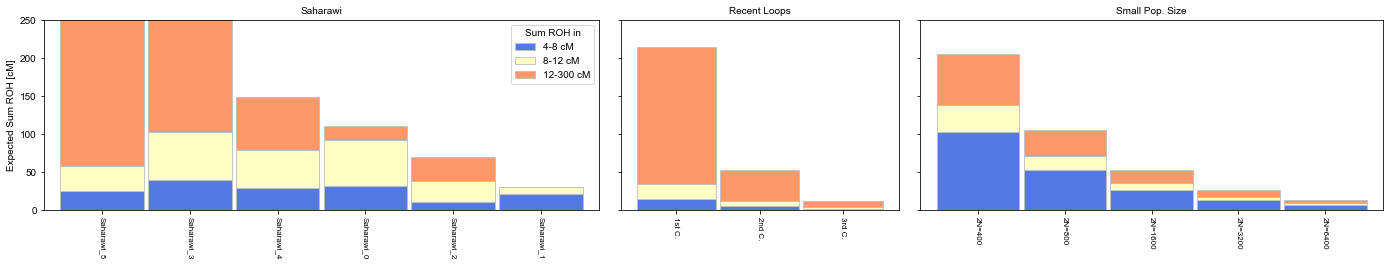

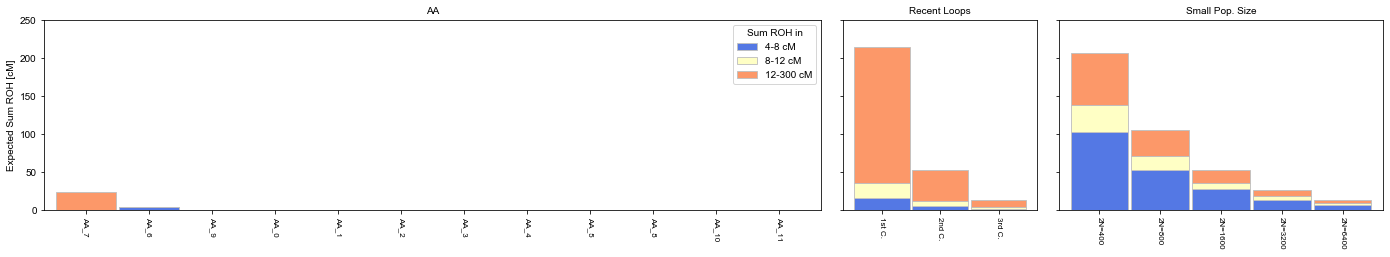

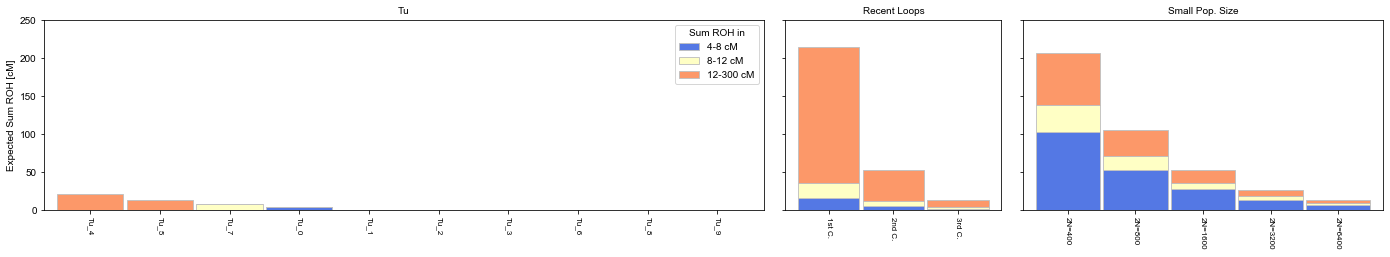

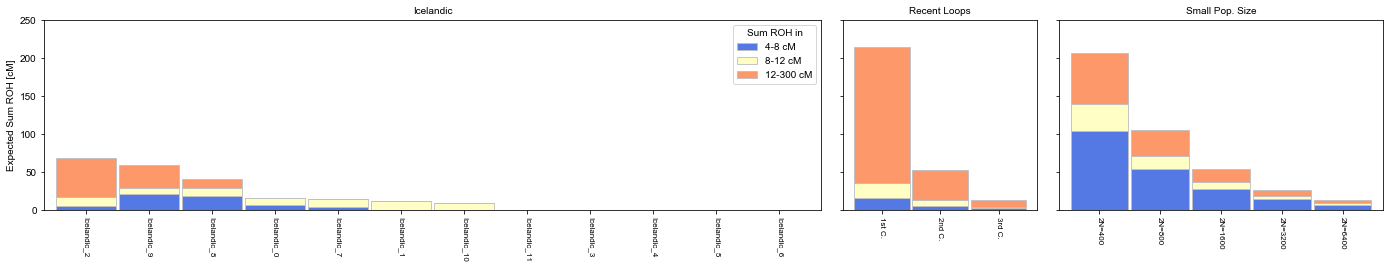

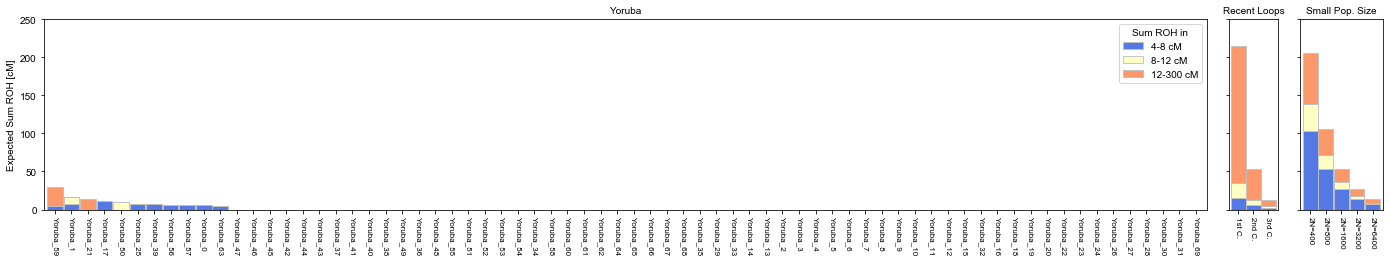

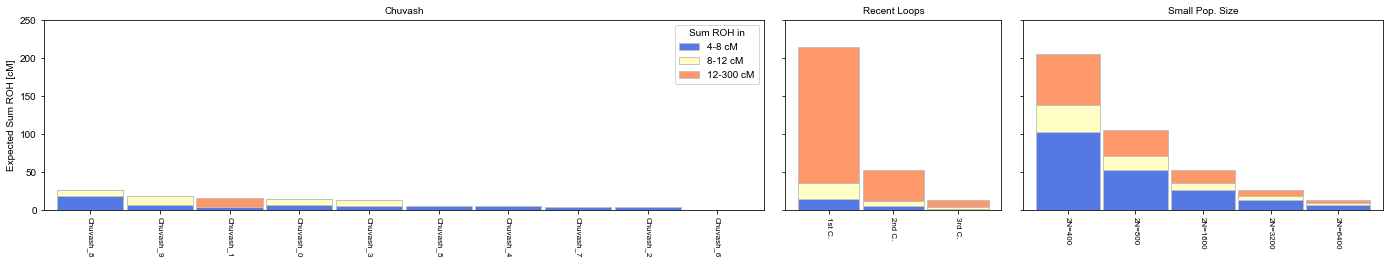

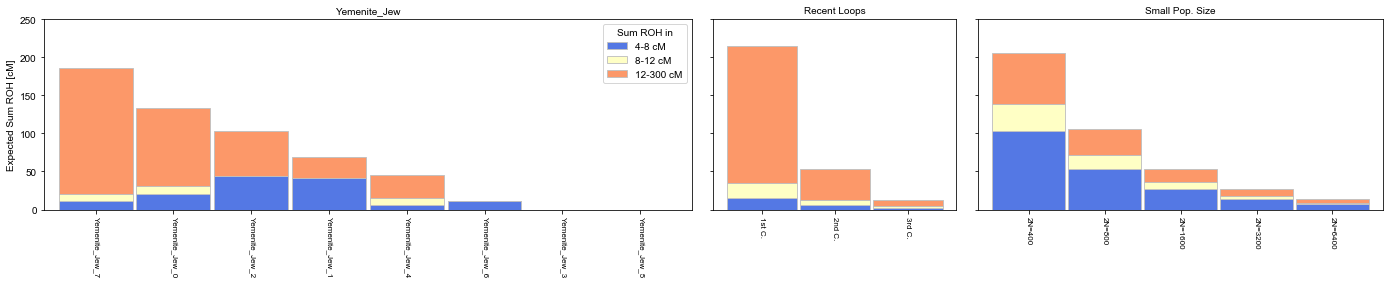

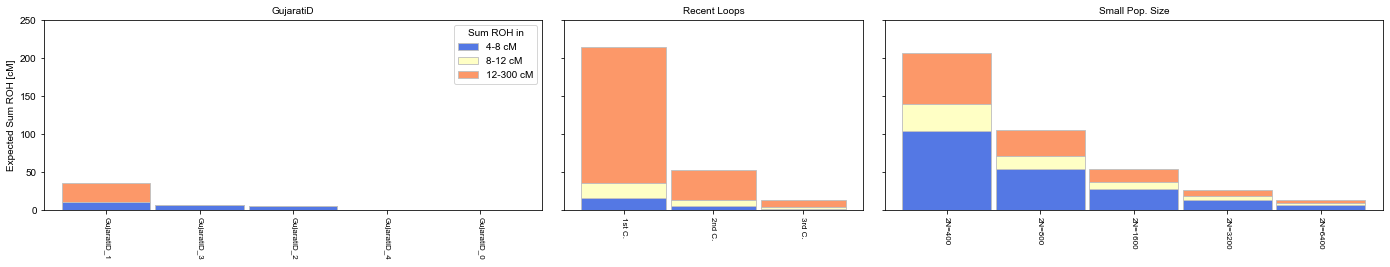

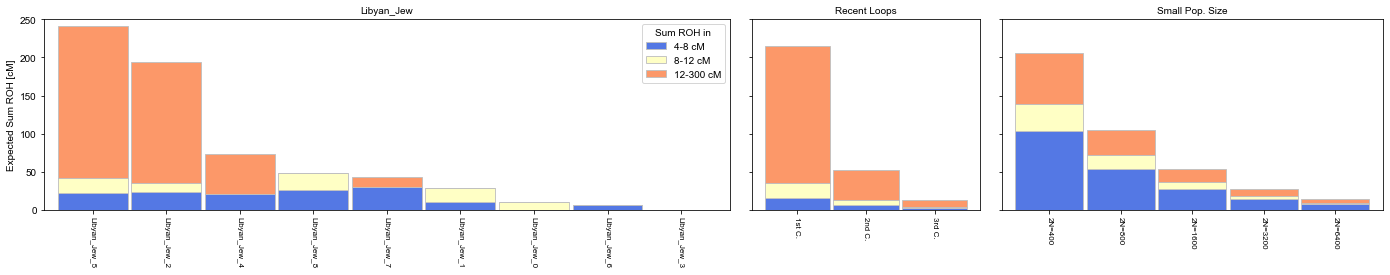

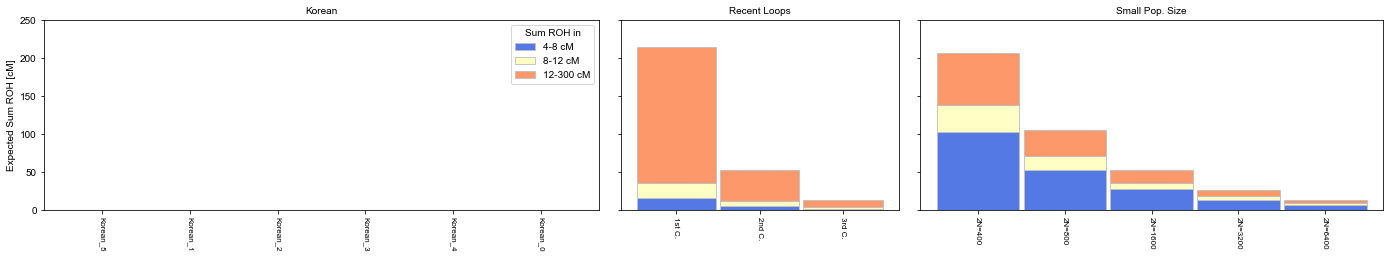

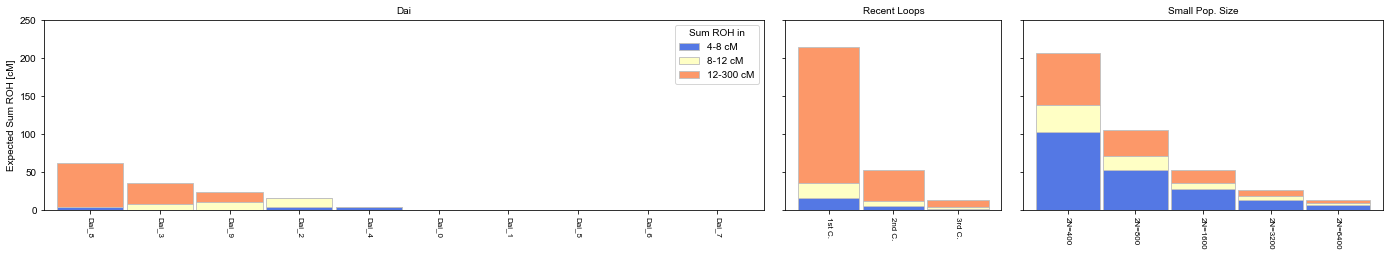

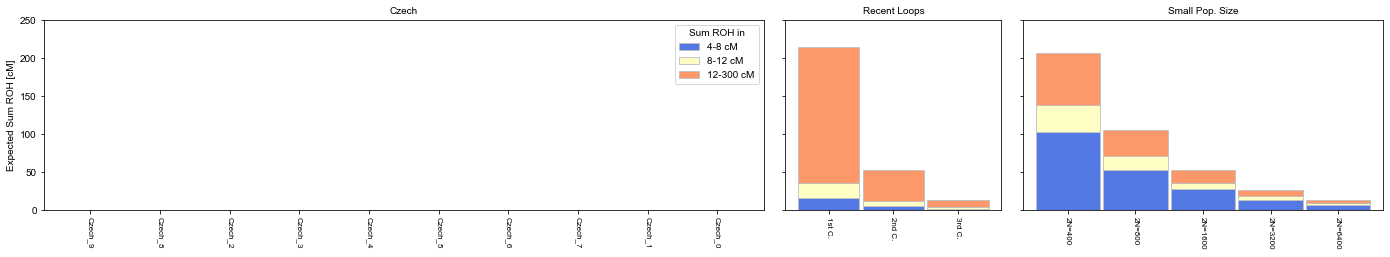

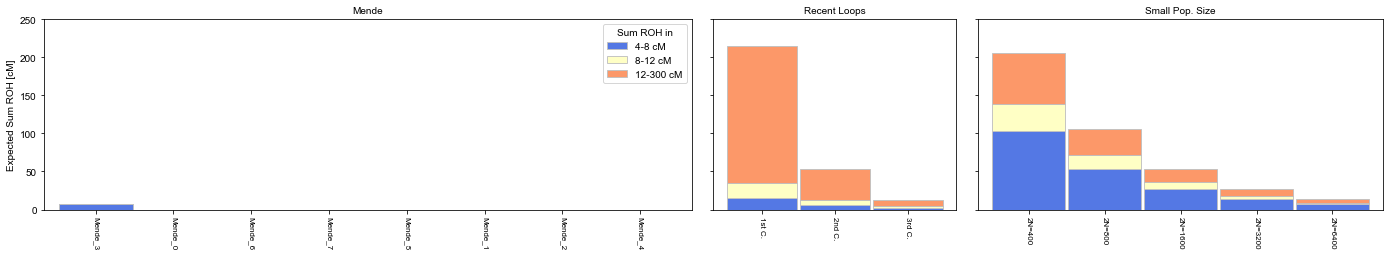

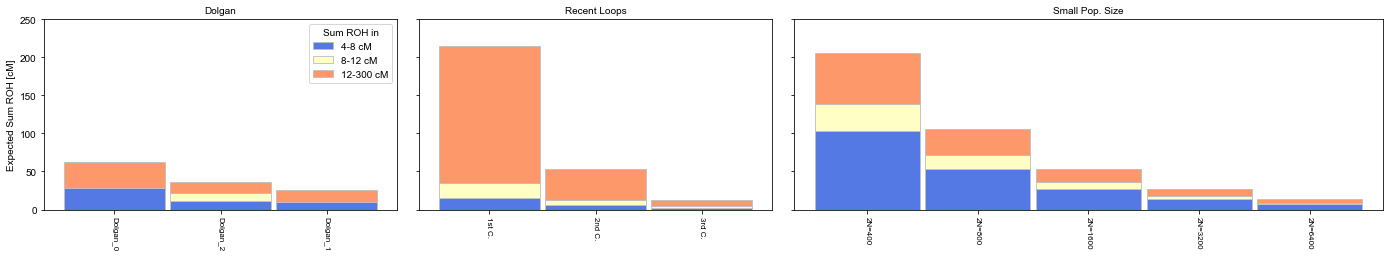

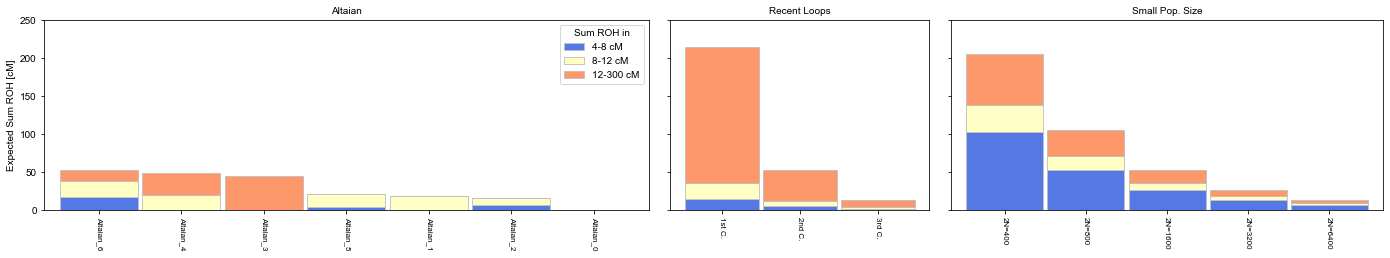

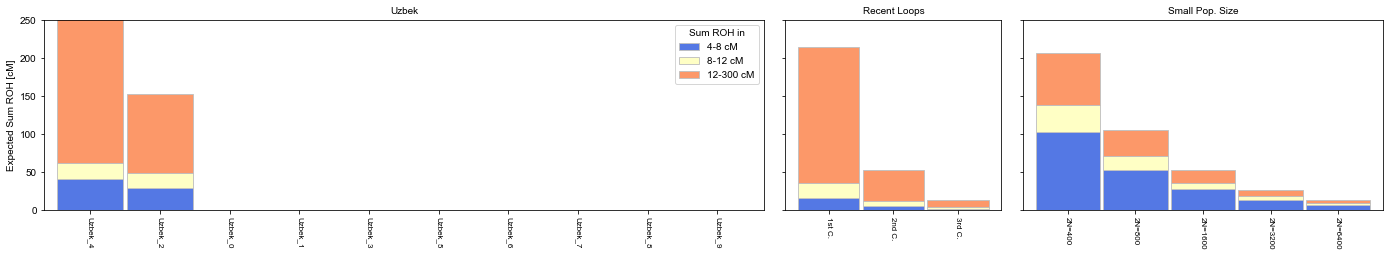

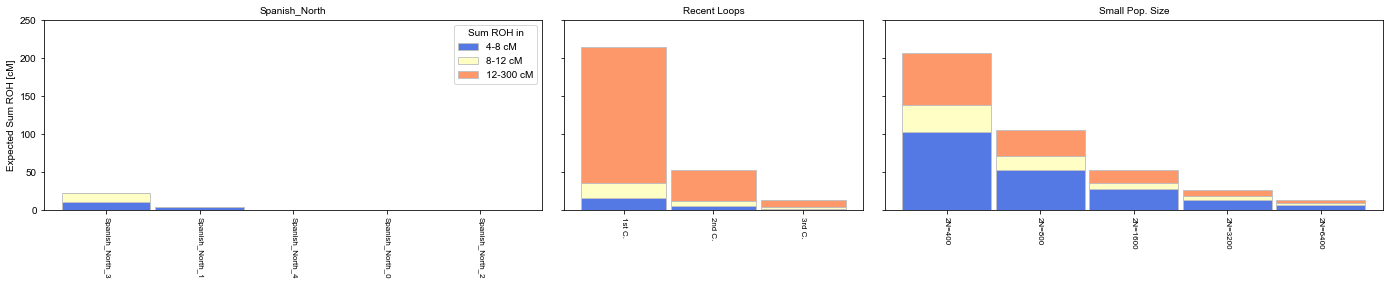

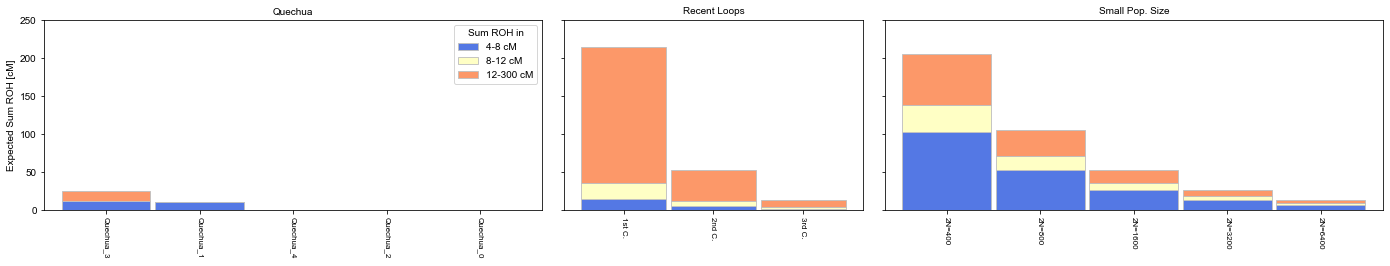

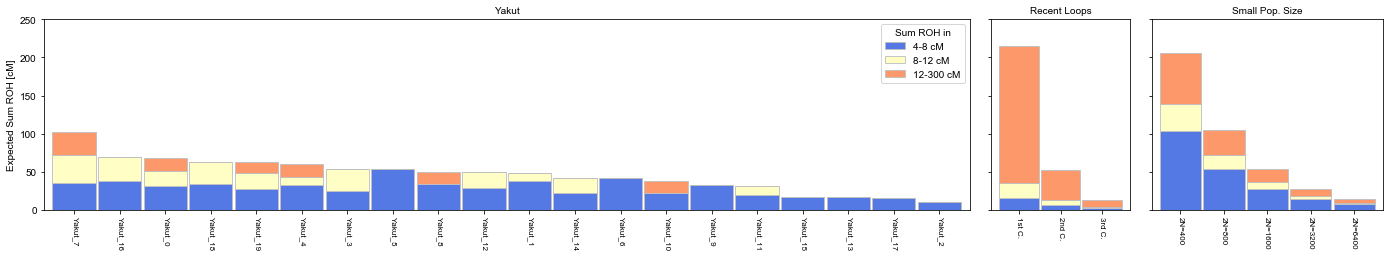

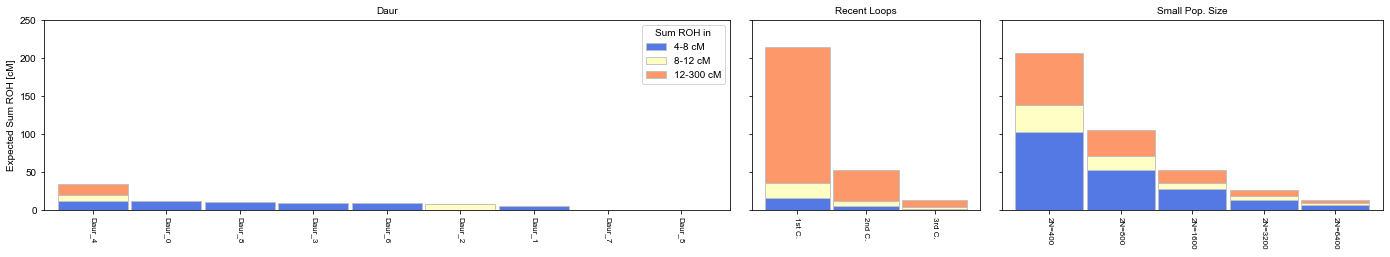

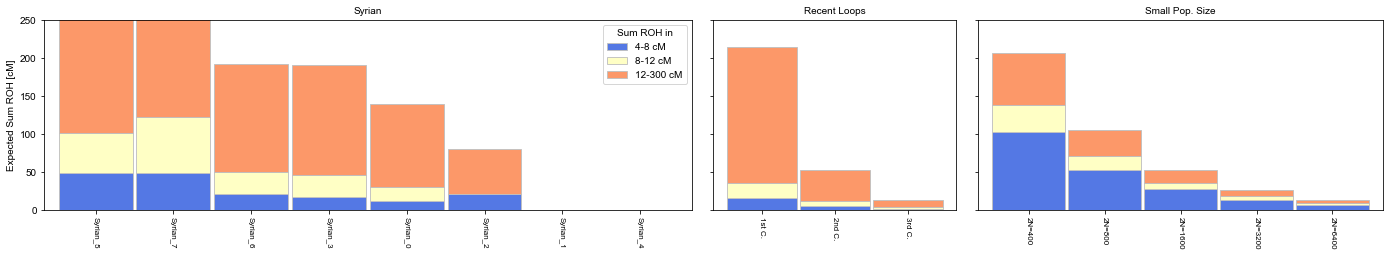

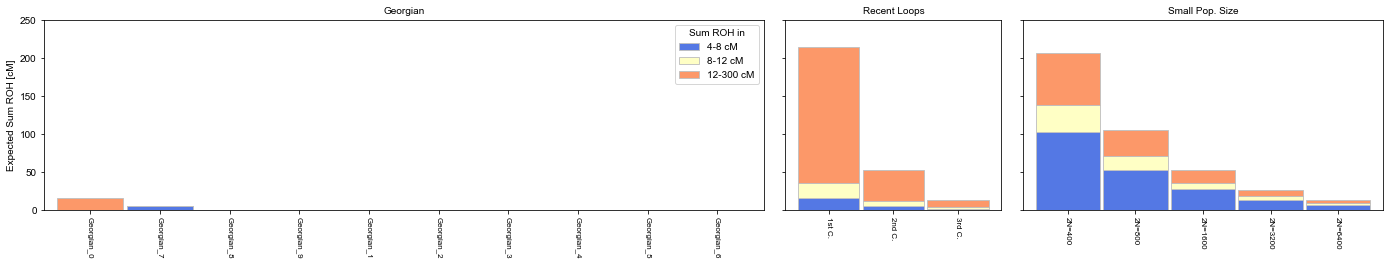

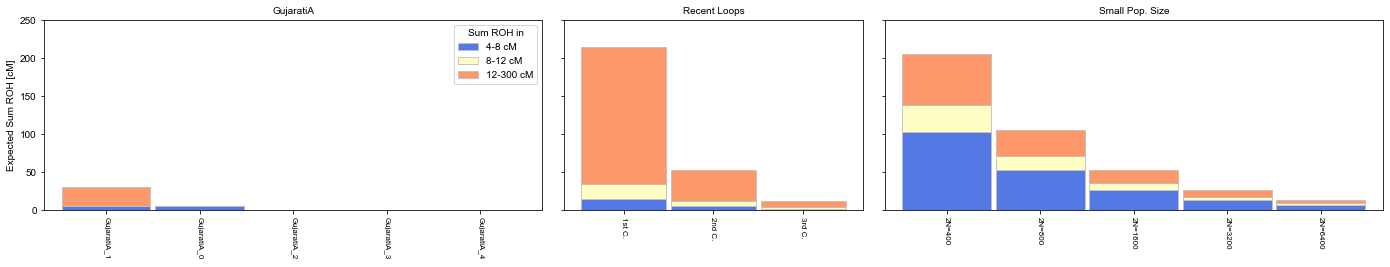

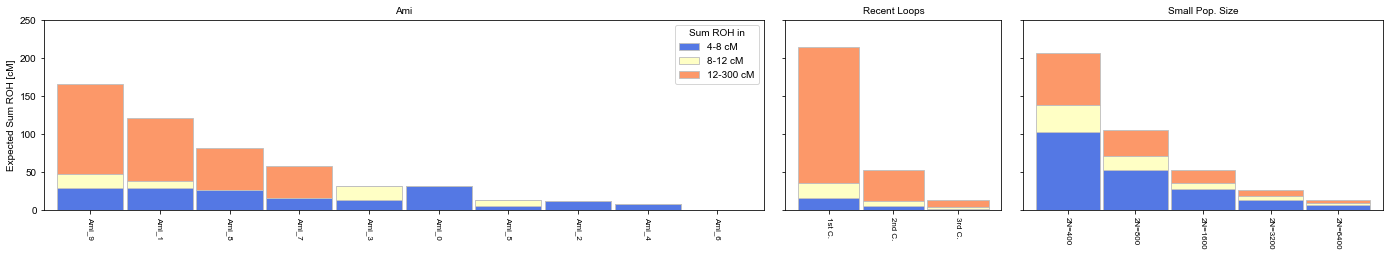

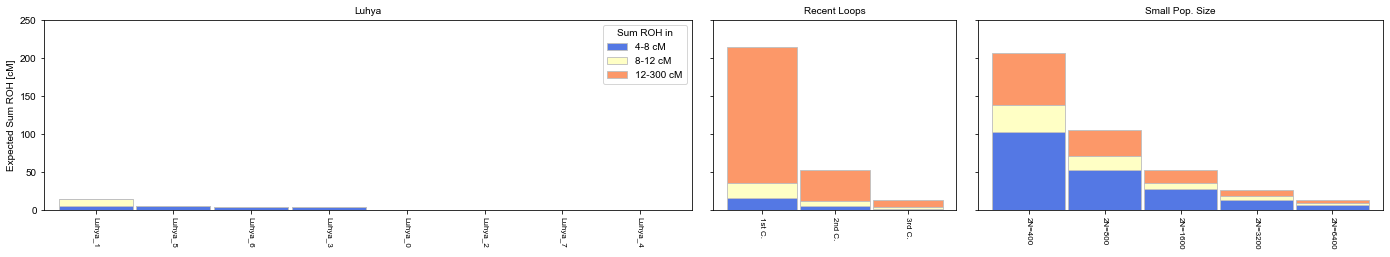

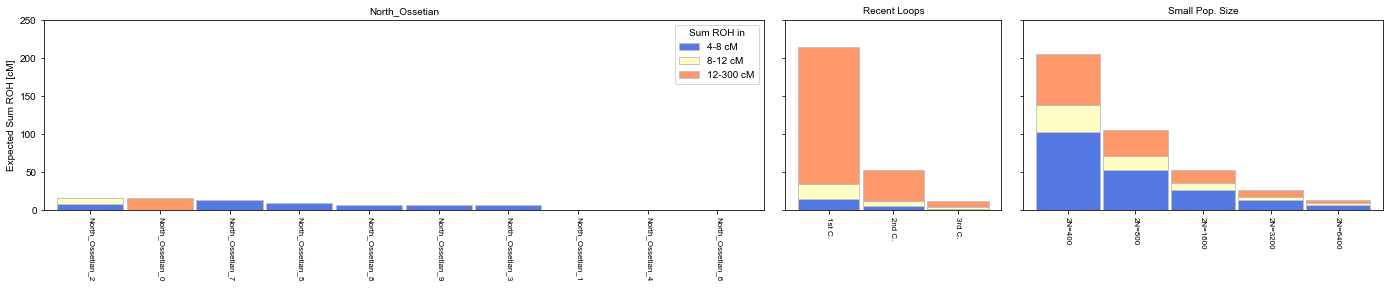

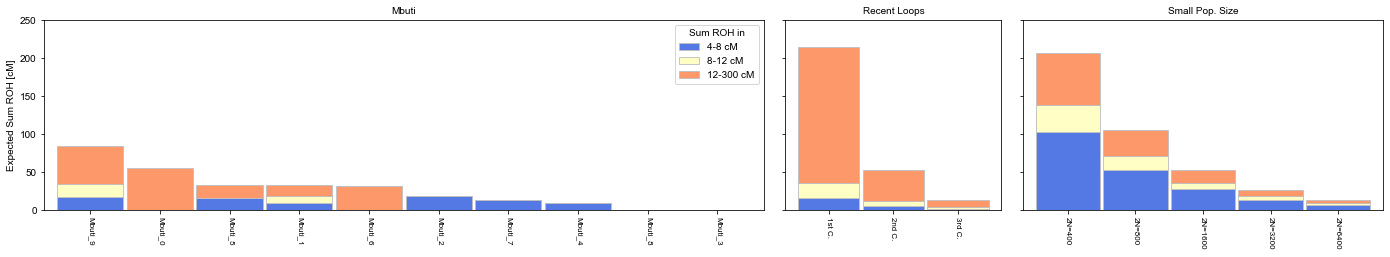

In [16]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["age"]==0]  # Extract the modern samples
df1["pop"].value_counts()
pops = set(df1["pop"])

for pop in pops:
    df_t = df1[df1["pop"]==pop].copy()    # Sindhi/Saudi/Makrani/Nganasan/Mozabite
    print(f"Doing Population {pop}: {len(df_t)} Individuals")
    savepath = "./figures/ho_pops_barplots/" + str(pop) + ".pdf" 
    plot_dfs1, cols = prepare_dfs_plot(df_t)
    plot_panel_row(plot_dfs1, savepath=savepath, leg_pos=-1, ylim=[0,250], r_title=0, show=False)

# Make Summary Plot

In [100]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1["region"].value_counts()

Balkans           315
Central Europe    246
Britain           240
Steppe            230
Iberia            159
all               157
Rome              121
Aegan              86
Sardinia           82
Baltic Sea         74
Black Sea          30
Levante            27
Andean             25
Vanuatu            19
Pacific NW         16
Atlantic Coast     15
Patagonia           8
North Africa        5
Name: region, dtype: int64

### What to plot

## Mesoltihic Iberia, Early Neolithic, Middle Neolithic
## Italian Mesolithic, Neolithic
## Central European HG, Neolithic
## Anatolia N
## Balkan HG, Neolithic

### South America?

### HO: Examples: Pakistan, South America, Europe, Chinese


### To plot (to stay flexible):
# Give list of lists (for each row) of plot_dfs (each of them pre-processed)
# Code to plot rows

### Todo: 
- Pre-Process the data
- Write the Plotting engine

# Area 51

### Pilot to Plot multiple rows

In [20]:
def plot_panel_2d(plot_dfs, gs=0):
    """Plot 2D Panel of Bar Plots for ROH"""
    raise NotImplementedError("pls do this")

def prep_gridspecs_2d(dim_list, fig, height_ratios=[]):
    """Prepare Gridspec objects.
    Return list of list of axis to plot on. 
    dim_list: List of Dimensions [integer list] for each row)
    fig: Figure Object on where to do it
    height_ratios: Ratios of the Heights of rows"""
    if len(height_ratios)==0:
        height_ratios = [1 for _ in dim_list]
        
    gs = gridspec.GridSpec(len(dim_list), 1, height_ratios=height_ratios, figure=fig)
    
    ax_list = []
    for i,d in enumerate(dim_list):
        gss = gs[i].subgridspec(1, len(d), width_ratios=d)   # Do the width_ratios here!!
        ax_list0 = [plt.subplot(g) for g in gss] # Create Axis Objects
        ax_list.append(ax_list0)
    return ax_list, gs

In [31]:
def plot_panel_roh_bars(plot_dfs, figsize=(24,6), wspace=2.0, hspace=2.0, 
                        ylim=[0,600], r_title=90, leg_pos=-1, bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Plot a panel of ROH Bars.
    plot_all_dfs: List of dfs to plot"""
    fig = plt.figure(figsize=figsize)
    bins_cM=(np.array(bins)*100).astype("int")
    
    dim_list = [list(map(len,ls)) for ls in plot_dfs]
    ax_list, gs = prep_gridspecs_2d(dim_list, fig)

    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for j, df_row in enumerate(plot_dfs): 
        for i, df in enumerate(df_row):   
            if i==0:
                ytick=True
            else:
                ytick=False

            if i == (len(df_row) + leg_pos):
                legend=True
            else:
                legend=False

            ax = ax_list[j][i]
            obs_roh = df[cols].values
            obs_roh[:,0] = obs_roh[:,0] - obs_roh[:,1]
            obs_roh[:,1] = obs_roh[:,1] - obs_roh[:,2]
            obs_roh[:,2] = obs_roh[:,2]

            plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title,
                        x_ticks = df["iid"].values, title=df["clst"].values[0], ylim=ylim)
    plt.show()

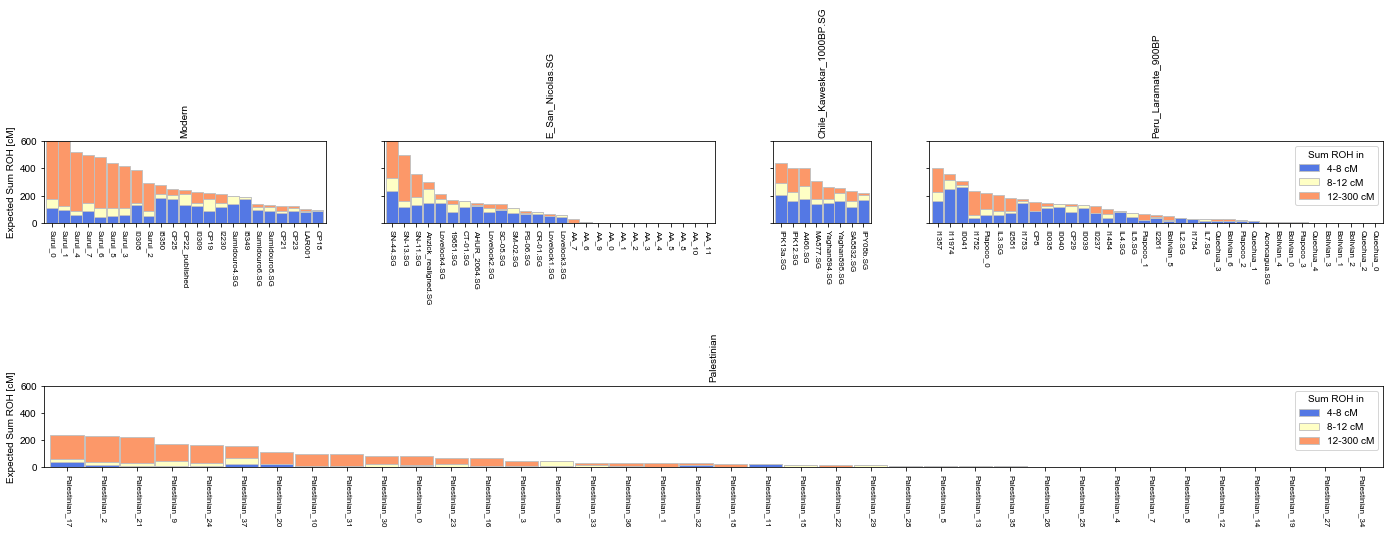

In [64]:
plot_all_dfs = [plot_dfs, plot_dfs1]
plot_panel_roh_bars(plot_all_dfs)

### Combine some interesting Pops

### Strategy 1: Combine Single Rows

### Do the Ancient South Americans (+ legend)

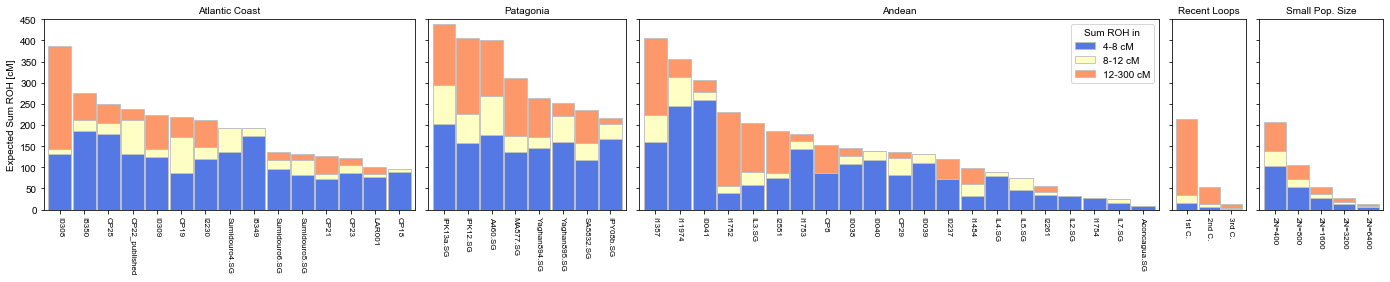

In [110]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
sa_clsts = ["Andean", "Atlantic Coast", "Patagonia"]
df_plot = df1[df1["region"].isin(sa_clsts) & df1["age"]>0].copy() # Also cut out moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,450], title_col="region", leg_pos=-1)

### Do key modern Populations (French, Han, Palestinian, Pathan)

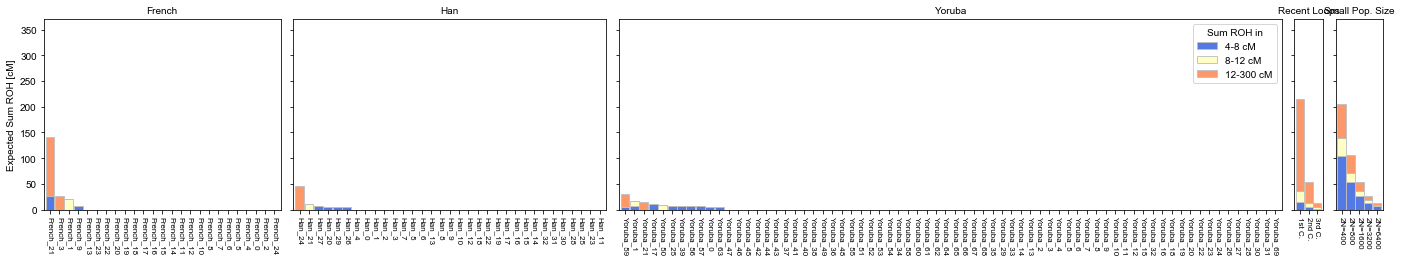

In [19]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
mod_clsts = ["French", "Han", "Yoruba"]
df_plot = df1[(df1["region"].isin(mod_clsts)) & (df1["age"]==0)].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,370], title_col="region", leg_pos=-1)

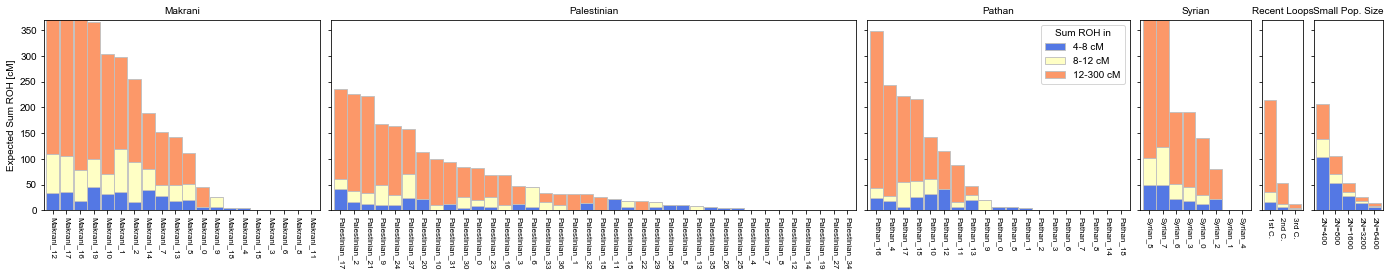

In [23]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
mod_clsts = ["Palestinian", "Pathan", "Syrian", "Makrani"]
df_plot = df1[(df1["pop"].isin(mod_clsts)) & (df1["age"]==0)].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,370], title_col="region", leg_pos=-2)

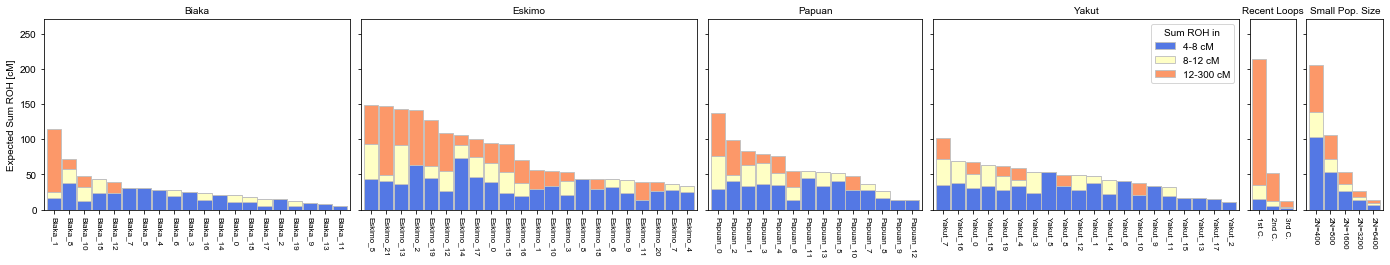

In [17]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
mod_clsts = ["Biaka", "Yakut", "Eskimo", "Papuan"]
df_plot = df1[(df1["pop"].isin(mod_clsts)) & (df1["age"]==0)].copy() # Also select only moderns!
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region", mod_group="pop")
plot_panel_row(plot_dfs, r_title=0, ylim=[0,270], title_col="region", leg_pos=-1)

### Do key ancient Eurasian Pops

In [100]:
Imperial Rome, Mesolithic Steppe, Anatolia N, Iberia Mesolithic, EN, N

iid     pop    max_roh   sum_roh>4  n_roh>4   sum_roh>8  n_roh>8  \
1325  Pathan_16  Pathan  55.872607  348.304323       18  324.781317       14   
1371   Pathan_4  Pathan  52.742100  244.559692       12  226.536497        9   
1387  Pathan_17  Pathan  36.234295  222.398890       15  216.431290       14   
1391  Pathan_15  Pathan  31.444300  216.837001       16  191.447002       11   
1458  Pathan_10  Pathan  47.161597  142.881913       12  110.382904        6   
1461  French_21  French  38.512399  141.819213        9  115.692407        4   
1512  Pathan_12  Pathan  22.803998  116.150292       11   74.829698        4   
1589  Pathan_11  Pathan  35.310304   88.365397        5   82.296398        4   
1781  Pathan_13  Pathan  18.016600   46.948092        5   27.756499        2   
1788     Han_24     Han  45.667600   45.667600        1   45.667600        1   
1936   French_3  French  27.076805   27.076805        1   27.076805        1   
1994   French_1  French  11.443901   20.940101        2   20.940101        2   
2019   Pathan_9  Pathan  11.067796   19.218797        2   19.218797        2   
2183     Han_21     Han  10.898703   10.898703        1   10.898703        1   
2295     Han_27     Han   6.631601    6.631601        1    0.000000        0   
2299   French_9  French   6.522298    6.522298        1    0.000000        0   
2331   Pathan_0  Pathan   5.785406    5.785406        1    0.000000        0   
2334   Pathan_5  Pathan   5.773600    5.773600        1    0.000000        0   
2344     Han_20     Han   5.494100    5.494100        1    0.000000        0   
2357     Han_29     Han   5.175400    5.175400        1    0.000000        0   
2401     Han_26     Han   4.469001    4.469001        1    0.000000        0   
2416   Pathan_1  Pathan   4.349303    4.349303        1    0.000000        0   
2722     Han_23     Han   0.000000    0.000000        0    0.000000        0   
2723     Han_25     Han   0.000000    0.000000        0    0.000000        0   
2724     Han_28     Han   0.000000    0.000000        0    0.000000        0   
2728     Han_30     Han   0.000000    0.000000        0    0.000000        0   
2729     Han_31     Han   0.000000    0.000000        0    0.000000        0   
2730     Han_32     Han   0.000000    0.000000        0    0.000000        0   
2735     Han_14     Han   0.000000    0.000000        0    0.000000        0   
2736     Han_15     Han   0.000000    0.000000        0    0.000000        0   
...         ...     ...        ...         ...      ...         ...      ...   
2851   French_5  French   0.000000    0.000000        0    0.000000        0   
2852   French_6  French   0.000000    0.000000        0    0.000000        0   
2853   French_7  French   0.000000    0.000000        0    0.000000        0   
2854   French_8  French   0.000000    0.000000        0    0.000000        0   
2855  French_10  French   0.000000    0.000000        0    0.000000        0   
2856  French_11  French   0.000000    0.000000        0    0.000000        0   
2857  French_12  French   0.000000    0.000000        0    0.000000        0   
2858  French_13  French   0.000000    0.000000        0    0.000000        0   
2859  French_14  French   0.000000    0.000000        0    0.000000        0   
2860  French_15  French   0.000000    0.000000        0    0.000000        0   
2861  French_16  French   0.000000    0.000000        0    0.000000        0   
2862  French_17  French   0.000000    0.000000        0    0.000000        0   
2863  French_18  French   0.000000    0.000000        0    0.000000        0   
2864  French_19  French   0.000000    0.000000        0    0.000000        0   
2898  French_20  French   0.000000    0.000000        0    0.000000        0   
2899  French_22  French   0.000000    0.000000        0    0.000000        0   
2900  French_23  French   0.000000    0.000000        0    0.000000        0   
2916      Han_0     Han   0.000000    0.000000        0    0.000000        0   
2917      Ha

## Multipanel Plot

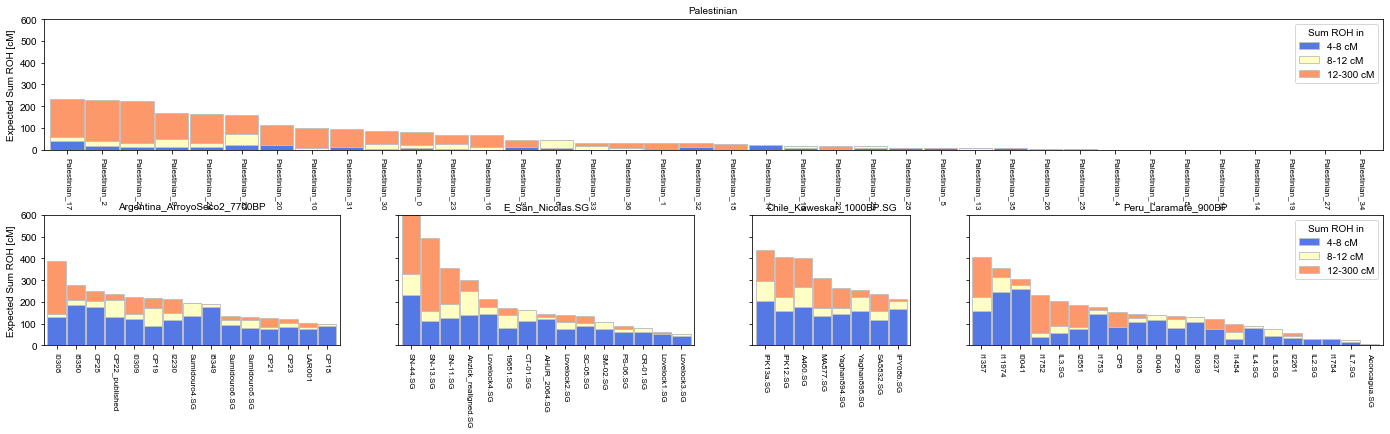

In [67]:
plot_panel_roh_bars([plot_dfs1, plot_dfs], ylim=[0,600], r_title=0, hspace=0.5)

In [36]:
df1[df1["region"]=="Pacific NW"]

iid                                pop    max_roh  \
131              SN-44.SG                   E_San_Nicolas.SG  66.042196   
133              SN-13.SG                   L_San_Nicolas.SG  59.943003   
142              SN-11.SG                   L_San_Nicolas.SG  36.899203   
148   Anzick_realigned.SG            USA_Anzick_realigned.SG  15.401101   
176          Lovelock4.SG  USA_Nevada_LovelockCave_1850BP.SG  14.604592   
189              19651.SG            Canada_BigBar_5700BP.SG  17.811894   
192              CT-01.SG                            LSCI.SG  10.993397   
203          AHUR_2064.SG   USA_Nevada_SpiritCave_11000BP.SG  14.925504   
205          Lovelock2.SG  USA_Nevada_LovelockCave_1850BP.SG  18.530298   
216              SC-05.SG                            LSCI.SG  17.743901   
242              SM-02.SG        Island_Chumash_SanMiguel.SG  11.751485   
273              PS-06.SG                Mainland_Chumash.SG  14.287699   
287              CR-01.SG          Island_Chumash_SanCruz.SG   9.931195   
325          Lovelock1.SG  USA_Nevada_LovelockCave_1850BP.SG  12.257900   
357          Lovelock3.SG   USA_Nevada_LovelockCave_600BP.SG  11.797404   
1958                 AA_7                                 AA  24.010998   
2443                 AA_6                                 AA   4.042900   
3101                 AA_9                                 AA   0.000000   
3109                 AA_0                                 AA   0.000000   
3110                 AA_1                                 AA   0.000000   
3111                 AA_2                                 AA   0.000000   
3112                 AA_3                                 AA   0.000000   
3113                 AA_4                                 AA   0.000000   
3114                 AA_5                                 AA   0.000000   
3115                 AA_8                                 AA   0.000000   
3116                AA_10                                 AA   0.000000   
3118                AA_11                                 AA   0.000000   

       sum_roh>4  n_roh>4   sum_roh>8  n_roh>8  sum_roh>12  n_roh>12  \
131   792.091549       73  562.336516       31  463.570596        21   
133   494.892271       41  381.758955       20  336.693565        15   
142   358.258219       37  230.439425       14  169.441214         8   
148   302.329603       41  160.474503       15   53.022099         4   
176   214.599305       35   68.356282        6   39.457488         3   
189   169.989804       23   89.717498        8   30.969095         2   
192   162.089184       26   47.735390        5    0.000000         0   
203   144.004594       25   23.061604        2   14.925504         1   
205   140.464498       19   63.424200        5   31.748093         2   
216   134.192722       21   43.596606        3   33.130203         2   
242   106.116567       17   32.236183        3    0.000000         0   
273    88.053004       14   24.150099        2   14.287699         1   
287    82.186784       14   19.726494        2    0.000000         0   
325    63.069886       11   12.257900        1   12.257900         1   
357    54.604107       10   11.797404        1    0.000000         0   
1958   24.010998        1   24.010998        1   24.010998         1   
2443    4.042900        1    0.000000        0    0.000000         0   
3101    0.000000        0    0.000000        0    0.000000         0   
3109    0.000000        0    0.000000        0    0.000000         0   
3110    0.000000        0    0.000000        0    0.000000         0   
3111    0.000000        0    0.000000        0    0.000000         0   
3112    0.000000        0    0.000000        0    0.000000         0   
3113    0.000000        0    0.000000        0    0.000000         0   
3114    0.000000        0    0.000000        0    0.000000         0   
3115    0.000000        0    0.000000        0    0.000000         0   
3116    0.000000        0    0.000000        0   